In [1]:
# https://medium.com/@apoddar573/making-your-own-custom-environment-in-gym-c3b65ff8cdaa

from livelossplot.keras import PlotLossesCallback
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
#import tensorflow as tf
import random
import csv
import math
import os
import copy
import keras
import string
import pickle
import re
import gym
import gym_foo

from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam, SGD, Adadelta

from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
import rl.callbacks

# https://github.com/keras-rl/keras-rl/blob/master/examples/dqn_cartpole.py
ENV_NAME = 'foo-v0-7'
env = gym.make('foo-v0')
np.random.seed(123)
nb_actions = env.action_space.n

# https://qiita.com/inoory/items/e63ade6f21766c7c2393
class EpisodeLogger(rl.callbacks.Callback):
    def __init__(self):
        self.observations = {}
        self.rewards = {}
        self.actions = {}

    def on_episode_begin(self, episode, logs):
        self.observations[episode] = []
        self.rewards[episode] = []
        self.actions[episode] = []

    def on_step_end(self, step, logs):
        episode = logs['episode']
        self.observations[episode].append(logs['observation'])
        self.rewards[episode].append(logs['reward'])
        self.actions[episode].append(logs['action'])

cb_ep = EpisodeLogger()



input_shape = (46, 500, 1)
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(100, kernel_size=(12,12),activation='relu', input_shape=input_shape))
model.add(keras.layers.Conv2D(50, (6, 6), padding="SAME", activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.MaxPooling2D(pool_size=(3, 3)))
model.add(keras.layers.Conv2D(20, (5, 5), padding="SAME", activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(2, activation='relu'))
model.add(keras.layers.Dropout(0.8))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(61))
model.summary()

model.compile(loss="mean_squared_error",
    #optimizer=tf.keras.optimizers.Adadelta(lr=1.0),
    #optimizer=keras.optimizers.SGD(lr=0.00052),
    optimizer=keras.optimizers.Adam(0.00001),
    metrics=['accuracy'])

memory = SequentialMemory(limit=50000, window_length=1)
policy = EpsGreedyQPolicy(0.5)
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=1000,
               target_model_update=1e-2, policy=policy, enable_double_dqn=True)

dqn.compile(Adam(0.0001), metrics=['mae'])
dqn.load_weights("/home/englab5510/PycharmProjects/mmWave1/reinforcement_data/trial3/cnn_models/model_1.h5")
#dqn.load_weights("dqn_foo-v0-7_weights.h5f")
#dqn.compile(Adam(lr=1e-3), metrics=['mae'])

# Okay, now it's time to learn something! We visualize the training here for show, but this
# slows down training quite a lot. You can always safely abort the training prematurely using
# Ctrl + C.
history = dqn.fit(env, nb_steps=500000, visualize=False, verbose=2, callbacks=[cb_ep])

# After training is done, we save the final weights.
dqn.save_weights('dqn_{}_weights.h5f'.format(ENV_NAME), overwrite=True)

# Finally, evaluate our algorithm for 5 episodes.
dqn.test(env, nb_episodes=5, visualize=False)


Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 35, 489, 100)      14500     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 35, 489, 50)       180050    
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 489, 50)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 163, 50)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 163, 20)       25020     
_________________________________________________________________
dropout_2 (Dropout)          (None, 11, 163, 20)       0         
_________________________________________________________________
dense_1 (Dense)              (None, 11, 163, 2)       

    920/500000: episode: 23, duration: 0.118s, episode steps: 40, steps per second: 340, episode reward: 22.563, mean reward: 0.564 [0.088, 1.000], mean action: 30.600 [0.000, 60.000], mean observation: -0.137 [-1.000, 1.000], loss: --, mean_absolute_error: --, mean_q: --
806 (array([22]),) False
    960/500000: episode: 24, duration: 0.120s, episode steps: 40, steps per second: 333, episode reward: 27.702, mean reward: 0.693 [0.075, 1.000], mean action: 24.500 [2.000, 59.000], mean observation: -0.136 [-1.000, 1.000], loss: --, mean_absolute_error: --, mean_q: --
517 (array([22]),) False
   1000/500000: episode: 25, duration: 0.119s, episode steps: 40, steps per second: 336, episode reward: 28.323, mean reward: 0.708 [0.134, 1.000], mean action: 27.625 [6.000, 59.000], mean observation: -0.110 [-1.000, 1.000], loss: --, mean_absolute_error: --, mean_q: --
703 (array([3]),) False
   1040/500000: episode: 26, duration: 33.185s, episode steps: 40, steps per second: 1, episode reward: 27.

   2000/500000: episode: 50, duration: 29.908s, episode steps: 40, steps per second: 1, episode reward: 28.303, mean reward: 0.708 [0.005, 1.000], mean action: 23.925 [1.000, 58.000], mean observation: -0.141 [-1.000, 1.000], loss: 0.089087, mean_absolute_error: 1.501520, mean_q: 2.429378
568 (array([22]),) False
   2040/500000: episode: 51, duration: 30.774s, episode steps: 40, steps per second: 1, episode reward: 26.621, mean reward: 0.666 [0.000, 0.960], mean action: 18.375 [2.000, 59.000], mean observation: -0.131 [-1.000, 1.000], loss: 0.088439, mean_absolute_error: 1.480491, mean_q: 2.380735
738 (array([12]),) False
   2080/500000: episode: 52, duration: 30.746s, episode steps: 40, steps per second: 1, episode reward: 33.908, mean reward: 0.848 [0.100, 1.000], mean action: 14.925 [6.000, 56.000], mean observation: -0.134 [-1.000, 1.000], loss: 0.085930, mean_absolute_error: 1.501601, mean_q: 2.407306
697 (array([22]),) False
   2120/500000: episode: 53, duration: 30.805s, episode

   3080/500000: episode: 77, duration: 30.740s, episode steps: 40, steps per second: 1, episode reward: 16.183, mean reward: 0.405 [0.003, 0.669], mean action: 19.175 [0.000, 59.000], mean observation: -0.110 [-1.000, 1.000], loss: 0.087982, mean_absolute_error: 2.059103, mean_q: 2.879441
79 (array([22]),) False
   3120/500000: episode: 78, duration: 30.033s, episode steps: 40, steps per second: 1, episode reward: 29.643, mean reward: 0.741 [0.074, 0.974], mean action: 18.350 [3.000, 50.000], mean observation: -0.091 [-1.000, 1.000], loss: 0.089713, mean_absolute_error: 2.074594, mean_q: 2.897828
156 (array([22]),) False
   3160/500000: episode: 79, duration: 30.798s, episode steps: 40, steps per second: 1, episode reward: 23.062, mean reward: 0.577 [0.029, 1.000], mean action: 20.075 [1.000, 59.000], mean observation: -0.167 [-1.000, 1.000], loss: 0.094416, mean_absolute_error: 2.087639, mean_q: 2.904129
282 (array([22]),) False
   3200/500000: episode: 80, duration: 30.738s, episode 

   4160/500000: episode: 104, duration: 30.805s, episode steps: 40, steps per second: 1, episode reward: 24.006, mean reward: 0.600 [0.081, 1.000], mean action: 21.775 [0.000, 58.000], mean observation: -0.076 [-1.000, 1.000], loss: 0.117699, mean_absolute_error: 2.683311, mean_q: 3.501291
708 (array([40]),) False
   4200/500000: episode: 105, duration: 30.861s, episode steps: 40, steps per second: 1, episode reward: 24.187, mean reward: 0.605 [0.343, 0.936], mean action: 21.400 [7.000, 60.000], mean observation: -0.141 [-1.000, 1.000], loss: 0.122754, mean_absolute_error: 2.693961, mean_q: 3.513319
707 (array([48]),) False
   4240/500000: episode: 106, duration: 30.027s, episode steps: 40, steps per second: 1, episode reward: 24.235, mean reward: 0.606 [0.000, 0.943], mean action: 20.900 [0.000, 59.000], mean observation: -0.141 [-1.000, 1.000], loss: 0.115677, mean_absolute_error: 2.726293, mean_q: 3.545978
135 (array([22]),) False
   4280/500000: episode: 107, duration: 30.734s, epi

   5200/500000: episode: 130, duration: 30.024s, episode steps: 40, steps per second: 1, episode reward: 30.255, mean reward: 0.756 [0.086, 1.000], mean action: 21.400 [0.000, 59.000], mean observation: -0.178 [-1.000, 1.000], loss: 0.157584, mean_absolute_error: 3.253052, mean_q: 4.092706
578 (array([22]),) False
   5240/500000: episode: 131, duration: 30.833s, episode steps: 40, steps per second: 1, episode reward: 30.188, mean reward: 0.755 [0.078, 0.998], mean action: 20.775 [0.000, 60.000], mean observation: -0.133 [-1.000, 1.000], loss: 0.155632, mean_absolute_error: 3.279781, mean_q: 4.110999
846 (array([48]),) False
   5280/500000: episode: 132, duration: 30.721s, episode steps: 40, steps per second: 1, episode reward: 28.861, mean reward: 0.722 [0.028, 0.931], mean action: 22.525 [9.000, 60.000], mean observation: -0.124 [-1.000, 1.000], loss: 0.144343, mean_absolute_error: 3.296880, mean_q: 4.134599
50 (array([22]),) False
   5320/500000: episode: 133, duration: 30.784s, epis

   6240/500000: episode: 156, duration: 30.751s, episode steps: 40, steps per second: 1, episode reward: 15.014, mean reward: 0.375 [0.000, 1.000], mean action: 24.800 [2.000, 59.000], mean observation: -0.102 [-1.000, 1.000], loss: 0.191617, mean_absolute_error: 3.760380, mean_q: 4.604051
215 (array([22]),) False
   6280/500000: episode: 157, duration: 30.781s, episode steps: 40, steps per second: 1, episode reward: 24.114, mean reward: 0.603 [0.154, 1.000], mean action: 18.675 [0.000, 60.000], mean observation: -0.185 [-1.000, 1.000], loss: 0.216858, mean_absolute_error: 3.795906, mean_q: 4.618903
494 (array([48]),) False
   6320/500000: episode: 158, duration: 29.968s, episode steps: 40, steps per second: 1, episode reward: 24.293, mean reward: 0.607 [0.014, 1.000], mean action: 23.475 [5.000, 57.000], mean observation: -0.097 [-1.000, 1.000], loss: 0.200366, mean_absolute_error: 3.805932, mean_q: 4.648794
178 (array([38]),) False
   6360/500000: episode: 159, duration: 30.778s, epi

   7280/500000: episode: 182, duration: 29.952s, episode steps: 40, steps per second: 1, episode reward: 25.874, mean reward: 0.647 [0.036, 1.000], mean action: 32.225 [12.000, 59.000], mean observation: -0.075 [-1.000, 1.000], loss: 0.235525, mean_absolute_error: 4.426541, mean_q: 5.306503
838 (array([21]),) False
   7320/500000: episode: 183, duration: 30.705s, episode steps: 40, steps per second: 1, episode reward: 27.378, mean reward: 0.684 [0.047, 1.000], mean action: 20.900 [2.000, 59.000], mean observation: -0.121 [-1.000, 1.000], loss: 0.254215, mean_absolute_error: 4.437223, mean_q: 5.308469
449 (array([22]),) False
   7360/500000: episode: 184, duration: 30.743s, episode steps: 40, steps per second: 1, episode reward: 24.290, mean reward: 0.607 [0.031, 0.913], mean action: 22.125 [1.000, 60.000], mean observation: -0.054 [-1.000, 1.000], loss: 0.265361, mean_absolute_error: 4.460515, mean_q: 5.334867
225 (array([48]),) False
   7400/500000: episode: 185, duration: 30.691s, ep

   8320/500000: episode: 208, duration: 30.812s, episode steps: 40, steps per second: 1, episode reward: 15.907, mean reward: 0.398 [0.076, 0.857], mean action: 22.450 [2.000, 57.000], mean observation: -0.140 [-1.000, 1.000], loss: 0.336184, mean_absolute_error: 5.003125, mean_q: 5.910463
327 (array([22]),) False
   8360/500000: episode: 209, duration: 30.782s, episode steps: 40, steps per second: 1, episode reward: 22.726, mean reward: 0.568 [0.000, 1.000], mean action: 22.775 [0.000, 53.000], mean observation: -0.076 [-1.000, 1.000], loss: 0.295010, mean_absolute_error: 5.060985, mean_q: 5.959867
411 (array([22]),) False
   8400/500000: episode: 210, duration: 29.935s, episode steps: 40, steps per second: 1, episode reward: 23.041, mean reward: 0.576 [0.121, 0.929], mean action: 23.800 [0.000, 60.000], mean observation: -0.063 [-1.000, 1.000], loss: 0.306607, mean_absolute_error: 5.087308, mean_q: 5.948937
567 (array([22]),) False
   8440/500000: episode: 211, duration: 30.727s, epi

   9360/500000: episode: 234, duration: 29.946s, episode steps: 40, steps per second: 1, episode reward: 24.793, mean reward: 0.620 [0.039, 1.000], mean action: 24.075 [4.000, 56.000], mean observation: -0.138 [-1.000, 1.000], loss: 0.407067, mean_absolute_error: 5.651578, mean_q: 6.602617
336 (array([12]),) False
   9400/500000: episode: 235, duration: 30.798s, episode steps: 40, steps per second: 1, episode reward: 28.082, mean reward: 0.702 [0.040, 1.000], mean action: 19.000 [1.000, 56.000], mean observation: -0.076 [-1.000, 1.000], loss: 0.447763, mean_absolute_error: 5.614990, mean_q: 6.550345
329 (array([12]),) False
   9440/500000: episode: 236, duration: 30.720s, episode steps: 40, steps per second: 1, episode reward: 32.344, mean reward: 0.809 [0.142, 1.000], mean action: 17.100 [1.000, 47.000], mean observation: -0.080 [-1.000, 1.000], loss: 0.347689, mean_absolute_error: 5.699660, mean_q: 6.621521
145 (array([19]),) False
   9480/500000: episode: 237, duration: 30.785s, epi

  10400/500000: episode: 260, duration: 30.807s, episode steps: 40, steps per second: 1, episode reward: 16.027, mean reward: 0.401 [0.160, 1.000], mean action: 19.825 [0.000, 59.000], mean observation: -0.101 [-1.000, 1.000], loss: 0.459102, mean_absolute_error: 6.178173, mean_q: 7.189158
403 (array([12]),) False
  10440/500000: episode: 261, duration: 30.763s, episode steps: 40, steps per second: 1, episode reward: 27.639, mean reward: 0.691 [0.005, 1.000], mean action: 23.675 [4.000, 58.000], mean observation: -0.063 [-1.000, 1.000], loss: 0.480454, mean_absolute_error: 6.235556, mean_q: 7.248034
509 (array([22]),) False
  10480/500000: episode: 262, duration: 29.938s, episode steps: 40, steps per second: 1, episode reward: 31.033, mean reward: 0.776 [0.165, 0.964], mean action: 19.400 [2.000, 48.000], mean observation: -0.102 [-1.000, 1.000], loss: 0.497600, mean_absolute_error: 6.251962, mean_q: 7.214611
816 (array([4]),) False
  10520/500000: episode: 263, duration: 30.719s, epis

  11440/500000: episode: 286, duration: 29.996s, episode steps: 40, steps per second: 1, episode reward: 29.238, mean reward: 0.731 [0.000, 1.000], mean action: 16.425 [1.000, 51.000], mean observation: -0.132 [-1.000, 1.000], loss: 0.522121, mean_absolute_error: 6.545477, mean_q: 7.583827
292 (array([22]),) False
  11480/500000: episode: 287, duration: 30.764s, episode steps: 40, steps per second: 1, episode reward: 30.373, mean reward: 0.759 [0.280, 0.869], mean action: 16.000 [12.000, 43.000], mean observation: -0.148 [-1.000, 1.000], loss: 0.482526, mean_absolute_error: 6.596099, mean_q: 7.601416
248 (array([12]),) False
  11520/500000: episode: 288, duration: 30.695s, episode steps: 40, steps per second: 1, episode reward: 31.185, mean reward: 0.780 [0.107, 1.000], mean action: 16.800 [4.000, 50.000], mean observation: -0.113 [-1.000, 1.000], loss: 0.488752, mean_absolute_error: 6.627913, mean_q: 7.632432
356 (array([22]),) False
  11560/500000: episode: 289, duration: 30.771s, ep

  12480/500000: episode: 312, duration: 30.711s, episode steps: 40, steps per second: 1, episode reward: 20.142, mean reward: 0.504 [0.009, 1.000], mean action: 21.450 [2.000, 59.000], mean observation: -0.174 [-1.000, 1.000], loss: 0.594547, mean_absolute_error: 6.860535, mean_q: 7.886119
96 (array([22]),) False
  12520/500000: episode: 313, duration: 30.812s, episode steps: 40, steps per second: 1, episode reward: 26.516, mean reward: 0.663 [0.053, 1.000], mean action: 22.000 [2.000, 57.000], mean observation: -0.095 [-1.000, 1.000], loss: 0.526445, mean_absolute_error: 6.869346, mean_q: 7.942436
611 (array([22]),) False
  12560/500000: episode: 314, duration: 29.970s, episode steps: 40, steps per second: 1, episode reward: 30.247, mean reward: 0.756 [0.054, 1.000], mean action: 28.275 [1.000, 60.000], mean observation: -0.146 [-1.000, 1.000], loss: 0.533481, mean_absolute_error: 6.888353, mean_q: 7.926975
570 (array([47]),) False
  12600/500000: episode: 315, duration: 30.728s, epis

  13520/500000: episode: 338, duration: 29.961s, episode steps: 40, steps per second: 1, episode reward: 20.945, mean reward: 0.524 [0.117, 0.988], mean action: 23.325 [7.000, 60.000], mean observation: -0.139 [-1.000, 1.000], loss: 0.595171, mean_absolute_error: 6.924933, mean_q: 8.012041
193 (array([36]),) False
  13560/500000: episode: 339, duration: 30.716s, episode steps: 40, steps per second: 1, episode reward: 19.506, mean reward: 0.488 [0.000, 0.814], mean action: 18.275 [0.000, 52.000], mean observation: -0.172 [-1.000, 1.000], loss: 0.560970, mean_absolute_error: 6.965636, mean_q: 8.021013
116 (array([22]),) False
  13600/500000: episode: 340, duration: 30.636s, episode steps: 40, steps per second: 1, episode reward: 28.464, mean reward: 0.712 [0.024, 1.000], mean action: 22.250 [4.000, 54.000], mean observation: -0.119 [-1.000, 1.000], loss: 0.618157, mean_absolute_error: 6.930952, mean_q: 7.983942
631 (array([22]),) False
  13640/500000: episode: 341, duration: 30.768s, epi

  14560/500000: episode: 364, duration: 30.681s, episode steps: 40, steps per second: 1, episode reward: 23.890, mean reward: 0.597 [0.000, 1.000], mean action: 21.500 [1.000, 58.000], mean observation: -0.084 [-1.000, 1.000], loss: 0.592513, mean_absolute_error: 7.067880, mean_q: 8.130539
137 (array([22]),) False
  14600/500000: episode: 365, duration: 30.785s, episode steps: 40, steps per second: 1, episode reward: 28.493, mean reward: 0.712 [0.032, 0.926], mean action: 24.450 [0.000, 58.000], mean observation: -0.132 [-1.000, 1.000], loss: 0.621022, mean_absolute_error: 7.107635, mean_q: 8.178244
33 (array([48]),) False
  14640/500000: episode: 366, duration: 30.011s, episode steps: 40, steps per second: 1, episode reward: 27.111, mean reward: 0.678 [0.065, 1.000], mean action: 26.425 [1.000, 58.000], mean observation: -0.040 [-1.000, 1.000], loss: 0.649716, mean_absolute_error: 7.090195, mean_q: 8.173272
536 (array([22]),) False
  14680/500000: episode: 367, duration: 30.723s, epis

  15600/500000: episode: 390, duration: 29.910s, episode steps: 40, steps per second: 1, episode reward: 31.912, mean reward: 0.798 [0.152, 1.000], mean action: 20.625 [1.000, 59.000], mean observation: -0.068 [-1.000, 1.000], loss: 0.633499, mean_absolute_error: 7.275046, mean_q: 8.340559
851 (array([48]),) False
  15640/500000: episode: 391, duration: 30.787s, episode steps: 40, steps per second: 1, episode reward: 26.604, mean reward: 0.665 [0.103, 1.000], mean action: 36.350 [0.000, 60.000], mean observation: -0.131 [-1.000, 1.000], loss: 0.599870, mean_absolute_error: 7.266152, mean_q: 8.353651
603 (array([58]),) False
  15680/500000: episode: 392, duration: 30.703s, episode steps: 40, steps per second: 1, episode reward: 20.396, mean reward: 0.510 [0.021, 0.878], mean action: 43.950 [3.000, 60.000], mean observation: -0.129 [-1.000, 1.000], loss: 0.630846, mean_absolute_error: 7.289778, mean_q: 8.385706
360 (array([22]),) False
  15720/500000: episode: 393, duration: 30.770s, epi

  16640/500000: episode: 416, duration: 30.702s, episode steps: 40, steps per second: 1, episode reward: 27.785, mean reward: 0.695 [0.229, 0.888], mean action: 30.850 [0.000, 56.000], mean observation: -0.191 [-1.000, 1.000], loss: 0.641392, mean_absolute_error: 7.324576, mean_q: 8.406635
104 (array([22]),) False
  16680/500000: episode: 417, duration: 30.784s, episode steps: 40, steps per second: 1, episode reward: 29.322, mean reward: 0.733 [0.232, 1.000], mean action: 21.075 [1.000, 60.000], mean observation: -0.118 [-1.000, 1.000], loss: 0.557089, mean_absolute_error: 7.329081, mean_q: 8.408773
502 (array([22]),) False
  16720/500000: episode: 418, duration: 29.984s, episode steps: 40, steps per second: 1, episode reward: 24.355, mean reward: 0.609 [0.087, 0.827], mean action: 18.725 [2.000, 60.000], mean observation: -0.101 [-1.000, 1.000], loss: 0.653740, mean_absolute_error: 7.357498, mean_q: 8.468126
794 (array([22]),) False
  16760/500000: episode: 419, duration: 30.802s, epi

  17680/500000: episode: 442, duration: 30.025s, episode steps: 40, steps per second: 1, episode reward: 24.415, mean reward: 0.610 [0.103, 0.917], mean action: 19.125 [5.000, 59.000], mean observation: -0.140 [-1.000, 1.000], loss: 0.678149, mean_absolute_error: 7.406994, mean_q: 8.487373
616 (array([22]),) False
  17720/500000: episode: 443, duration: 30.779s, episode steps: 40, steps per second: 1, episode reward: 26.302, mean reward: 0.658 [0.075, 0.858], mean action: 20.700 [6.000, 58.000], mean observation: -0.131 [-1.000, 1.000], loss: 0.630301, mean_absolute_error: 7.409239, mean_q: 8.445259
569 (array([22]),) False
  17760/500000: episode: 444, duration: 30.697s, episode steps: 40, steps per second: 1, episode reward: 25.919, mean reward: 0.648 [0.056, 1.000], mean action: 16.350 [0.000, 60.000], mean observation: -0.132 [-1.000, 1.000], loss: 0.595130, mean_absolute_error: 7.438155, mean_q: 8.461424
290 (array([22]),) False
  17800/500000: episode: 445, duration: 30.744s, epi

  18720/500000: episode: 468, duration: 30.738s, episode steps: 40, steps per second: 1, episode reward: 29.875, mean reward: 0.747 [0.152, 1.000], mean action: 18.300 [1.000, 57.000], mean observation: -0.135 [-1.000, 1.000], loss: 0.572104, mean_absolute_error: 7.490302, mean_q: 8.540266
465 (array([48]),) False
  18760/500000: episode: 469, duration: 30.761s, episode steps: 40, steps per second: 1, episode reward: 28.238, mean reward: 0.706 [0.036, 0.999], mean action: 28.200 [2.000, 58.000], mean observation: -0.063 [-1.000, 1.000], loss: 0.599379, mean_absolute_error: 7.449786, mean_q: 8.525633
136 (array([12]),) False
  18800/500000: episode: 470, duration: 29.960s, episode steps: 40, steps per second: 1, episode reward: 32.953, mean reward: 0.824 [0.181, 1.000], mean action: 18.875 [1.000, 59.000], mean observation: -0.135 [-1.000, 1.000], loss: 0.681667, mean_absolute_error: 7.449637, mean_q: 8.517207
211 (array([22]),) False
  18840/500000: episode: 471, duration: 30.749s, epi

  19760/500000: episode: 494, duration: 29.979s, episode steps: 40, steps per second: 1, episode reward: 29.065, mean reward: 0.727 [0.072, 0.982], mean action: 19.525 [3.000, 57.000], mean observation: -0.090 [-1.000, 1.000], loss: 0.559539, mean_absolute_error: 7.338905, mean_q: 8.365003
162 (array([22]),) False
  19800/500000: episode: 495, duration: 30.790s, episode steps: 40, steps per second: 1, episode reward: 26.695, mean reward: 0.667 [0.069, 1.000], mean action: 23.100 [1.000, 59.000], mean observation: -0.164 [-1.000, 1.000], loss: 0.621068, mean_absolute_error: 7.312200, mean_q: 8.370845
843 (array([3]),) False
  19840/500000: episode: 496, duration: 30.770s, episode steps: 40, steps per second: 1, episode reward: 13.637, mean reward: 0.341 [0.000, 0.797], mean action: 32.000 [9.000, 58.000], mean observation: -0.120 [-1.000, 1.000], loss: 0.618358, mean_absolute_error: 7.326982, mean_q: 8.380534
765 (array([48]),) False
  19880/500000: episode: 497, duration: 30.790s, epis

  20800/500000: episode: 520, duration: 30.744s, episode steps: 40, steps per second: 1, episode reward: 24.471, mean reward: 0.612 [0.086, 1.000], mean action: 27.825 [2.000, 57.000], mean observation: -0.050 [-1.000, 1.000], loss: 0.582674, mean_absolute_error: 7.178651, mean_q: 8.235503
561 (array([22]),) False
  20840/500000: episode: 521, duration: 30.770s, episode steps: 40, steps per second: 1, episode reward: 23.982, mean reward: 0.600 [0.205, 1.000], mean action: 22.425 [0.000, 60.000], mean observation: -0.127 [-1.000, 1.000], loss: 0.560969, mean_absolute_error: 7.203146, mean_q: 8.260657
244 (array([14]),) False
  20880/500000: episode: 522, duration: 29.971s, episode steps: 40, steps per second: 1, episode reward: 28.034, mean reward: 0.701 [0.000, 0.911], mean action: 28.500 [12.000, 60.000], mean observation: -0.114 [-1.000, 1.000], loss: 0.567529, mean_absolute_error: 7.223911, mean_q: 8.263941
715 (array([22]),) False
  20920/500000: episode: 523, duration: 30.811s, ep

  21840/500000: episode: 546, duration: 30.029s, episode steps: 40, steps per second: 1, episode reward: 13.826, mean reward: 0.346 [0.031, 0.815], mean action: 23.975 [2.000, 60.000], mean observation: -0.114 [-1.000, 1.000], loss: 0.572786, mean_absolute_error: 7.260745, mean_q: 8.285383
158 (array([22]),) False
  21880/500000: episode: 547, duration: 30.737s, episode steps: 40, steps per second: 1, episode reward: 29.106, mean reward: 0.728 [0.158, 1.000], mean action: 19.250 [2.000, 57.000], mean observation: -0.168 [-1.000, 1.000], loss: 0.621696, mean_absolute_error: 7.249218, mean_q: 8.289737
721 (array([22]),) False
  21920/500000: episode: 548, duration: 30.726s, episode steps: 40, steps per second: 1, episode reward: 23.883, mean reward: 0.597 [0.000, 0.939], mean action: 17.550 [2.000, 59.000], mean observation: -0.148 [-1.000, 1.000], loss: 0.631310, mean_absolute_error: 7.273940, mean_q: 8.291510
282 (array([22]),) False
  21960/500000: episode: 549, duration: 30.826s, epi

  22880/500000: episode: 572, duration: 30.751s, episode steps: 40, steps per second: 1, episode reward: 29.202, mean reward: 0.730 [0.059, 1.000], mean action: 23.150 [8.000, 58.000], mean observation: -0.135 [-1.000, 1.000], loss: 0.641681, mean_absolute_error: 7.081913, mean_q: 8.120494
819 (array([48]),) False
  22920/500000: episode: 573, duration: 30.799s, episode steps: 40, steps per second: 1, episode reward: 22.426, mean reward: 0.561 [0.114, 1.000], mean action: 19.300 [2.000, 53.000], mean observation: -0.133 [-1.000, 1.000], loss: 0.652531, mean_absolute_error: 7.070045, mean_q: 8.106354
79 (array([22]),) False
  22960/500000: episode: 574, duration: 30.036s, episode steps: 40, steps per second: 1, episode reward: 31.819, mean reward: 0.795 [0.072, 1.000], mean action: 18.325 [0.000, 55.000], mean observation: -0.091 [-1.000, 1.000], loss: 0.523423, mean_absolute_error: 7.092341, mean_q: 8.090370
573 (array([22]),) False
  23000/500000: episode: 575, duration: 30.763s, epis

  23920/500000: episode: 598, duration: 29.962s, episode steps: 40, steps per second: 1, episode reward: 31.776, mean reward: 0.794 [0.044, 0.981], mean action: 18.525 [3.000, 59.000], mean observation: -0.169 [-1.000, 1.000], loss: 0.509738, mean_absolute_error: 7.106941, mean_q: 8.097444
8 (array([22]),) False
  23960/500000: episode: 599, duration: 30.747s, episode steps: 40, steps per second: 1, episode reward: 28.695, mean reward: 0.717 [0.092, 1.000], mean action: 30.600 [1.000, 58.000], mean observation: -0.054 [-1.000, 1.000], loss: 0.589845, mean_absolute_error: 7.030214, mean_q: 8.035158
513 (array([12]),) False
  24000/500000: episode: 600, duration: 30.769s, episode steps: 40, steps per second: 1, episode reward: 31.358, mean reward: 0.784 [0.043, 1.000], mean action: 23.675 [6.000, 57.000], mean observation: -0.105 [-1.000, 1.000], loss: 0.476385, mean_absolute_error: 7.064246, mean_q: 8.035305
116 (array([22]),) False
  24040/500000: episode: 601, duration: 30.718s, episo

  24960/500000: episode: 624, duration: 30.693s, episode steps: 40, steps per second: 1, episode reward: 26.751, mean reward: 0.669 [0.163, 1.000], mean action: 39.225 [10.000, 58.000], mean observation: -0.139 [-1.000, 1.000], loss: 0.616759, mean_absolute_error: 6.930541, mean_q: 7.974058
392 (array([40]),) False
  25000/500000: episode: 625, duration: 30.764s, episode steps: 40, steps per second: 1, episode reward: 33.228, mean reward: 0.831 [0.211, 1.000], mean action: 23.000 [4.000, 58.000], mean observation: -0.051 [-1.000, 1.000], loss: 0.467924, mean_absolute_error: 6.935083, mean_q: 7.916240
211 (array([22]),) False
  25040/500000: episode: 626, duration: 29.989s, episode steps: 40, steps per second: 1, episode reward: 25.528, mean reward: 0.638 [0.035, 1.000], mean action: 18.025 [3.000, 53.000], mean observation: -0.192 [-1.000, 1.000], loss: 0.527604, mean_absolute_error: 6.947495, mean_q: 7.981101
181 (array([22]),) False
  25080/500000: episode: 627, duration: 30.754s, ep

  26000/500000: episode: 650, duration: 30.039s, episode steps: 40, steps per second: 1, episode reward: 28.545, mean reward: 0.714 [0.000, 1.000], mean action: 19.625 [0.000, 56.000], mean observation: -0.148 [-1.000, 1.000], loss: 0.492390, mean_absolute_error: 6.755803, mean_q: 7.683144
236 (array([22]),) False
  26040/500000: episode: 651, duration: 30.721s, episode steps: 40, steps per second: 1, episode reward: 25.287, mean reward: 0.632 [0.140, 1.000], mean action: 26.575 [12.000, 60.000], mean observation: -0.132 [-1.000, 1.000], loss: 0.472868, mean_absolute_error: 6.784539, mean_q: 7.752194
110 (array([22]),) False
  26080/500000: episode: 652, duration: 30.744s, episode steps: 40, steps per second: 1, episode reward: 23.951, mean reward: 0.599 [0.016, 0.945], mean action: 19.725 [6.000, 60.000], mean observation: -0.121 [-1.000, 1.000], loss: 0.459811, mean_absolute_error: 6.799991, mean_q: 7.755512
424 (array([22]),) False
  26120/500000: episode: 653, duration: 30.814s, ep

  27040/500000: episode: 676, duration: 30.653s, episode steps: 40, steps per second: 1, episode reward: 18.508, mean reward: 0.463 [0.133, 1.000], mean action: 21.625 [2.000, 58.000], mean observation: -0.110 [-1.000, 1.000], loss: 0.491963, mean_absolute_error: 6.769162, mean_q: 7.744318
575 (array([44]),) False
  27080/500000: episode: 677, duration: 30.790s, episode steps: 40, steps per second: 1, episode reward: 31.603, mean reward: 0.790 [0.299, 0.985], mean action: 20.050 [0.000, 54.000], mean observation: -0.133 [-1.000, 1.000], loss: 0.421243, mean_absolute_error: 6.790018, mean_q: 7.754852
609 (array([22]),) False
  27120/500000: episode: 678, duration: 29.971s, episode steps: 40, steps per second: 1, episode reward: 26.923, mean reward: 0.673 [0.237, 0.863], mean action: 21.325 [5.000, 54.000], mean observation: -0.151 [-1.000, 1.000], loss: 0.502220, mean_absolute_error: 6.743036, mean_q: 7.732982
673 (array([3]),) False
  27160/500000: episode: 679, duration: 30.670s, epis

  28080/500000: episode: 702, duration: 30.803s, episode steps: 40, steps per second: 1, episode reward: 31.591, mean reward: 0.790 [0.104, 0.944], mean action: 18.425 [9.000, 55.000], mean observation: -0.135 [-1.000, 1.000], loss: 0.486668, mean_absolute_error: 6.686076, mean_q: 7.651439
95 (array([22]),) False
  28120/500000: episode: 703, duration: 30.727s, episode steps: 40, steps per second: 1, episode reward: 25.388, mean reward: 0.635 [0.000, 0.809], mean action: 14.225 [1.000, 51.000], mean observation: -0.096 [-1.000, 1.000], loss: 0.477335, mean_absolute_error: 6.660437, mean_q: 7.624765
329 (array([12]),) False
  28160/500000: episode: 704, duration: 30.778s, episode steps: 40, steps per second: 1, episode reward: 33.217, mean reward: 0.830 [0.139, 1.000], mean action: 20.200 [4.000, 56.000], mean observation: -0.080 [-1.000, 1.000], loss: 0.467745, mean_absolute_error: 6.658576, mean_q: 7.626340
158 (array([22]),) False
  28200/500000: episode: 705, duration: 29.987s, epis

  29120/500000: episode: 728, duration: 30.783s, episode steps: 40, steps per second: 1, episode reward: 27.702, mean reward: 0.693 [0.047, 1.000], mean action: 29.725 [0.000, 58.000], mean observation: -0.067 [-1.000, 1.000], loss: 0.461712, mean_absolute_error: 6.655601, mean_q: 7.624827
511 (array([22]),) False
  29160/500000: episode: 729, duration: 29.952s, episode steps: 40, steps per second: 1, episode reward: 33.056, mean reward: 0.826 [0.000, 0.951], mean action: 18.450 [11.000, 59.000], mean observation: -0.106 [-1.000, 1.000], loss: 0.506857, mean_absolute_error: 6.623604, mean_q: 7.594896
593 (array([37]),) False
  29200/500000: episode: 730, duration: 30.813s, episode steps: 40, steps per second: 1, episode reward: 31.859, mean reward: 0.796 [0.086, 1.000], mean action: 18.500 [11.000, 60.000], mean observation: -0.146 [-1.000, 1.000], loss: 0.412715, mean_absolute_error: 6.624451, mean_q: 7.579680
593 (array([37]),) False
  29240/500000: episode: 731, duration: 30.799s, e

  30160/500000: episode: 754, duration: 30.672s, episode steps: 40, steps per second: 1, episode reward: 28.076, mean reward: 0.702 [0.024, 1.000], mean action: 17.825 [1.000, 57.000], mean observation: -0.080 [-1.000, 1.000], loss: 0.486498, mean_absolute_error: 6.580564, mean_q: 7.510649
107 (array([22]),) False
  30200/500000: episode: 755, duration: 30.784s, episode steps: 40, steps per second: 1, episode reward: 26.148, mean reward: 0.654 [0.012, 1.000], mean action: 19.325 [1.000, 57.000], mean observation: -0.113 [-1.000, 1.000], loss: 0.422085, mean_absolute_error: 6.577374, mean_q: 7.508413
241 (array([22]),) False
  30240/500000: episode: 756, duration: 30.789s, episode steps: 40, steps per second: 1, episode reward: 24.022, mean reward: 0.601 [0.030, 0.796], mean action: 18.250 [0.000, 60.000], mean observation: -0.117 [-1.000, 1.000], loss: 0.402462, mean_absolute_error: 6.564401, mean_q: 7.473698
122 (array([12]),) False
  30280/500000: episode: 757, duration: 30.045s, epi

  31200/500000: episode: 780, duration: 30.808s, episode steps: 40, steps per second: 1, episode reward: 32.920, mean reward: 0.823 [0.208, 1.000], mean action: 20.800 [6.000, 58.000], mean observation: -0.096 [-1.000, 1.000], loss: 0.449780, mean_absolute_error: 6.522859, mean_q: 7.427669
161 (array([22]),) False
  31240/500000: episode: 781, duration: 29.987s, episode steps: 40, steps per second: 1, episode reward: 26.048, mean reward: 0.651 [0.018, 1.000], mean action: 23.625 [1.000, 60.000], mean observation: -0.159 [-1.000, 1.000], loss: 0.437582, mean_absolute_error: 6.524743, mean_q: 7.443419
261 (array([44]),) False
  31280/500000: episode: 782, duration: 30.659s, episode steps: 40, steps per second: 1, episode reward: 26.990, mean reward: 0.675 [0.305, 0.890], mean action: 18.975 [0.000, 56.000], mean observation: -0.142 [-1.000, 1.000], loss: 0.450476, mean_absolute_error: 6.529963, mean_q: 7.440733
554 (array([22]),) False
  31320/500000: episode: 783, duration: 30.660s, epi

  32240/500000: episode: 806, duration: 30.690s, episode steps: 40, steps per second: 1, episode reward: 30.445, mean reward: 0.761 [0.000, 0.901], mean action: 17.500 [2.000, 58.000], mean observation: -0.060 [-1.000, 1.000], loss: 0.353668, mean_absolute_error: 6.441377, mean_q: 7.345908
135 (array([22]),) False
  32280/500000: episode: 807, duration: 30.703s, episode steps: 40, steps per second: 1, episode reward: 31.723, mean reward: 0.793 [0.000, 0.945], mean action: 17.575 [3.000, 58.000], mean observation: -0.130 [-1.000, 1.000], loss: 0.426809, mean_absolute_error: 6.428052, mean_q: 7.323514
390 (array([22]),) False
  32320/500000: episode: 808, duration: 30.784s, episode steps: 40, steps per second: 1, episode reward: 25.933, mean reward: 0.648 [0.000, 1.000], mean action: 30.825 [0.000, 57.000], mean observation: -0.051 [-1.000, 1.000], loss: 0.389228, mean_absolute_error: 6.437498, mean_q: 7.337396
15 (array([22]),) False
  32360/500000: episode: 809, duration: 30.052s, epis

  33280/500000: episode: 832, duration: 30.762s, episode steps: 40, steps per second: 1, episode reward: 24.815, mean reward: 0.620 [0.161, 1.000], mean action: 21.650 [2.000, 56.000], mean observation: -0.050 [-1.000, 1.000], loss: 0.364733, mean_absolute_error: 6.468406, mean_q: 7.359790
366 (array([22]),) False
  33320/500000: episode: 833, duration: 29.964s, episode steps: 40, steps per second: 1, episode reward: 27.378, mean reward: 0.684 [0.063, 1.000], mean action: 24.325 [2.000, 54.000], mean observation: -0.057 [-1.000, 1.000], loss: 0.393699, mean_absolute_error: 6.461851, mean_q: 7.343647
8 (array([22]),) False
  33360/500000: episode: 834, duration: 30.805s, episode steps: 40, steps per second: 1, episode reward: 30.123, mean reward: 0.753 [0.188, 1.000], mean action: 28.750 [3.000, 59.000], mean observation: -0.054 [-1.000, 1.000], loss: 0.463837, mean_absolute_error: 6.449296, mean_q: 7.342723
338 (array([12]),) False
  33400/500000: episode: 835, duration: 30.707s, episo

  34320/500000: episode: 858, duration: 30.697s, episode steps: 40, steps per second: 1, episode reward: 38.742, mean reward: 0.969 [0.568, 1.000], mean action: 13.275 [12.000, 37.000], mean observation: -0.130 [-1.000, 1.000], loss: 0.409836, mean_absolute_error: 6.429399, mean_q: 7.329591
851 (array([48]),) False
  34360/500000: episode: 859, duration: 30.684s, episode steps: 40, steps per second: 1, episode reward: 32.699, mean reward: 0.817 [0.000, 1.000], mean action: 18.350 [8.000, 57.000], mean observation: -0.131 [-1.000, 1.000], loss: 0.414235, mean_absolute_error: 6.413227, mean_q: 7.288776
580 (array([22]),) False
  34400/500000: episode: 860, duration: 30.782s, episode steps: 40, steps per second: 1, episode reward: 27.850, mean reward: 0.696 [0.025, 1.000], mean action: 23.575 [10.000, 55.000], mean observation: -0.138 [-1.000, 1.000], loss: 0.433903, mean_absolute_error: 6.415411, mean_q: 7.307530
18 (array([22]),) False
  34440/500000: episode: 861, duration: 29.999s, ep

  35360/500000: episode: 884, duration: 30.789s, episode steps: 40, steps per second: 1, episode reward: 31.424, mean reward: 0.786 [0.075, 1.000], mean action: 19.775 [4.000, 56.000], mean observation: -0.079 [-1.000, 1.000], loss: 0.439930, mean_absolute_error: 6.380837, mean_q: 7.247912
644 (array([12]),) False
  35400/500000: episode: 885, duration: 29.977s, episode steps: 40, steps per second: 1, episode reward: 33.775, mean reward: 0.844 [0.135, 1.000], mean action: 16.000 [0.000, 53.000], mean observation: -0.075 [-1.000, 1.000], loss: 0.370982, mean_absolute_error: 6.350388, mean_q: 7.222890
175 (array([22]),) False
  35440/500000: episode: 886, duration: 30.728s, episode steps: 40, steps per second: 1, episode reward: 32.635, mean reward: 0.816 [0.182, 0.986], mean action: 18.775 [3.000, 56.000], mean observation: -0.161 [-1.000, 1.000], loss: 0.380625, mean_absolute_error: 6.380069, mean_q: 7.264466
722 (array([22]),) False
  35480/500000: episode: 887, duration: 30.783s, epi

  36400/500000: episode: 910, duration: 30.791s, episode steps: 40, steps per second: 1, episode reward: 31.306, mean reward: 0.783 [0.396, 0.988], mean action: 19.950 [0.000, 45.000], mean observation: -0.101 [-1.000, 1.000], loss: 0.362575, mean_absolute_error: 6.297919, mean_q: 7.176926
320 (array([22]),) False
  36440/500000: episode: 911, duration: 30.728s, episode steps: 40, steps per second: 1, episode reward: 29.572, mean reward: 0.739 [0.005, 1.000], mean action: 20.025 [3.000, 57.000], mean observation: -0.063 [-1.000, 1.000], loss: 0.402169, mean_absolute_error: 6.248609, mean_q: 7.124223
480 (array([22]),) False
  36480/500000: episode: 912, duration: 30.689s, episode steps: 40, steps per second: 1, episode reward: 16.720, mean reward: 0.418 [0.000, 0.569], mean action: 20.750 [0.000, 58.000], mean observation: -0.085 [-1.000, 1.000], loss: 0.323225, mean_absolute_error: 6.286485, mean_q: 7.158868
719 (array([22]),) False
  36520/500000: episode: 913, duration: 29.998s, epi

  37440/500000: episode: 936, duration: 30.809s, episode steps: 40, steps per second: 1, episode reward: 28.300, mean reward: 0.707 [0.094, 1.000], mean action: 21.900 [0.000, 60.000], mean observation: -0.148 [-1.000, 1.000], loss: 0.383586, mean_absolute_error: 6.205469, mean_q: 7.084334
738 (array([12]),) False
  37480/500000: episode: 937, duration: 29.927s, episode steps: 40, steps per second: 1, episode reward: 31.177, mean reward: 0.779 [0.052, 1.000], mean action: 19.500 [10.000, 57.000], mean observation: -0.134 [-1.000, 1.000], loss: 0.341937, mean_absolute_error: 6.231558, mean_q: 7.094636
675 (array([22]),) False
  37520/500000: episode: 938, duration: 30.736s, episode steps: 40, steps per second: 1, episode reward: 29.692, mean reward: 0.742 [0.141, 1.000], mean action: 23.750 [0.000, 59.000], mean observation: -0.113 [-1.000, 1.000], loss: 0.349347, mean_absolute_error: 6.210902, mean_q: 7.082906
538 (array([12]),) False
  37560/500000: episode: 939, duration: 30.787s, ep

  38480/500000: episode: 962, duration: 30.798s, episode steps: 40, steps per second: 1, episode reward: 31.393, mean reward: 0.785 [0.000, 1.000], mean action: 32.150 [5.000, 60.000], mean observation: -0.062 [-1.000, 1.000], loss: 0.392015, mean_absolute_error: 6.123934, mean_q: 6.962721
441 (array([22]),) False
  38520/500000: episode: 963, duration: 30.771s, episode steps: 40, steps per second: 1, episode reward: 30.103, mean reward: 0.753 [0.038, 1.000], mean action: 22.275 [6.000, 56.000], mean observation: -0.044 [-1.000, 1.000], loss: 0.341543, mean_absolute_error: 6.125800, mean_q: 6.972764
258 (array([22]),) False
  38560/500000: episode: 964, duration: 30.747s, episode steps: 40, steps per second: 1, episode reward: 28.089, mean reward: 0.702 [0.000, 1.000], mean action: 21.950 [1.000, 59.000], mean observation: -0.122 [-1.000, 1.000], loss: 0.359137, mean_absolute_error: 6.130173, mean_q: 6.975433
53 (array([22]),) False
  38600/500000: episode: 965, duration: 29.963s, epis

  39520/500000: episode: 988, duration: 30.780s, episode steps: 40, steps per second: 1, episode reward: 27.579, mean reward: 0.689 [0.062, 1.000], mean action: 23.025 [4.000, 54.000], mean observation: -0.174 [-1.000, 1.000], loss: 0.382588, mean_absolute_error: 6.199927, mean_q: 7.062028
562 (array([22]),) False
  39560/500000: episode: 989, duration: 30.040s, episode steps: 40, steps per second: 1, episode reward: 24.757, mean reward: 0.619 [0.124, 1.000], mean action: 21.875 [1.000, 60.000], mean observation: -0.135 [-1.000, 1.000], loss: 0.357957, mean_absolute_error: 6.179784, mean_q: 7.059857
488 (array([22]),) False
  39600/500000: episode: 990, duration: 30.727s, episode steps: 40, steps per second: 1, episode reward: 32.599, mean reward: 0.815 [0.236, 1.000], mean action: 17.850 [12.000, 58.000], mean observation: -0.091 [-1.000, 1.000], loss: 0.366132, mean_absolute_error: 6.193011, mean_q: 7.071416
216 (array([22]),) False
  39640/500000: episode: 991, duration: 30.763s, ep

  40560/500000: episode: 1014, duration: 30.767s, episode steps: 40, steps per second: 1, episode reward: 19.706, mean reward: 0.493 [0.000, 1.000], mean action: 25.800 [1.000, 59.000], mean observation: -0.139 [-1.000, 1.000], loss: 0.349441, mean_absolute_error: 6.013058, mean_q: 6.854881
338 (array([12]),) False
  40600/500000: episode: 1015, duration: 30.695s, episode steps: 40, steps per second: 1, episode reward: 31.995, mean reward: 0.800 [0.100, 1.000], mean action: 17.200 [1.000, 57.000], mean observation: -0.071 [-1.000, 1.000], loss: 0.332621, mean_absolute_error: 6.024515, mean_q: 6.873548
730 (array([54]),) False
  40640/500000: episode: 1016, duration: 30.827s, episode steps: 40, steps per second: 1, episode reward: 28.427, mean reward: 0.711 [0.140, 1.000], mean action: 37.550 [4.000, 58.000], mean observation: -0.139 [-1.000, 1.000], loss: 0.307998, mean_absolute_error: 6.048190, mean_q: 6.872092
733 (array([22]),) False
  40680/500000: episode: 1017, duration: 29.998s,

  41600/500000: episode: 1040, duration: 30.811s, episode steps: 40, steps per second: 1, episode reward: 28.196, mean reward: 0.705 [0.000, 1.000], mean action: 21.650 [7.000, 59.000], mean observation: -0.094 [-1.000, 1.000], loss: 0.317900, mean_absolute_error: 6.048755, mean_q: 6.876119
416 (array([22]),) False
  41640/500000: episode: 1041, duration: 29.946s, episode steps: 40, steps per second: 1, episode reward: 30.090, mean reward: 0.752 [0.135, 1.000], mean action: 30.425 [9.000, 59.000], mean observation: -0.064 [-1.000, 1.000], loss: 0.320623, mean_absolute_error: 6.059547, mean_q: 6.879161
585 (array([48]),) False
  41680/500000: episode: 1042, duration: 30.836s, episode steps: 40, steps per second: 1, episode reward: 29.327, mean reward: 0.733 [0.000, 1.000], mean action: 23.900 [0.000, 58.000], mean observation: -0.136 [-1.000, 1.000], loss: 0.311106, mean_absolute_error: 6.057233, mean_q: 6.900031
615 (array([36]),) False
  41720/500000: episode: 1043, duration: 30.769s,

  42640/500000: episode: 1066, duration: 30.717s, episode steps: 40, steps per second: 1, episode reward: 14.617, mean reward: 0.365 [0.156, 0.734], mean action: 25.175 [5.000, 59.000], mean observation: -0.143 [-1.000, 1.000], loss: 0.297797, mean_absolute_error: 5.984910, mean_q: 6.790643
741 (array([22]),) False
  42680/500000: episode: 1067, duration: 30.949s, episode steps: 40, steps per second: 1, episode reward: 31.313, mean reward: 0.783 [0.142, 1.000], mean action: 17.825 [1.000, 60.000], mean observation: -0.135 [-1.000, 1.000], loss: 0.320444, mean_absolute_error: 6.012010, mean_q: 6.813894
614 (array([22]),) False
  42720/500000: episode: 1068, duration: 31.275s, episode steps: 40, steps per second: 1, episode reward: 26.649, mean reward: 0.666 [0.058, 1.000], mean action: 18.750 [0.000, 60.000], mean observation: -0.140 [-1.000, 1.000], loss: 0.357706, mean_absolute_error: 5.957421, mean_q: 6.763124
561 (array([22]),) False
  42760/500000: episode: 1069, duration: 30.240s,

  43680/500000: episode: 1092, duration: 30.869s, episode steps: 40, steps per second: 1, episode reward: 34.715, mean reward: 0.868 [0.066, 0.973], mean action: 22.600 [1.000, 60.000], mean observation: -0.049 [-1.000, 1.000], loss: 0.322853, mean_absolute_error: 6.081296, mean_q: 6.904689
336 (array([12]),) False
  43720/500000: episode: 1093, duration: 30.016s, episode steps: 40, steps per second: 1, episode reward: 30.506, mean reward: 0.763 [0.000, 1.000], mean action: 15.925 [0.000, 51.000], mean observation: -0.076 [-1.000, 1.000], loss: 0.327461, mean_absolute_error: 6.077367, mean_q: 6.894168
727 (array([12]),) False
  43760/500000: episode: 1094, duration: 30.830s, episode steps: 40, steps per second: 1, episode reward: 29.014, mean reward: 0.725 [0.000, 1.000], mean action: 22.550 [4.000, 52.000], mean observation: -0.148 [-1.000, 1.000], loss: 0.299850, mean_absolute_error: 6.115573, mean_q: 6.917281
515 (array([22]),) False
  43800/500000: episode: 1095, duration: 30.946s,

  44720/500000: episode: 1118, duration: 33.173s, episode steps: 40, steps per second: 1, episode reward: 32.815, mean reward: 0.820 [0.198, 1.000], mean action: 18.225 [1.000, 53.000], mean observation: -0.177 [-1.000, 1.000], loss: 0.317023, mean_absolute_error: 6.042385, mean_q: 6.832049
55 (array([22]),) False
  44760/500000: episode: 1119, duration: 33.128s, episode steps: 40, steps per second: 1, episode reward: 30.250, mean reward: 0.756 [0.098, 1.000], mean action: 25.100 [2.000, 56.000], mean observation: -0.060 [-1.000, 1.000], loss: 0.314434, mean_absolute_error: 6.013771, mean_q: 6.819903
333 (array([12]),) False
  44800/500000: episode: 1120, duration: 33.173s, episode steps: 40, steps per second: 1, episode reward: 33.271, mean reward: 0.832 [0.020, 1.000], mean action: 19.725 [6.000, 51.000], mean observation: -0.084 [-1.000, 1.000], loss: 0.319132, mean_absolute_error: 6.038878, mean_q: 6.855086
436 (array([22]),) False
  44840/500000: episode: 1121, duration: 32.292s, 

  45760/500000: episode: 1144, duration: 31.395s, episode steps: 40, steps per second: 1, episode reward: 12.956, mean reward: 0.324 [0.007, 1.000], mean action: 31.225 [3.000, 59.000], mean observation: -0.139 [-1.000, 1.000], loss: 0.271737, mean_absolute_error: 5.920862, mean_q: 6.695066
357 (array([22]),) False
  45800/500000: episode: 1145, duration: 31.136s, episode steps: 40, steps per second: 1, episode reward: 29.506, mean reward: 0.738 [0.061, 1.000], mean action: 27.125 [0.000, 58.000], mean observation: -0.075 [-1.000, 1.000], loss: 0.297152, mean_absolute_error: 5.935496, mean_q: 6.700589
777 (array([48]),) False
  45840/500000: episode: 1146, duration: 33.137s, episode steps: 40, steps per second: 1, episode reward: 29.049, mean reward: 0.726 [0.072, 1.000], mean action: 17.225 [2.000, 56.000], mean observation: -0.139 [-1.000, 1.000], loss: 0.294204, mean_absolute_error: 5.898101, mean_q: 6.667665
316 (array([12]),) False
  45880/500000: episode: 1147, duration: 33.076s,

  46800/500000: episode: 1170, duration: 31.464s, episode steps: 40, steps per second: 1, episode reward: 31.722, mean reward: 0.793 [0.165, 1.000], mean action: 21.575 [1.000, 58.000], mean observation: -0.076 [-1.000, 1.000], loss: 0.298710, mean_absolute_error: 5.919700, mean_q: 6.702795
51 (array([22]),) False
  46840/500000: episode: 1171, duration: 31.403s, episode steps: 40, steps per second: 1, episode reward: 31.615, mean reward: 0.790 [0.052, 1.000], mean action: 24.575 [3.000, 60.000], mean observation: -0.057 [-1.000, 1.000], loss: 0.304530, mean_absolute_error: 5.896373, mean_q: 6.681567
561 (array([22]),) False
  46880/500000: episode: 1172, duration: 31.374s, episode steps: 40, steps per second: 1, episode reward: 27.594, mean reward: 0.690 [0.000, 1.000], mean action: 18.875 [1.000, 56.000], mean observation: -0.127 [-1.000, 1.000], loss: 0.282577, mean_absolute_error: 5.874670, mean_q: 6.665477
3 (array([48]),) False
  46920/500000: episode: 1173, duration: 31.013s, ep

  47840/500000: episode: 1196, duration: 31.012s, episode steps: 40, steps per second: 1, episode reward: 31.128, mean reward: 0.778 [0.040, 1.000], mean action: 26.475 [12.000, 58.000], mean observation: -0.137 [-1.000, 1.000], loss: 0.294802, mean_absolute_error: 5.913790, mean_q: 6.694951
847 (array([21]),) False
  47880/500000: episode: 1197, duration: 30.272s, episode steps: 40, steps per second: 1, episode reward: 31.452, mean reward: 0.786 [0.318, 1.000], mean action: 18.650 [0.000, 58.000], mean observation: -0.134 [-1.000, 1.000], loss: 0.303433, mean_absolute_error: 5.897501, mean_q: 6.670841
230 (array([22]),) False
  47920/500000: episode: 1198, duration: 30.938s, episode steps: 40, steps per second: 1, episode reward: 32.427, mean reward: 0.811 [0.045, 1.000], mean action: 19.200 [1.000, 59.000], mean observation: -0.159 [-1.000, 1.000], loss: 0.252202, mean_absolute_error: 5.918038, mean_q: 6.709129
665 (array([12]),) False
  47960/500000: episode: 1199, duration: 30.932s

  48880/500000: episode: 1222, duration: 30.901s, episode steps: 40, steps per second: 1, episode reward: 27.608, mean reward: 0.690 [0.259, 1.000], mean action: 22.500 [2.000, 55.000], mean observation: -0.132 [-1.000, 1.000], loss: 0.291395, mean_absolute_error: 5.929634, mean_q: 6.719153
671 (array([57]),) False
  48920/500000: episode: 1223, duration: 30.116s, episode steps: 40, steps per second: 1, episode reward: 19.438, mean reward: 0.486 [0.003, 0.959], mean action: 40.275 [10.000, 58.000], mean observation: -0.114 [-1.000, 1.000], loss: 0.263609, mean_absolute_error: 5.911710, mean_q: 6.698018
748 (array([22]),) False
  48960/500000: episode: 1224, duration: 31.040s, episode steps: 40, steps per second: 1, episode reward: 33.353, mean reward: 0.834 [0.348, 1.000], mean action: 22.650 [8.000, 59.000], mean observation: -0.128 [-1.000, 1.000], loss: 0.265754, mean_absolute_error: 5.932425, mean_q: 6.724524
736 (array([22]),) False
  49000/500000: episode: 1225, duration: 30.920s

  49920/500000: episode: 1248, duration: 30.923s, episode steps: 40, steps per second: 1, episode reward: 27.769, mean reward: 0.694 [0.092, 1.000], mean action: 25.875 [2.000, 57.000], mean observation: -0.140 [-1.000, 1.000], loss: 0.246954, mean_absolute_error: 5.775163, mean_q: 6.551252
755 (array([22]),) False
  49960/500000: episode: 1249, duration: 30.942s, episode steps: 40, steps per second: 1, episode reward: 26.470, mean reward: 0.662 [0.086, 1.000], mean action: 21.225 [9.000, 59.000], mean observation: -0.134 [-1.000, 1.000], loss: 0.273165, mean_absolute_error: 5.708337, mean_q: 6.473727
797 (array([22]),) False
  50000/500000: episode: 1250, duration: 31.061s, episode steps: 40, steps per second: 1, episode reward: 31.673, mean reward: 0.792 [0.132, 0.916], mean action: 18.150 [0.000, 54.000], mean observation: -0.143 [-1.000, 1.000], loss: 0.281518, mean_absolute_error: 5.723178, mean_q: 6.490915
104 (array([22]),) False
  50040/500000: episode: 1251, duration: 30.098s,

  50960/500000: episode: 1274, duration: 30.963s, episode steps: 40, steps per second: 1, episode reward: 33.130, mean reward: 0.828 [0.000, 1.000], mean action: 24.050 [1.000, 52.000], mean observation: -0.025 [-1.000, 1.000], loss: 0.250307, mean_absolute_error: 5.840010, mean_q: 6.617980
320 (array([22]),) False
  51000/500000: episode: 1275, duration: 30.065s, episode steps: 40, steps per second: 1, episode reward: 31.281, mean reward: 0.782 [0.020, 1.000], mean action: 18.575 [0.000, 60.000], mean observation: -0.063 [-1.000, 1.000], loss: 0.279373, mean_absolute_error: 5.806690, mean_q: 6.575489
705 (array([22]),) False
  51040/500000: episode: 1276, duration: 31.038s, episode steps: 40, steps per second: 1, episode reward: 27.150, mean reward: 0.679 [0.000, 0.915], mean action: 16.950 [3.000, 56.000], mean observation: -0.141 [-1.000, 1.000], loss: 0.254692, mean_absolute_error: 5.787787, mean_q: 6.561444
807 (array([22]),) False
  51080/500000: episode: 1277, duration: 30.934s,

  52000/500000: episode: 1300, duration: 30.978s, episode steps: 40, steps per second: 1, episode reward: 21.813, mean reward: 0.545 [0.059, 0.976], mean action: 19.325 [6.000, 60.000], mean observation: -0.141 [-1.000, 1.000], loss: 0.241266, mean_absolute_error: 5.686946, mean_q: 6.443391
534 (array([22]),) False
  52040/500000: episode: 1301, duration: 30.958s, episode steps: 40, steps per second: 1, episode reward: 34.668, mean reward: 0.867 [0.288, 1.000], mean action: 23.725 [4.000, 53.000], mean observation: -0.114 [-1.000, 1.000], loss: 0.255846, mean_absolute_error: 5.657390, mean_q: 6.415491
226 (array([22]),) False
  52080/500000: episode: 1302, duration: 30.980s, episode steps: 40, steps per second: 1, episode reward: 31.470, mean reward: 0.787 [0.197, 1.000], mean action: 16.800 [0.000, 58.000], mean observation: -0.175 [-1.000, 1.000], loss: 0.277710, mean_absolute_error: 5.674838, mean_q: 6.430898
443 (array([22]),) False
  52120/500000: episode: 1303, duration: 30.108s,

  53040/500000: episode: 1326, duration: 30.912s, episode steps: 40, steps per second: 1, episode reward: 35.203, mean reward: 0.880 [0.251, 1.000], mean action: 16.775 [2.000, 49.000], mean observation: -0.067 [-1.000, 1.000], loss: 0.248067, mean_absolute_error: 5.655007, mean_q: 6.399587
438 (array([22]),) False
  53080/500000: episode: 1327, duration: 30.084s, episode steps: 40, steps per second: 1, episode reward: 35.386, mean reward: 0.885 [0.096, 1.000], mean action: 22.525 [6.000, 50.000], mean observation: -0.043 [-1.000, 1.000], loss: 0.266463, mean_absolute_error: 5.633424, mean_q: 6.377933
110 (array([22]),) False
  53120/500000: episode: 1328, duration: 30.960s, episode steps: 40, steps per second: 1, episode reward: 29.651, mean reward: 0.741 [0.217, 1.000], mean action: 21.050 [3.000, 49.000], mean observation: -0.121 [-1.000, 1.000], loss: 0.242743, mean_absolute_error: 5.662239, mean_q: 6.402174
27 (array([22]),) False
  53160/500000: episode: 1329, duration: 30.926s, 

  54080/500000: episode: 1352, duration: 31.002s, episode steps: 40, steps per second: 1, episode reward: 33.656, mean reward: 0.841 [0.102, 1.000], mean action: 18.475 [5.000, 56.000], mean observation: -0.106 [-1.000, 1.000], loss: 0.245574, mean_absolute_error: 5.661305, mean_q: 6.393243
238 (array([22]),) False
  54120/500000: episode: 1353, duration: 31.012s, episode steps: 40, steps per second: 1, episode reward: 34.521, mean reward: 0.863 [0.068, 1.000], mean action: 23.000 [3.000, 53.000], mean observation: -0.140 [-1.000, 1.000], loss: 0.232733, mean_absolute_error: 5.660405, mean_q: 6.406781
148 (array([22]),) False
  54160/500000: episode: 1354, duration: 30.942s, episode steps: 40, steps per second: 1, episode reward: 31.284, mean reward: 0.782 [0.129, 1.000], mean action: 17.775 [11.000, 60.000], mean observation: -0.152 [-1.000, 1.000], loss: 0.246479, mean_absolute_error: 5.655931, mean_q: 6.396521
488 (array([22]),) False
  54200/500000: episode: 1355, duration: 30.086s

  55120/500000: episode: 1378, duration: 30.988s, episode steps: 40, steps per second: 1, episode reward: 27.854, mean reward: 0.696 [0.192, 0.848], mean action: 15.925 [4.000, 39.000], mean observation: -0.140 [-1.000, 1.000], loss: 0.241022, mean_absolute_error: 5.648636, mean_q: 6.395382
814 (array([22]),) False
  55160/500000: episode: 1379, duration: 30.890s, episode steps: 40, steps per second: 1, episode reward: 30.925, mean reward: 0.773 [0.056, 1.000], mean action: 19.625 [1.000, 58.000], mean observation: -0.130 [-1.000, 1.000], loss: 0.261820, mean_absolute_error: 5.672527, mean_q: 6.424342
468 (array([22]),) False
  55200/500000: episode: 1380, duration: 30.887s, episode steps: 40, steps per second: 1, episode reward: 28.369, mean reward: 0.709 [0.000, 1.000], mean action: 21.700 [2.000, 58.000], mean observation: -0.081 [-1.000, 1.000], loss: 0.273208, mean_absolute_error: 5.669725, mean_q: 6.424901
235 (array([14]),) False
  55240/500000: episode: 1381, duration: 30.993s,

  56160/500000: episode: 1404, duration: 30.925s, episode steps: 40, steps per second: 1, episode reward: 19.512, mean reward: 0.488 [0.000, 1.000], mean action: 25.225 [12.000, 57.000], mean observation: -0.148 [-1.000, 1.000], loss: 0.258435, mean_absolute_error: 5.507995, mean_q: 6.248116
336 (array([12]),) False
  56200/500000: episode: 1405, duration: 30.921s, episode steps: 40, steps per second: 1, episode reward: 32.329, mean reward: 0.808 [0.129, 1.000], mean action: 18.175 [2.000, 60.000], mean observation: -0.076 [-1.000, 1.000], loss: 0.249259, mean_absolute_error: 5.489604, mean_q: 6.232159
372 (array([22]),) False
  56240/500000: episode: 1406, duration: 30.990s, episode steps: 40, steps per second: 1, episode reward: 29.367, mean reward: 0.734 [0.049, 1.000], mean action: 23.850 [1.000, 56.000], mean observation: -0.056 [-1.000, 1.000], loss: 0.204676, mean_absolute_error: 5.560749, mean_q: 6.307548
436 (array([22]),) False
  56280/500000: episode: 1407, duration: 30.143s

  57200/500000: episode: 1430, duration: 30.941s, episode steps: 40, steps per second: 1, episode reward: 30.161, mean reward: 0.754 [0.004, 1.000], mean action: 31.375 [0.000, 60.000], mean observation: -0.125 [-1.000, 1.000], loss: 0.271695, mean_absolute_error: 5.559449, mean_q: 6.297675
156 (array([22]),) False
  57240/500000: episode: 1431, duration: 30.132s, episode steps: 40, steps per second: 1, episode reward: 27.385, mean reward: 0.685 [0.033, 1.000], mean action: 21.250 [0.000, 58.000], mean observation: -0.167 [-1.000, 1.000], loss: 0.283085, mean_absolute_error: 5.591863, mean_q: 6.332330
215 (array([22]),) False
  57280/500000: episode: 1432, duration: 30.982s, episode steps: 40, steps per second: 1, episode reward: 31.437, mean reward: 0.786 [0.222, 1.000], mean action: 20.900 [12.000, 59.000], mean observation: -0.185 [-1.000, 1.000], loss: 0.270582, mean_absolute_error: 5.538311, mean_q: 6.271873
269 (array([36]),) False
  57320/500000: episode: 1433, duration: 30.131s

  58240/500000: episode: 1456, duration: 30.929s, episode steps: 40, steps per second: 1, episode reward: 32.738, mean reward: 0.818 [0.118, 1.000], mean action: 20.050 [0.000, 53.000], mean observation: -0.078 [-1.000, 1.000], loss: 0.244597, mean_absolute_error: 5.556540, mean_q: 6.282753
497 (array([33]),) False
  58280/500000: episode: 1457, duration: 30.122s, episode steps: 40, steps per second: 1, episode reward: 19.488, mean reward: 0.487 [0.076, 1.000], mean action: 25.900 [4.000, 58.000], mean observation: -0.096 [-1.000, 1.000], loss: 0.210655, mean_absolute_error: 5.599560, mean_q: 6.326898
562 (array([22]),) False
  58320/500000: episode: 1458, duration: 30.943s, episode steps: 40, steps per second: 1, episode reward: 33.856, mean reward: 0.846 [0.200, 1.000], mean action: 20.725 [5.000, 49.000], mean observation: -0.135 [-1.000, 1.000], loss: 0.248727, mean_absolute_error: 5.549281, mean_q: 6.277810
261 (array([44]),) False
  58360/500000: episode: 1459, duration: 30.182s,

  59280/500000: episode: 1482, duration: 30.978s, episode steps: 40, steps per second: 1, episode reward: 33.876, mean reward: 0.847 [0.161, 1.000], mean action: 17.925 [0.000, 57.000], mean observation: -0.068 [-1.000, 1.000], loss: 0.238152, mean_absolute_error: 5.617672, mean_q: 6.360692
787 (array([3]),) False
  59320/500000: episode: 1483, duration: 30.091s, episode steps: 40, steps per second: 1, episode reward: 20.461, mean reward: 0.512 [0.000, 1.000], mean action: 20.325 [0.000, 52.000], mean observation: -0.139 [-1.000, 1.000], loss: 0.227476, mean_absolute_error: 5.605750, mean_q: 6.347224
429 (array([22]),) False
  59360/500000: episode: 1484, duration: 30.989s, episode steps: 40, steps per second: 1, episode reward: 34.124, mean reward: 0.853 [0.303, 1.000], mean action: 24.875 [5.000, 52.000], mean observation: -0.051 [-1.000, 1.000], loss: 0.235528, mean_absolute_error: 5.613873, mean_q: 6.353992
133 (array([22]),) False
  59400/500000: episode: 1485, duration: 30.938s, 

  60320/500000: episode: 1508, duration: 30.899s, episode steps: 40, steps per second: 1, episode reward: 30.979, mean reward: 0.774 [0.138, 1.000], mean action: 18.325 [5.000, 58.000], mean observation: -0.144 [-1.000, 1.000], loss: 0.245221, mean_absolute_error: 5.546626, mean_q: 6.256776
453 (array([22]),) False
  60360/500000: episode: 1509, duration: 30.899s, episode steps: 40, steps per second: 1, episode reward: 29.020, mean reward: 0.725 [0.175, 1.000], mean action: 27.150 [6.000, 56.000], mean observation: -0.058 [-1.000, 1.000], loss: 0.245131, mean_absolute_error: 5.586844, mean_q: 6.308057
444 (array([22]),) False
  60400/500000: episode: 1510, duration: 30.981s, episode steps: 40, steps per second: 1, episode reward: 29.171, mean reward: 0.729 [0.022, 1.000], mean action: 23.450 [3.000, 43.000], mean observation: -0.039 [-1.000, 1.000], loss: 0.242362, mean_absolute_error: 5.538369, mean_q: 6.258148
456 (array([22]),) False
  60440/500000: episode: 1511, duration: 30.941s,

  61360/500000: episode: 1534, duration: 30.936s, episode steps: 40, steps per second: 1, episode reward: 33.882, mean reward: 0.847 [0.053, 0.981], mean action: 16.750 [1.000, 56.000], mean observation: -0.194 [-1.000, 1.000], loss: 0.227157, mean_absolute_error: 5.551254, mean_q: 6.282980
51 (array([22]),) False
  61400/500000: episode: 1535, duration: 30.939s, episode steps: 40, steps per second: 1, episode reward: 34.248, mean reward: 0.856 [0.169, 1.000], mean action: 23.750 [5.000, 57.000], mean observation: -0.057 [-1.000, 1.000], loss: 0.213893, mean_absolute_error: 5.544788, mean_q: 6.271256
670 (array([22]),) False
  61440/500000: episode: 1536, duration: 30.930s, episode steps: 40, steps per second: 1, episode reward: 30.885, mean reward: 0.772 [0.250, 1.000], mean action: 21.425 [11.000, 56.000], mean observation: -0.113 [-1.000, 1.000], loss: 0.234663, mean_absolute_error: 5.557317, mean_q: 6.291483
193 (array([36]),) False
  61480/500000: episode: 1537, duration: 30.909s,

  62400/500000: episode: 1560, duration: 30.969s, episode steps: 40, steps per second: 1, episode reward: 21.210, mean reward: 0.530 [0.253, 0.763], mean action: 17.025 [6.000, 50.000], mean observation: -0.141 [-1.000, 1.000], loss: 0.223985, mean_absolute_error: 5.555713, mean_q: 6.272179
599 (array([48]),) False
  62440/500000: episode: 1561, duration: 30.937s, episode steps: 40, steps per second: 1, episode reward: 26.804, mean reward: 0.670 [0.032, 0.974], mean action: 21.350 [0.000, 54.000], mean observation: -0.130 [-1.000, 1.000], loss: 0.237753, mean_absolute_error: 5.518306, mean_q: 6.241173
28 (array([58]),) False
  62480/500000: episode: 1562, duration: 30.881s, episode steps: 40, steps per second: 1, episode reward: 20.460, mean reward: 0.512 [0.000, 1.000], mean action: 24.450 [5.000, 60.000], mean observation: -0.040 [-1.000, 1.000], loss: 0.246640, mean_absolute_error: 5.525399, mean_q: 6.239973
705 (array([22]),) False
  62520/500000: episode: 1563, duration: 30.079s, 

  63440/500000: episode: 1586, duration: 30.870s, episode steps: 40, steps per second: 1, episode reward: 28.548, mean reward: 0.714 [0.163, 0.992], mean action: 18.475 [12.000, 59.000], mean observation: -0.138 [-1.000, 1.000], loss: 0.218474, mean_absolute_error: 5.499185, mean_q: 6.214174
600 (array([48]),) False
  63480/500000: episode: 1587, duration: 30.077s, episode steps: 40, steps per second: 1, episode reward: 28.286, mean reward: 0.707 [0.050, 0.897], mean action: 17.575 [10.000, 51.000], mean observation: -0.125 [-1.000, 1.000], loss: 0.233220, mean_absolute_error: 5.485271, mean_q: 6.199059
337 (array([22]),) False
  63520/500000: episode: 1588, duration: 30.986s, episode steps: 40, steps per second: 1, episode reward: 32.702, mean reward: 0.818 [0.100, 1.000], mean action: 19.500 [4.000, 56.000], mean observation: -0.076 [-1.000, 1.000], loss: 0.215644, mean_absolute_error: 5.456383, mean_q: 6.165580
512 (array([48]),) False
  63560/500000: episode: 1589, duration: 30.160

  64480/500000: episode: 1612, duration: 30.831s, episode steps: 40, steps per second: 1, episode reward: 32.721, mean reward: 0.818 [0.216, 1.000], mean action: 24.025 [5.000, 60.000], mean observation: -0.051 [-1.000, 1.000], loss: 0.291950, mean_absolute_error: 5.481785, mean_q: 6.186776
378 (array([22]),) False
  64520/500000: episode: 1613, duration: 30.072s, episode steps: 40, steps per second: 1, episode reward: 33.523, mean reward: 0.838 [0.303, 1.000], mean action: 30.350 [14.000, 59.000], mean observation: -0.043 [-1.000, 1.000], loss: 0.260543, mean_absolute_error: 5.457671, mean_q: 6.164458
22 (array([37]),) False
  64560/500000: episode: 1614, duration: 30.906s, episode steps: 40, steps per second: 1, episode reward: 30.521, mean reward: 0.763 [0.342, 0.901], mean action: 23.075 [12.000, 51.000], mean observation: -0.041 [-1.000, 1.000], loss: 0.227643, mean_absolute_error: 5.486242, mean_q: 6.199683
757 (array([48]),) False
  64600/500000: episode: 1615, duration: 30.098s

  65520/500000: episode: 1638, duration: 30.996s, episode steps: 40, steps per second: 1, episode reward: 27.743, mean reward: 0.694 [0.239, 0.873], mean action: 23.550 [5.000, 58.000], mean observation: -0.134 [-1.000, 1.000], loss: 0.245029, mean_absolute_error: 5.546448, mean_q: 6.253643
41 (array([12]),) False
  65560/500000: episode: 1639, duration: 30.111s, episode steps: 40, steps per second: 1, episode reward: 31.403, mean reward: 0.785 [0.066, 1.000], mean action: 23.975 [5.000, 60.000], mean observation: -0.060 [-1.000, 1.000], loss: 0.249842, mean_absolute_error: 5.504790, mean_q: 6.204494
31 (array([48]),) False
  65600/500000: episode: 1640, duration: 31.005s, episode steps: 40, steps per second: 1, episode reward: 30.359, mean reward: 0.759 [0.029, 0.897], mean action: 25.225 [8.000, 60.000], mean observation: -0.033 [-1.000, 1.000], loss: 0.249392, mean_absolute_error: 5.472528, mean_q: 6.175588
537 (array([22]),) False
  65640/500000: episode: 1641, duration: 31.033s, e

  66560/500000: episode: 1664, duration: 31.009s, episode steps: 40, steps per second: 1, episode reward: 31.612, mean reward: 0.790 [0.097, 1.000], mean action: 19.200 [7.000, 49.000], mean observation: -0.083 [-1.000, 1.000], loss: 0.225346, mean_absolute_error: 5.470142, mean_q: 6.168644
190 (array([3]),) False
  66600/500000: episode: 1665, duration: 30.900s, episode steps: 40, steps per second: 1, episode reward: 20.376, mean reward: 0.509 [0.047, 1.000], mean action: 19.450 [3.000, 57.000], mean observation: -0.177 [-1.000, 1.000], loss: 0.232109, mean_absolute_error: 5.481221, mean_q: 6.173421
86 (array([22]),) False
  66640/500000: episode: 1666, duration: 30.952s, episode steps: 40, steps per second: 1, episode reward: 36.340, mean reward: 0.909 [0.468, 1.000], mean action: 23.000 [12.000, 53.000], mean observation: -0.090 [-1.000, 1.000], loss: 0.214356, mean_absolute_error: 5.469641, mean_q: 6.170924
649 (array([22]),) False
  66680/500000: episode: 1667, duration: 30.998s, 

  67600/500000: episode: 1690, duration: 31.000s, episode steps: 40, steps per second: 1, episode reward: 32.155, mean reward: 0.804 [0.001, 1.000], mean action: 24.225 [5.000, 55.000], mean observation: -0.077 [-1.000, 1.000], loss: 0.216945, mean_absolute_error: 5.519443, mean_q: 6.238932
162 (array([22]),) False
  67640/500000: episode: 1691, duration: 30.999s, episode steps: 40, steps per second: 1, episode reward: 31.568, mean reward: 0.789 [0.176, 1.000], mean action: 21.550 [7.000, 55.000], mean observation: -0.164 [-1.000, 1.000], loss: 0.239896, mean_absolute_error: 5.505856, mean_q: 6.219625
420 (array([22]),) False
  67680/500000: episode: 1692, duration: 31.006s, episode steps: 40, steps per second: 1, episode reward: 31.741, mean reward: 0.794 [0.000, 1.000], mean action: 25.675 [3.000, 57.000], mean observation: -0.063 [-1.000, 1.000], loss: 0.245495, mean_absolute_error: 5.524302, mean_q: 6.233593
29 (array([22]),) False
  67720/500000: episode: 1693, duration: 30.995s, 

  68640/500000: episode: 1716, duration: 30.967s, episode steps: 40, steps per second: 1, episode reward: 33.618, mean reward: 0.840 [0.091, 1.000], mean action: 16.825 [12.000, 59.000], mean observation: -0.125 [-1.000, 1.000], loss: 0.235483, mean_absolute_error: 5.505712, mean_q: 6.208946
65 (array([48]),) False
  68680/500000: episode: 1717, duration: 30.883s, episode steps: 40, steps per second: 1, episode reward: 32.685, mean reward: 0.817 [0.265, 1.000], mean action: 25.650 [12.000, 60.000], mean observation: -0.079 [-1.000, 1.000], loss: 0.213439, mean_absolute_error: 5.562712, mean_q: 6.269973
144 (array([22]),) False
  68720/500000: episode: 1718, duration: 30.873s, episode steps: 40, steps per second: 1, episode reward: 27.181, mean reward: 0.680 [0.072, 0.810], mean action: 19.600 [10.000, 59.000], mean observation: -0.138 [-1.000, 1.000], loss: 0.255731, mean_absolute_error: 5.519030, mean_q: 6.216940
749 (array([22]),) False
  68760/500000: episode: 1719, duration: 30.385

  69680/500000: episode: 1742, duration: 31.436s, episode steps: 40, steps per second: 1, episode reward: 20.215, mean reward: 0.505 [0.197, 0.995], mean action: 14.200 [0.000, 41.000], mean observation: -0.148 [-1.000, 1.000], loss: 0.210041, mean_absolute_error: 5.431773, mean_q: 6.121975
729 (array([22]),) False
  69720/500000: episode: 1743, duration: 30.946s, episode steps: 40, steps per second: 1, episode reward: 31.857, mean reward: 0.796 [0.022, 1.000], mean action: 20.800 [4.000, 59.000], mean observation: -0.144 [-1.000, 1.000], loss: 0.211507, mean_absolute_error: 5.480027, mean_q: 6.178603
351 (array([22]),) False
  69760/500000: episode: 1744, duration: 31.452s, episode steps: 40, steps per second: 1, episode reward: 36.256, mean reward: 0.906 [0.094, 1.000], mean action: 21.875 [11.000, 29.000], mean observation: -0.069 [-1.000, 1.000], loss: 0.239237, mean_absolute_error: 5.476879, mean_q: 6.171008
103 (array([22]),) False
  69800/500000: episode: 1745, duration: 30.880s

  70720/500000: episode: 1768, duration: 33.252s, episode steps: 40, steps per second: 1, episode reward: 33.199, mean reward: 0.830 [0.145, 1.000], mean action: 23.175 [3.000, 57.000], mean observation: -0.058 [-1.000, 1.000], loss: 0.230103, mean_absolute_error: 5.451146, mean_q: 6.152709
216 (array([22]),) False
  70760/500000: episode: 1769, duration: 32.327s, episode steps: 40, steps per second: 1, episode reward: 24.816, mean reward: 0.620 [0.112, 1.000], mean action: 17.200 [7.000, 42.000], mean observation: -0.183 [-1.000, 1.000], loss: 0.224890, mean_absolute_error: 5.432419, mean_q: 6.127144
125 (array([58]),) False
  70800/500000: episode: 1770, duration: 33.176s, episode steps: 40, steps per second: 1, episode reward: 9.508, mean reward: 0.238 [0.000, 0.797], mean action: 22.725 [5.000, 60.000], mean observation: -0.115 [-1.000, 1.000], loss: 0.212654, mean_absolute_error: 5.453973, mean_q: 6.149049
488 (array([22]),) False
  70840/500000: episode: 1771, duration: 32.326s, 

  71760/500000: episode: 1794, duration: 33.210s, episode steps: 40, steps per second: 1, episode reward: 36.370, mean reward: 0.909 [0.040, 1.000], mean action: 24.100 [14.000, 56.000], mean observation: -0.064 [-1.000, 1.000], loss: 0.237698, mean_absolute_error: 5.410506, mean_q: 6.097423
358 (array([22]),) False
  71800/500000: episode: 1795, duration: 32.230s, episode steps: 40, steps per second: 1, episode reward: 32.893, mean reward: 0.822 [0.057, 1.000], mean action: 25.775 [12.000, 60.000], mean observation: -0.076 [-1.000, 1.000], loss: 0.255852, mean_absolute_error: 5.416765, mean_q: 6.113855
188 (array([22]),) False
  71840/500000: episode: 1796, duration: 33.177s, episode steps: 40, steps per second: 1, episode reward: 33.328, mean reward: 0.833 [0.163, 0.949], mean action: 12.725 [0.000, 45.000], mean observation: -0.177 [-1.000, 1.000], loss: 0.237703, mean_absolute_error: 5.419791, mean_q: 6.112639
759 (array([48]),) False
  71880/500000: episode: 1797, duration: 33.021

  72800/500000: episode: 1820, duration: 33.194s, episode steps: 40, steps per second: 1, episode reward: 27.888, mean reward: 0.697 [0.083, 1.000], mean action: 14.875 [3.000, 58.000], mean observation: -0.187 [-1.000, 1.000], loss: 0.221654, mean_absolute_error: 5.348234, mean_q: 6.032392
327 (array([22]),) False
  72840/500000: episode: 1821, duration: 33.090s, episode steps: 40, steps per second: 1, episode reward: 30.592, mean reward: 0.765 [0.118, 1.000], mean action: 18.925 [10.000, 54.000], mean observation: -0.076 [-1.000, 1.000], loss: 0.223254, mean_absolute_error: 5.365922, mean_q: 6.041746
793 (array([12]),) False
  72880/500000: episode: 1822, duration: 33.192s, episode steps: 40, steps per second: 1, episode reward: 33.475, mean reward: 0.837 [0.098, 1.000], mean action: 17.775 [10.000, 58.000], mean observation: -0.149 [-1.000, 1.000], loss: 0.203887, mean_absolute_error: 5.389347, mean_q: 6.075261
253 (array([44]),) False
  72920/500000: episode: 1823, duration: 33.118

  73840/500000: episode: 1846, duration: 33.171s, episode steps: 40, steps per second: 1, episode reward: 34.393, mean reward: 0.860 [0.292, 0.952], mean action: 24.975 [5.000, 60.000], mean observation: -0.063 [-1.000, 1.000], loss: 0.213500, mean_absolute_error: 5.393191, mean_q: 6.095607
368 (array([22]),) False
  73880/500000: episode: 1847, duration: 33.024s, episode steps: 40, steps per second: 1, episode reward: 35.483, mean reward: 0.887 [0.142, 1.000], mean action: 24.575 [14.000, 58.000], mean observation: -0.057 [-1.000, 1.000], loss: 0.196373, mean_absolute_error: 5.364135, mean_q: 6.060897
471 (array([12]),) False
  73920/500000: episode: 1848, duration: 33.119s, episode steps: 40, steps per second: 1, episode reward: 29.176, mean reward: 0.729 [0.256, 1.000], mean action: 24.975 [2.000, 54.000], mean observation: -0.080 [-1.000, 1.000], loss: 0.245101, mean_absolute_error: 5.348949, mean_q: 6.046862
15 (array([22]),) False
  73960/500000: episode: 1849, duration: 33.121s,

  74880/500000: episode: 1872, duration: 33.192s, episode steps: 40, steps per second: 1, episode reward: 33.432, mean reward: 0.836 [0.219, 1.000], mean action: 20.350 [12.000, 60.000], mean observation: -0.138 [-1.000, 1.000], loss: 0.199462, mean_absolute_error: 5.273072, mean_q: 5.966125
413 (array([22]),) False
  74920/500000: episode: 1873, duration: 33.081s, episode steps: 40, steps per second: 1, episode reward: 30.089, mean reward: 0.752 [0.093, 1.000], mean action: 28.575 [7.000, 56.000], mean observation: -0.060 [-1.000, 1.000], loss: 0.208757, mean_absolute_error: 5.208707, mean_q: 5.900887
692 (array([22]),) False
  74960/500000: episode: 1874, duration: 33.059s, episode steps: 40, steps per second: 1, episode reward: 34.148, mean reward: 0.854 [0.151, 1.000], mean action: 14.050 [3.000, 56.000], mean observation: -0.119 [-1.000, 1.000], loss: 0.210816, mean_absolute_error: 5.225022, mean_q: 5.909674
677 (array([48]),) False
  75000/500000: episode: 1875, duration: 32.162s

  75920/500000: episode: 1898, duration: 33.060s, episode steps: 40, steps per second: 1, episode reward: 34.863, mean reward: 0.872 [0.174, 1.000], mean action: 15.000 [2.000, 48.000], mean observation: -0.139 [-1.000, 1.000], loss: 0.214930, mean_absolute_error: 5.313749, mean_q: 5.992787
285 (array([58]),) False
  75960/500000: episode: 1899, duration: 32.137s, episode steps: 40, steps per second: 1, episode reward: 24.035, mean reward: 0.601 [0.006, 0.949], mean action: 34.700 [8.000, 59.000], mean observation: -0.148 [-1.000, 1.000], loss: 0.195319, mean_absolute_error: 5.287035, mean_q: 5.963911
98 (array([12]),) False
  76000/500000: episode: 1900, duration: 32.996s, episode steps: 40, steps per second: 1, episode reward: 34.964, mean reward: 0.874 [0.069, 0.987], mean action: 24.975 [5.000, 55.000], mean observation: -0.093 [-1.000, 1.000], loss: 0.218161, mean_absolute_error: 5.346445, mean_q: 6.022063
207 (array([36]),) False
  76040/500000: episode: 1901, duration: 32.227s, 

  76960/500000: episode: 1924, duration: 33.094s, episode steps: 40, steps per second: 1, episode reward: 35.753, mean reward: 0.894 [0.020, 1.000], mean action: 22.300 [0.000, 51.000], mean observation: -0.043 [-1.000, 1.000], loss: 0.226193, mean_absolute_error: 5.317089, mean_q: 5.985415
695 (array([22]),) False
  77000/500000: episode: 1925, duration: 32.236s, episode steps: 40, steps per second: 1, episode reward: 33.109, mean reward: 0.828 [0.000, 1.000], mean action: 21.500 [1.000, 58.000], mean observation: -0.125 [-1.000, 1.000], loss: 0.200561, mean_absolute_error: 5.407006, mean_q: 6.084743
276 (array([56]),) False
  77040/500000: episode: 1926, duration: 33.034s, episode steps: 40, steps per second: 1, episode reward: 23.330, mean reward: 0.583 [0.000, 0.915], mean action: 22.325 [1.000, 53.000], mean observation: -0.153 [-1.000, 1.000], loss: 0.209538, mean_absolute_error: 5.314007, mean_q: 5.989934
21 (array([3]),) False
  77080/500000: episode: 1927, duration: 32.179s, e

  78000/500000: episode: 1950, duration: 33.117s, episode steps: 40, steps per second: 1, episode reward: 35.061, mean reward: 0.877 [0.194, 1.000], mean action: 14.775 [7.000, 56.000], mean observation: -0.139 [-1.000, 1.000], loss: 0.228649, mean_absolute_error: 5.332646, mean_q: 6.023177
617 (array([22]),) False
  78040/500000: episode: 1951, duration: 32.224s, episode steps: 40, steps per second: 1, episode reward: 31.959, mean reward: 0.799 [0.118, 1.000], mean action: 14.575 [1.000, 53.000], mean observation: -0.139 [-1.000, 1.000], loss: 0.230760, mean_absolute_error: 5.326155, mean_q: 6.013226
55 (array([22]),) False
  78080/500000: episode: 1952, duration: 33.055s, episode steps: 40, steps per second: 1, episode reward: 32.667, mean reward: 0.817 [0.129, 1.000], mean action: 24.275 [19.000, 41.000], mean observation: -0.060 [-1.000, 1.000], loss: 0.211338, mean_absolute_error: 5.343652, mean_q: 6.026213
210 (array([58]),) False
  78120/500000: episode: 1953, duration: 32.970s,

  79040/500000: episode: 1976, duration: 33.130s, episode steps: 40, steps per second: 1, episode reward: 30.257, mean reward: 0.756 [0.047, 1.000], mean action: 19.800 [3.000, 38.000], mean observation: -0.132 [-1.000, 1.000], loss: 0.208149, mean_absolute_error: 5.316745, mean_q: 5.985135
400 (array([22]),) False
  79080/500000: episode: 1977, duration: 33.055s, episode steps: 40, steps per second: 1, episode reward: 35.813, mean reward: 0.895 [0.000, 1.000], mean action: 22.550 [2.000, 55.000], mean observation: -0.063 [-1.000, 1.000], loss: 0.210031, mean_absolute_error: 5.271523, mean_q: 5.942136
788 (array([3]),) False
  79120/500000: episode: 1978, duration: 33.111s, episode steps: 40, steps per second: 1, episode reward: 19.871, mean reward: 0.497 [0.000, 0.961], mean action: 41.575 [4.000, 60.000], mean observation: -0.140 [-1.000, 1.000], loss: 0.201882, mean_absolute_error: 5.316761, mean_q: 5.995238
368 (array([22]),) False
  79160/500000: episode: 1979, duration: 33.062s, 

  80080/500000: episode: 2002, duration: 33.110s, episode steps: 40, steps per second: 1, episode reward: 33.721, mean reward: 0.843 [0.060, 1.000], mean action: 23.050 [6.000, 57.000], mean observation: -0.132 [-1.000, 1.000], loss: 0.211466, mean_absolute_error: 5.363173, mean_q: 6.051378
105 (array([22]),) False
  80120/500000: episode: 2003, duration: 33.077s, episode steps: 40, steps per second: 1, episode reward: 35.552, mean reward: 0.889 [0.164, 1.000], mean action: 19.500 [5.000, 49.000], mean observation: -0.116 [-1.000, 1.000], loss: 0.214170, mean_absolute_error: 5.412752, mean_q: 6.103720
660 (array([2]),) False
  80160/500000: episode: 2004, duration: 33.048s, episode steps: 40, steps per second: 1, episode reward: 17.643, mean reward: 0.441 [0.068, 1.000], mean action: 31.050 [7.000, 54.000], mean observation: -0.076 [-1.000, 1.000], loss: 0.209246, mean_absolute_error: 5.345119, mean_q: 6.032668
394 (array([22]),) False
  80200/500000: episode: 2005, duration: 33.119s, 

  81120/500000: episode: 2028, duration: 33.099s, episode steps: 40, steps per second: 1, episode reward: 35.208, mean reward: 0.880 [0.081, 1.000], mean action: 17.750 [5.000, 56.000], mean observation: -0.102 [-1.000, 1.000], loss: 0.200583, mean_absolute_error: 5.353604, mean_q: 6.040986
541 (array([57]),) False
  81160/500000: episode: 2029, duration: 33.107s, episode steps: 40, steps per second: 1, episode reward: 24.444, mean reward: 0.611 [0.200, 1.000], mean action: 35.150 [9.000, 60.000], mean observation: -0.125 [-1.000, 1.000], loss: 0.206484, mean_absolute_error: 5.318553, mean_q: 5.993974
855 (array([12]),) False
  81200/500000: episode: 2030, duration: 33.092s, episode steps: 40, steps per second: 1, episode reward: 32.371, mean reward: 0.809 [0.073, 1.000], mean action: 16.125 [7.000, 40.000], mean observation: -0.148 [-1.000, 1.000], loss: 0.226580, mean_absolute_error: 5.290504, mean_q: 5.969376
815 (array([22]),) False
  81240/500000: episode: 2031, duration: 32.182s,

  82160/500000: episode: 2054, duration: 33.031s, episode steps: 40, steps per second: 1, episode reward: 33.439, mean reward: 0.836 [0.273, 1.000], mean action: 31.225 [12.000, 59.000], mean observation: -0.125 [-1.000, 1.000], loss: 0.212489, mean_absolute_error: 5.366240, mean_q: 6.050757
819 (array([48]),) False
  82200/500000: episode: 2055, duration: 32.162s, episode steps: 40, steps per second: 1, episode reward: 22.967, mean reward: 0.574 [0.110, 1.000], mean action: 17.325 [1.000, 56.000], mean observation: -0.133 [-1.000, 1.000], loss: 0.226805, mean_absolute_error: 5.364107, mean_q: 6.046315
806 (array([22]),) False
  82240/500000: episode: 2056, duration: 33.026s, episode steps: 40, steps per second: 1, episode reward: 32.463, mean reward: 0.812 [0.000, 0.995], mean action: 30.750 [4.000, 59.000], mean observation: -0.136 [-1.000, 1.000], loss: 0.205460, mean_absolute_error: 5.336891, mean_q: 6.024825
255 (array([12]),) False
  82280/500000: episode: 2057, duration: 32.248s

  83200/500000: episode: 2080, duration: 33.049s, episode steps: 40, steps per second: 1, episode reward: 35.220, mean reward: 0.880 [0.237, 1.000], mean action: 21.175 [12.000, 56.000], mean observation: -0.157 [-1.000, 1.000], loss: 0.258897, mean_absolute_error: 5.389754, mean_q: 6.075245
73 (array([22]),) False
  83240/500000: episode: 2081, duration: 32.215s, episode steps: 40, steps per second: 1, episode reward: 33.334, mean reward: 0.833 [0.222, 1.000], mean action: 21.025 [3.000, 58.000], mean observation: -0.090 [-1.000, 1.000], loss: 0.224554, mean_absolute_error: 5.327774, mean_q: 6.007247
530 (array([22]),) False
  83280/500000: episode: 2082, duration: 33.171s, episode steps: 40, steps per second: 1, episode reward: 35.592, mean reward: 0.890 [0.123, 1.000], mean action: 21.025 [5.000, 55.000], mean observation: -0.114 [-1.000, 1.000], loss: 0.194998, mean_absolute_error: 5.375764, mean_q: 6.058540
303 (array([22]),) False
  83320/500000: episode: 2083, duration: 32.190s,

  84240/500000: episode: 2106, duration: 32.920s, episode steps: 40, steps per second: 1, episode reward: 31.491, mean reward: 0.787 [0.347, 0.880], mean action: 17.325 [4.000, 60.000], mean observation: -0.151 [-1.000, 1.000], loss: 0.226557, mean_absolute_error: 5.459417, mean_q: 6.140173
655 (array([22]),) False
  84280/500000: episode: 2107, duration: 32.154s, episode steps: 40, steps per second: 1, episode reward: 30.913, mean reward: 0.773 [0.000, 1.000], mean action: 27.300 [9.000, 57.000], mean observation: -0.071 [-1.000, 1.000], loss: 0.248759, mean_absolute_error: 5.458119, mean_q: 6.144444
121 (array([22]),) False
  84320/500000: episode: 2108, duration: 33.099s, episode steps: 40, steps per second: 1, episode reward: 35.073, mean reward: 0.877 [0.000, 1.000], mean action: 16.350 [9.000, 60.000], mean observation: -0.124 [-1.000, 1.000], loss: 0.225386, mean_absolute_error: 5.408750, mean_q: 6.083037
233 (array([54]),) False
  84360/500000: episode: 2109, duration: 33.073s,

  85280/500000: episode: 2132, duration: 33.147s, episode steps: 40, steps per second: 1, episode reward: 34.009, mean reward: 0.850 [0.121, 1.000], mean action: 24.500 [2.000, 53.000], mean observation: -0.068 [-1.000, 1.000], loss: 0.219429, mean_absolute_error: 5.374373, mean_q: 6.050244
782 (array([22]),) False
  85320/500000: episode: 2133, duration: 33.053s, episode steps: 40, steps per second: 1, episode reward: 29.802, mean reward: 0.745 [0.202, 1.000], mean action: 24.400 [2.000, 56.000], mean observation: -0.139 [-1.000, 1.000], loss: 0.196717, mean_absolute_error: 5.394232, mean_q: 6.082714
165 (array([34]),) False
  85360/500000: episode: 2134, duration: 33.058s, episode steps: 40, steps per second: 1, episode reward: 28.432, mean reward: 0.711 [0.000, 1.000], mean action: 18.075 [5.000, 55.000], mean observation: -0.180 [-1.000, 1.000], loss: 0.235003, mean_absolute_error: 5.355283, mean_q: 6.046534
652 (array([22]),) False
  85400/500000: episode: 2135, duration: 33.084s,

  86320/500000: episode: 2158, duration: 33.123s, episode steps: 40, steps per second: 1, episode reward: 37.163, mean reward: 0.929 [0.000, 1.000], mean action: 23.875 [22.000, 58.000], mean observation: -0.043 [-1.000, 1.000], loss: 0.214469, mean_absolute_error: 5.375563, mean_q: 6.053790
145 (array([19]),) False
  86360/500000: episode: 2159, duration: 33.118s, episode steps: 40, steps per second: 1, episode reward: 23.203, mean reward: 0.580 [0.000, 0.941], mean action: 23.550 [11.000, 57.000], mean observation: -0.138 [-1.000, 1.000], loss: 0.225544, mean_absolute_error: 5.395783, mean_q: 6.085129
726 (array([12]),) False
  86400/500000: episode: 2160, duration: 33.096s, episode steps: 40, steps per second: 1, episode reward: 33.605, mean reward: 0.840 [0.001, 1.000], mean action: 20.525 [5.000, 45.000], mean observation: -0.148 [-1.000, 1.000], loss: 0.234395, mean_absolute_error: 5.329416, mean_q: 6.011223
695 (array([22]),) False
  86440/500000: episode: 2161, duration: 33.047

  87360/500000: episode: 2184, duration: 33.013s, episode steps: 40, steps per second: 1, episode reward: 34.998, mean reward: 0.875 [0.109, 1.000], mean action: 24.100 [1.000, 59.000], mean observation: -0.045 [-1.000, 1.000], loss: 0.246580, mean_absolute_error: 5.369775, mean_q: 6.042726
607 (array([12]),) False
  87400/500000: episode: 2185, duration: 33.054s, episode steps: 40, steps per second: 1, episode reward: 35.561, mean reward: 0.889 [0.222, 1.000], mean action: 16.000 [10.000, 45.000], mean observation: -0.151 [-1.000, 1.000], loss: 0.230869, mean_absolute_error: 5.455317, mean_q: 6.130235
5 (array([37]),) False
  87440/500000: episode: 2186, duration: 33.014s, episode steps: 40, steps per second: 1, episode reward: 35.087, mean reward: 0.877 [0.000, 1.000], mean action: 32.625 [2.000, 48.000], mean observation: -0.051 [-1.000, 1.000], loss: 0.234265, mean_absolute_error: 5.414350, mean_q: 6.082923
802 (array([22]),) False
  87480/500000: episode: 2187, duration: 32.161s, 

  88400/500000: episode: 2210, duration: 32.995s, episode steps: 40, steps per second: 1, episode reward: 30.136, mean reward: 0.753 [0.061, 1.000], mean action: 17.625 [1.000, 59.000], mean observation: -0.130 [-1.000, 1.000], loss: 0.228140, mean_absolute_error: 5.421457, mean_q: 6.116143
390 (array([22]),) False
  88440/500000: episode: 2211, duration: 32.089s, episode steps: 40, steps per second: 1, episode reward: 32.118, mean reward: 0.803 [0.120, 1.000], mean action: 26.200 [13.000, 60.000], mean observation: -0.051 [-1.000, 1.000], loss: 0.227112, mean_absolute_error: 5.367198, mean_q: 6.054978
178 (array([38]),) False
  88480/500000: episode: 2212, duration: 33.024s, episode steps: 40, steps per second: 1, episode reward: 29.453, mean reward: 0.736 [0.510, 0.992], mean action: 13.325 [7.000, 46.000], mean observation: -0.161 [-1.000, 1.000], loss: 0.226800, mean_absolute_error: 5.419212, mean_q: 6.105708
133 (array([22]),) False
  88520/500000: episode: 2213, duration: 32.172s

  89440/500000: episode: 2236, duration: 33.085s, episode steps: 40, steps per second: 1, episode reward: 35.842, mean reward: 0.896 [0.159, 1.000], mean action: 13.100 [1.000, 51.000], mean observation: -0.139 [-1.000, 1.000], loss: 0.265901, mean_absolute_error: 5.428124, mean_q: 6.121180
623 (array([37]),) False
  89480/500000: episode: 2237, duration: 32.215s, episode steps: 40, steps per second: 1, episode reward: 25.678, mean reward: 0.642 [0.000, 1.000], mean action: 19.450 [5.000, 55.000], mean observation: -0.145 [-1.000, 1.000], loss: 0.246959, mean_absolute_error: 5.349534, mean_q: 6.033952
311 (array([22]),) False
  89520/500000: episode: 2238, duration: 33.110s, episode steps: 40, steps per second: 1, episode reward: 34.819, mean reward: 0.870 [0.230, 1.000], mean action: 33.675 [13.000, 54.000], mean observation: -0.069 [-1.000, 1.000], loss: 0.233366, mean_absolute_error: 5.398977, mean_q: 6.078536
213 (array([22]),) False
  89560/500000: episode: 2239, duration: 32.172s

  90480/500000: episode: 2262, duration: 33.172s, episode steps: 40, steps per second: 1, episode reward: 35.737, mean reward: 0.893 [0.000, 1.000], mean action: 14.750 [0.000, 59.000], mean observation: -0.134 [-1.000, 1.000], loss: 0.236321, mean_absolute_error: 5.475696, mean_q: 6.164562
449 (array([22]),) False
  90520/500000: episode: 2263, duration: 33.119s, episode steps: 40, steps per second: 1, episode reward: 34.219, mean reward: 0.855 [0.239, 1.000], mean action: 24.750 [1.000, 55.000], mean observation: -0.054 [-1.000, 1.000], loss: 0.239464, mean_absolute_error: 5.449070, mean_q: 6.127889
159 (array([48]),) False
  90560/500000: episode: 2264, duration: 32.952s, episode steps: 40, steps per second: 1, episode reward: 35.031, mean reward: 0.876 [0.206, 1.000], mean action: 20.300 [4.000, 60.000], mean observation: -0.167 [-1.000, 1.000], loss: 0.243670, mean_absolute_error: 5.413969, mean_q: 6.091619
737 (array([15]),) False
  90600/500000: episode: 2265, duration: 32.254s,

  91520/500000: episode: 2288, duration: 31.479s, episode steps: 40, steps per second: 1, episode reward: 12.340, mean reward: 0.309 [0.061, 0.758], mean action: 15.200 [2.000, 55.000], mean observation: -0.101 [-1.000, 1.000], loss: 0.235171, mean_absolute_error: 5.472055, mean_q: 6.148321
597 (array([22]),) False
  91560/500000: episode: 2289, duration: 30.929s, episode steps: 40, steps per second: 1, episode reward: 35.138, mean reward: 0.878 [0.540, 1.000], mean action: 21.775 [5.000, 48.000], mean observation: -0.130 [-1.000, 1.000], loss: 0.227899, mean_absolute_error: 5.486397, mean_q: 6.169484
157 (array([48]),) False
  91600/500000: episode: 2290, duration: 31.374s, episode steps: 40, steps per second: 1, episode reward: 32.245, mean reward: 0.806 [0.114, 0.999], mean action: 19.100 [8.000, 59.000], mean observation: -0.161 [-1.000, 1.000], loss: 0.267581, mean_absolute_error: 5.481615, mean_q: 6.166698
189 (array([12]),) False
  91640/500000: episode: 2291, duration: 31.449s,

  92560/500000: episode: 2314, duration: 31.214s, episode steps: 40, steps per second: 1, episode reward: 37.175, mean reward: 0.929 [0.193, 1.000], mean action: 22.450 [3.000, 57.000], mean observation: -0.064 [-1.000, 1.000], loss: 0.236196, mean_absolute_error: 5.429469, mean_q: 6.114755
832 (array([22]),) False
  92600/500000: episode: 2315, duration: 30.380s, episode steps: 40, steps per second: 1, episode reward: 32.522, mean reward: 0.813 [0.084, 1.000], mean action: 20.100 [1.000, 60.000], mean observation: -0.118 [-1.000, 1.000], loss: 0.213354, mean_absolute_error: 5.372621, mean_q: 6.055989
398 (array([22]),) False
  92640/500000: episode: 2316, duration: 30.299s, episode steps: 40, steps per second: 1, episode reward: 30.377, mean reward: 0.759 [0.068, 1.000], mean action: 27.025 [12.000, 48.000], mean observation: -0.058 [-1.000, 1.000], loss: 0.203946, mean_absolute_error: 5.487618, mean_q: 6.180186
827 (array([14]),) False
  92680/500000: episode: 2317, duration: 29.702s

  93600/500000: episode: 2340, duration: 30.899s, episode steps: 40, steps per second: 1, episode reward: 31.428, mean reward: 0.786 [0.013, 0.993], mean action: 25.875 [5.000, 60.000], mean observation: -0.064 [-1.000, 1.000], loss: 0.248899, mean_absolute_error: 5.462142, mean_q: 6.143817
338 (array([12]),) False
  93640/500000: episode: 2341, duration: 30.144s, episode steps: 40, steps per second: 1, episode reward: 35.968, mean reward: 0.899 [0.491, 1.000], mean action: 19.300 [0.000, 48.000], mean observation: -0.071 [-1.000, 1.000], loss: 0.228822, mean_absolute_error: 5.420011, mean_q: 6.100116
792 (array([58]),) False
  93680/500000: episode: 2342, duration: 30.993s, episode steps: 40, steps per second: 1, episode reward: 15.761, mean reward: 0.394 [0.000, 0.932], mean action: 22.225 [4.000, 56.000], mean observation: -0.147 [-1.000, 1.000], loss: 0.237313, mean_absolute_error: 5.420440, mean_q: 6.102764
474 (array([22]),) False
  93720/500000: episode: 2343, duration: 30.951s,

  94640/500000: episode: 2366, duration: 31.021s, episode steps: 40, steps per second: 1, episode reward: 34.868, mean reward: 0.872 [0.000, 1.000], mean action: 23.375 [4.000, 47.000], mean observation: -0.048 [-1.000, 1.000], loss: 0.229313, mean_absolute_error: 5.448440, mean_q: 6.128757
135 (array([22]),) False
  94680/500000: episode: 2367, duration: 30.899s, episode steps: 40, steps per second: 1, episode reward: 34.034, mean reward: 0.851 [0.130, 1.000], mean action: 20.700 [0.000, 58.000], mean observation: -0.130 [-1.000, 1.000], loss: 0.229313, mean_absolute_error: 5.403131, mean_q: 6.077395
721 (array([22]),) False
  94720/500000: episode: 2368, duration: 31.042s, episode steps: 40, steps per second: 1, episode reward: 29.159, mean reward: 0.729 [0.056, 0.954], mean action: 16.400 [0.000, 60.000], mean observation: -0.148 [-1.000, 1.000], loss: 0.243157, mean_absolute_error: 5.404927, mean_q: 6.083234
528 (array([12]),) False
  94760/500000: episode: 2369, duration: 30.158s,

  95680/500000: episode: 2392, duration: 31.050s, episode steps: 40, steps per second: 1, episode reward: 35.935, mean reward: 0.898 [0.371, 1.000], mean action: 20.125 [0.000, 55.000], mean observation: -0.076 [-1.000, 1.000], loss: 0.249200, mean_absolute_error: 5.408853, mean_q: 6.088232
186 (array([22]),) False
  95720/500000: episode: 2393, duration: 30.175s, episode steps: 40, steps per second: 1, episode reward: 30.710, mean reward: 0.768 [0.218, 1.000], mean action: 15.500 [4.000, 58.000], mean observation: -0.178 [-1.000, 1.000], loss: 0.237031, mean_absolute_error: 5.438272, mean_q: 6.116168
109 (array([48]),) False
  95760/500000: episode: 2394, duration: 30.993s, episode steps: 40, steps per second: 1, episode reward: 30.390, mean reward: 0.760 [0.063, 1.000], mean action: 22.275 [12.000, 48.000], mean observation: -0.113 [-1.000, 1.000], loss: 0.227183, mean_absolute_error: 5.381223, mean_q: 6.051561
304 (array([22]),) False
  95800/500000: episode: 2395, duration: 31.016s

  96720/500000: episode: 2418, duration: 31.068s, episode steps: 40, steps per second: 1, episode reward: 26.757, mean reward: 0.669 [0.206, 0.915], mean action: 27.750 [12.000, 57.000], mean observation: -0.153 [-1.000, 1.000], loss: 0.251169, mean_absolute_error: 5.377232, mean_q: 6.063674
5 (array([37]),) False
  96760/500000: episode: 2419, duration: 30.959s, episode steps: 40, steps per second: 1, episode reward: 34.280, mean reward: 0.857 [0.035, 1.000], mean action: 34.400 [6.000, 54.000], mean observation: -0.051 [-1.000, 1.000], loss: 0.225323, mean_absolute_error: 5.437985, mean_q: 6.124203
495 (array([48]),) False
  96800/500000: episode: 2420, duration: 30.965s, episode steps: 40, steps per second: 1, episode reward: 36.528, mean reward: 0.913 [0.226, 0.966], mean action: 22.575 [4.000, 56.000], mean observation: -0.093 [-1.000, 1.000], loss: 0.239021, mean_absolute_error: 5.457196, mean_q: 6.143877
372 (array([22]),) False
  96840/500000: episode: 2421, duration: 30.149s, 

  97760/500000: episode: 2444, duration: 31.002s, episode steps: 40, steps per second: 1, episode reward: 36.134, mean reward: 0.903 [0.040, 1.000], mean action: 13.100 [0.000, 40.000], mean observation: -0.138 [-1.000, 1.000], loss: 0.215417, mean_absolute_error: 5.476169, mean_q: 6.149624
818 (array([48]),) False
  97800/500000: episode: 2445, duration: 30.146s, episode steps: 40, steps per second: 1, episode reward: 29.527, mean reward: 0.738 [0.394, 1.000], mean action: 17.400 [12.000, 55.000], mean observation: -0.128 [-1.000, 1.000], loss: 0.240976, mean_absolute_error: 5.511604, mean_q: 6.191878
803 (array([58]),) False
  97840/500000: episode: 2446, duration: 31.079s, episode steps: 40, steps per second: 1, episode reward: 20.832, mean reward: 0.521 [0.074, 1.000], mean action: 24.375 [0.000, 60.000], mean observation: -0.131 [-1.000, 1.000], loss: 0.244898, mean_absolute_error: 5.500051, mean_q: 6.180975
782 (array([22]),) False
  97880/500000: episode: 2447, duration: 30.970s

  98800/500000: episode: 2470, duration: 31.366s, episode steps: 40, steps per second: 1, episode reward: 34.225, mean reward: 0.856 [0.001, 1.000], mean action: 22.200 [8.000, 41.000], mean observation: -0.063 [-1.000, 1.000], loss: 0.217244, mean_absolute_error: 5.497621, mean_q: 6.180715
263 (array([8]),) False
  98840/500000: episode: 2471, duration: 31.491s, episode steps: 40, steps per second: 1, episode reward: 20.720, mean reward: 0.518 [0.215, 0.878], mean action: 35.200 [9.000, 60.000], mean observation: -0.141 [-1.000, 1.000], loss: 0.238426, mean_absolute_error: 5.539958, mean_q: 6.233641
636 (array([12]),) False
  98880/500000: episode: 2472, duration: 30.975s, episode steps: 40, steps per second: 1, episode reward: 34.978, mean reward: 0.874 [0.000, 1.000], mean action: 20.425 [12.000, 59.000], mean observation: -0.075 [-1.000, 1.000], loss: 0.235359, mean_absolute_error: 5.525889, mean_q: 6.208949
472 (array([22]),) False
  98920/500000: episode: 2473, duration: 30.603s,

  99840/500000: episode: 2496, duration: 30.996s, episode steps: 40, steps per second: 1, episode reward: 34.364, mean reward: 0.859 [0.314, 1.000], mean action: 16.350 [12.000, 54.000], mean observation: -0.143 [-1.000, 1.000], loss: 0.226328, mean_absolute_error: 5.425986, mean_q: 6.111128
198 (array([22]),) False
  99880/500000: episode: 2497, duration: 30.114s, episode steps: 40, steps per second: 1, episode reward: 35.523, mean reward: 0.888 [0.228, 1.000], mean action: 16.625 [6.000, 58.000], mean observation: -0.177 [-1.000, 1.000], loss: 0.257041, mean_absolute_error: 5.437665, mean_q: 6.124086
151 (array([22]),) False
  99920/500000: episode: 2498, duration: 31.037s, episode steps: 40, steps per second: 1, episode reward: 34.442, mean reward: 0.861 [0.170, 0.961], mean action: 14.350 [12.000, 47.000], mean observation: -0.152 [-1.000, 1.000], loss: 0.260149, mean_absolute_error: 5.397800, mean_q: 6.085698
452 (array([22]),) False
  99960/500000: episode: 2499, duration: 30.929

 100880/500000: episode: 2522, duration: 31.113s, episode steps: 40, steps per second: 1, episode reward: 33.472, mean reward: 0.837 [0.132, 1.000], mean action: 24.500 [3.000, 56.000], mean observation: -0.044 [-1.000, 1.000], loss: 0.247273, mean_absolute_error: 5.444643, mean_q: 6.113206
581 (array([22]),) False
 100920/500000: episode: 2523, duration: 31.041s, episode steps: 40, steps per second: 1, episode reward: 34.561, mean reward: 0.864 [0.000, 1.000], mean action: 23.200 [1.000, 58.000], mean observation: -0.140 [-1.000, 1.000], loss: 0.266369, mean_absolute_error: 5.386388, mean_q: 6.060538
631 (array([22]),) False
 100960/500000: episode: 2524, duration: 31.026s, episode steps: 40, steps per second: 1, episode reward: 35.805, mean reward: 0.895 [0.332, 1.000], mean action: 28.900 [12.000, 53.000], mean observation: -0.073 [-1.000, 1.000], loss: 0.244397, mean_absolute_error: 5.397260, mean_q: 6.071212
283 (array([34]),) False
 101000/500000: episode: 2525, duration: 30.237s

 101920/500000: episode: 2548, duration: 30.942s, episode steps: 40, steps per second: 1, episode reward: 35.938, mean reward: 0.898 [0.257, 1.000], mean action: 21.150 [12.000, 59.000], mean observation: -0.115 [-1.000, 1.000], loss: 0.254862, mean_absolute_error: 5.430188, mean_q: 6.108758
69 (array([12]),) False
 101960/500000: episode: 2549, duration: 30.852s, episode steps: 40, steps per second: 1, episode reward: 35.966, mean reward: 0.899 [0.076, 1.000], mean action: 15.550 [6.000, 60.000], mean observation: -0.089 [-1.000, 1.000], loss: 0.240419, mean_absolute_error: 5.467111, mean_q: 6.148277
34 (array([22]),) False
 102000/500000: episode: 2550, duration: 31.081s, episode steps: 40, steps per second: 1, episode reward: 35.674, mean reward: 0.892 [0.051, 1.000], mean action: 25.150 [2.000, 58.000], mean observation: -0.032 [-1.000, 1.000], loss: 0.254840, mean_absolute_error: 5.417196, mean_q: 6.105200
414 (array([48]),) False
 102040/500000: episode: 2551, duration: 31.493s, 

 102960/500000: episode: 2574, duration: 33.135s, episode steps: 40, steps per second: 1, episode reward: 36.262, mean reward: 0.907 [0.062, 1.000], mean action: 24.350 [11.000, 49.000], mean observation: -0.047 [-1.000, 1.000], loss: 0.247014, mean_absolute_error: 5.372690, mean_q: 6.044446
586 (array([12]),) False
 103000/500000: episode: 2575, duration: 33.158s, episode steps: 40, steps per second: 1, episode reward: 34.871, mean reward: 0.872 [0.166, 1.000], mean action: 17.025 [4.000, 58.000], mean observation: -0.139 [-1.000, 1.000], loss: 0.236413, mean_absolute_error: 5.451343, mean_q: 6.129420
710 (array([12]),) False
 103040/500000: episode: 2576, duration: 33.135s, episode steps: 40, steps per second: 1, episode reward: 30.349, mean reward: 0.759 [0.000, 1.000], mean action: 16.275 [2.000, 57.000], mean observation: -0.142 [-1.000, 1.000], loss: 0.293613, mean_absolute_error: 5.410690, mean_q: 6.086971
746 (array([37]),) False
 103080/500000: episode: 2577, duration: 32.295s

 104000/500000: episode: 2600, duration: 33.105s, episode steps: 40, steps per second: 1, episode reward: 20.010, mean reward: 0.500 [0.110, 0.958], mean action: 22.850 [5.000, 51.000], mean observation: -0.133 [-1.000, 1.000], loss: 0.243434, mean_absolute_error: 5.334406, mean_q: 6.023431
837 (array([48]),) False
 104040/500000: episode: 2601, duration: 32.247s, episode steps: 40, steps per second: 1, episode reward: 34.239, mean reward: 0.856 [0.102, 0.975], mean action: 20.425 [4.000, 45.000], mean observation: -0.112 [-1.000, 1.000], loss: 0.235587, mean_absolute_error: 5.341184, mean_q: 6.025527
277 (array([56]),) False
 104080/500000: episode: 2602, duration: 33.228s, episode steps: 40, steps per second: 1, episode reward: 30.752, mean reward: 0.769 [0.382, 1.000], mean action: 21.925 [3.000, 42.000], mean observation: -0.134 [-1.000, 1.000], loss: 0.267264, mean_absolute_error: 5.414893, mean_q: 6.108736
361 (array([22]),) False
 104120/500000: episode: 2603, duration: 33.159s,

 105040/500000: episode: 2626, duration: 33.139s, episode steps: 40, steps per second: 1, episode reward: 35.454, mean reward: 0.886 [0.111, 1.000], mean action: 26.325 [8.000, 59.000], mean observation: -0.051 [-1.000, 1.000], loss: 0.236520, mean_absolute_error: 5.360244, mean_q: 6.044422
318 (array([48]),) False
 105080/500000: episode: 2627, duration: 33.154s, episode steps: 40, steps per second: 1, episode reward: 36.976, mean reward: 0.924 [0.114, 1.000], mean action: 26.350 [14.000, 48.000], mean observation: -0.070 [-1.000, 1.000], loss: 0.239998, mean_absolute_error: 5.325341, mean_q: 6.007879
238 (array([22]),) False
 105120/500000: episode: 2628, duration: 33.082s, episode steps: 40, steps per second: 1, episode reward: 36.262, mean reward: 0.907 [0.080, 1.000], mean action: 22.850 [7.000, 57.000], mean observation: -0.140 [-1.000, 1.000], loss: 0.247343, mean_absolute_error: 5.438208, mean_q: 6.120229
627 (array([48]),) False
 105160/500000: episode: 2629, duration: 32.318s

 106080/500000: episode: 2652, duration: 32.332s, episode steps: 40, steps per second: 1, episode reward: 33.757, mean reward: 0.844 [0.180, 1.000], mean action: 24.825 [8.000, 60.000], mean observation: -0.111 [-1.000, 1.000], loss: 0.246135, mean_absolute_error: 5.447953, mean_q: 6.135982
531 (array([22]),) False
 106120/500000: episode: 2653, duration: 32.203s, episode steps: 40, steps per second: 1, episode reward: 37.025, mean reward: 0.926 [0.307, 1.000], mean action: 21.050 [10.000, 48.000], mean observation: -0.114 [-1.000, 1.000], loss: 0.250620, mean_absolute_error: 5.348923, mean_q: 6.030641
487 (array([48]),) False
 106160/500000: episode: 2654, duration: 33.207s, episode steps: 40, steps per second: 1, episode reward: 34.875, mean reward: 0.872 [0.111, 1.000], mean action: 21.950 [3.000, 55.000], mean observation: -0.096 [-1.000, 1.000], loss: 0.237058, mean_absolute_error: 5.400995, mean_q: 6.087874
219 (array([36]),) False
 106200/500000: episode: 2655, duration: 33.014s

 107120/500000: episode: 2678, duration: 33.145s, episode steps: 40, steps per second: 1, episode reward: 36.694, mean reward: 0.917 [0.375, 1.000], mean action: 17.850 [12.000, 59.000], mean observation: -0.139 [-1.000, 1.000], loss: 0.250868, mean_absolute_error: 5.393960, mean_q: 6.072425
370 (array([58]),) False
 107160/500000: episode: 2679, duration: 33.060s, episode steps: 40, steps per second: 1, episode reward: 24.197, mean reward: 0.605 [0.086, 1.000], mean action: 31.725 [1.000, 60.000], mean observation: -0.057 [-1.000, 1.000], loss: 0.238279, mean_absolute_error: 5.474713, mean_q: 6.169015
56 (array([12]),) False
 107200/500000: episode: 2680, duration: 33.105s, episode steps: 40, steps per second: 1, episode reward: 34.798, mean reward: 0.870 [0.308, 0.970], mean action: 22.075 [9.000, 54.000], mean observation: -0.073 [-1.000, 1.000], loss: 0.281623, mean_absolute_error: 5.429842, mean_q: 6.111375
285 (array([58]),) False
 107240/500000: episode: 2681, duration: 32.206s,

 108160/500000: episode: 2704, duration: 33.133s, episode steps: 40, steps per second: 1, episode reward: 36.626, mean reward: 0.916 [0.243, 1.000], mean action: 23.375 [9.000, 57.000], mean observation: -0.051 [-1.000, 1.000], loss: 0.233205, mean_absolute_error: 5.413672, mean_q: 6.111834
401 (array([12]),) False
 108200/500000: episode: 2705, duration: 32.208s, episode steps: 40, steps per second: 1, episode reward: 26.469, mean reward: 0.662 [0.015, 0.903], mean action: 27.950 [0.000, 60.000], mean observation: -0.063 [-1.000, 1.000], loss: 0.251875, mean_absolute_error: 5.383013, mean_q: 6.087451
180 (array([48]),) False
 108240/500000: episode: 2706, duration: 33.181s, episode steps: 40, steps per second: 1, episode reward: 33.724, mean reward: 0.843 [0.077, 1.000], mean action: 18.950 [2.000, 59.000], mean observation: -0.169 [-1.000, 1.000], loss: 0.268318, mean_absolute_error: 5.474964, mean_q: 6.167452
763 (array([48]),) False
 108280/500000: episode: 2707, duration: 33.085s,

 109200/500000: episode: 2730, duration: 33.129s, episode steps: 40, steps per second: 1, episode reward: 35.528, mean reward: 0.888 [0.270, 1.000], mean action: 25.325 [10.000, 49.000], mean observation: -0.053 [-1.000, 1.000], loss: 0.223423, mean_absolute_error: 5.417194, mean_q: 6.104642
55 (array([22]),) False
 109240/500000: episode: 2731, duration: 33.104s, episode steps: 40, steps per second: 1, episode reward: 27.749, mean reward: 0.694 [0.100, 1.000], mean action: 31.425 [1.000, 60.000], mean observation: -0.060 [-1.000, 1.000], loss: 0.248223, mean_absolute_error: 5.352386, mean_q: 6.038650
701 (array([48]),) False
 109280/500000: episode: 2732, duration: 33.124s, episode steps: 40, steps per second: 1, episode reward: 35.055, mean reward: 0.876 [0.302, 1.000], mean action: 22.150 [8.000, 50.000], mean observation: -0.123 [-1.000, 1.000], loss: 0.285101, mean_absolute_error: 5.326404, mean_q: 6.001233
353 (array([22]),) False
 109320/500000: episode: 2733, duration: 32.209s,

 110240/500000: episode: 2756, duration: 33.122s, episode steps: 40, steps per second: 1, episode reward: 33.714, mean reward: 0.843 [0.023, 1.000], mean action: 17.725 [6.000, 57.000], mean observation: -0.085 [-1.000, 1.000], loss: 0.248187, mean_absolute_error: 5.409416, mean_q: 6.083674
407 (array([22]),) False
 110280/500000: episode: 2757, duration: 33.101s, episode steps: 40, steps per second: 1, episode reward: 36.402, mean reward: 0.910 [0.233, 1.000], mean action: 23.925 [5.000, 57.000], mean observation: -0.064 [-1.000, 1.000], loss: 0.230663, mean_absolute_error: 5.375516, mean_q: 6.057227
213 (array([22]),) False
 110320/500000: episode: 2758, duration: 33.157s, episode steps: 40, steps per second: 1, episode reward: 36.677, mean reward: 0.917 [0.140, 1.000], mean action: 23.250 [8.000, 47.000], mean observation: -0.186 [-1.000, 1.000], loss: 0.256128, mean_absolute_error: 5.398091, mean_q: 6.080247
290 (array([22]),) False
 110360/500000: episode: 2759, duration: 33.077s,

 111280/500000: episode: 2782, duration: 32.135s, episode steps: 40, steps per second: 1, episode reward: 32.542, mean reward: 0.814 [0.125, 1.000], mean action: 27.225 [1.000, 60.000], mean observation: -0.047 [-1.000, 1.000], loss: 0.231527, mean_absolute_error: 5.344748, mean_q: 6.037757
506 (array([8]),) False
 111320/500000: episode: 2783, duration: 32.028s, episode steps: 40, steps per second: 1, episode reward: 14.149, mean reward: 0.354 [0.020, 1.000], mean action: 29.075 [12.000, 57.000], mean observation: -0.101 [-1.000, 1.000], loss: 0.254765, mean_absolute_error: 5.307434, mean_q: 6.003948
288 (array([33]),) False
 111360/500000: episode: 2784, duration: 32.131s, episode steps: 40, steps per second: 1, episode reward: 22.005, mean reward: 0.550 [0.081, 1.000], mean action: 24.650 [4.000, 58.000], mean observation: -0.143 [-1.000, 1.000], loss: 0.235648, mean_absolute_error: 5.342624, mean_q: 6.042200
317 (array([12]),) False
 111400/500000: episode: 2785, duration: 31.975s,

 112320/500000: episode: 2808, duration: 33.111s, episode steps: 40, steps per second: 1, episode reward: 28.253, mean reward: 0.706 [0.111, 1.000], mean action: 16.175 [0.000, 48.000], mean observation: -0.175 [-1.000, 1.000], loss: 0.252887, mean_absolute_error: 5.398624, mean_q: 6.093279
195 (array([22]),) False
 112360/500000: episode: 2809, duration: 32.186s, episode steps: 40, steps per second: 1, episode reward: 34.294, mean reward: 0.857 [0.145, 1.000], mean action: 23.550 [12.000, 57.000], mean observation: -0.177 [-1.000, 1.000], loss: 0.230569, mean_absolute_error: 5.319575, mean_q: 6.002746
5 (array([37]),) False
 112400/500000: episode: 2810, duration: 33.060s, episode steps: 40, steps per second: 1, episode reward: 36.323, mean reward: 0.908 [0.318, 1.000], mean action: 37.925 [16.000, 58.000], mean observation: -0.051 [-1.000, 1.000], loss: 0.230498, mean_absolute_error: 5.385812, mean_q: 6.071042
423 (array([22]),) False
 112440/500000: episode: 2811, duration: 32.117s,

 113360/500000: episode: 2834, duration: 33.108s, episode steps: 40, steps per second: 1, episode reward: 33.970, mean reward: 0.849 [0.226, 1.000], mean action: 20.800 [0.000, 59.000], mean observation: -0.135 [-1.000, 1.000], loss: 0.271064, mean_absolute_error: 5.399560, mean_q: 6.092074
730 (array([54]),) False
 113400/500000: episode: 2835, duration: 32.237s, episode steps: 40, steps per second: 1, episode reward: 20.962, mean reward: 0.524 [0.082, 0.946], mean action: 28.350 [2.000, 59.000], mean observation: -0.139 [-1.000, 1.000], loss: 0.234446, mean_absolute_error: 5.347743, mean_q: 6.027252
114 (array([22]),) False
 113440/500000: episode: 2836, duration: 33.078s, episode steps: 40, steps per second: 1, episode reward: 34.494, mean reward: 0.862 [0.423, 1.000], mean action: 21.725 [5.000, 48.000], mean observation: -0.115 [-1.000, 1.000], loss: 0.273784, mean_absolute_error: 5.263995, mean_q: 5.947286
774 (array([57]),) False
 113480/500000: episode: 2837, duration: 32.104s,

 114400/500000: episode: 2860, duration: 33.058s, episode steps: 40, steps per second: 1, episode reward: 25.489, mean reward: 0.637 [0.084, 0.932], mean action: 17.700 [1.000, 53.000], mean observation: -0.130 [-1.000, 1.000], loss: 0.242336, mean_absolute_error: 5.240521, mean_q: 5.923940
11 (array([22]),) False
 114440/500000: episode: 2861, duration: 32.140s, episode steps: 40, steps per second: 1, episode reward: 34.926, mean reward: 0.873 [0.095, 1.000], mean action: 29.350 [8.000, 51.000], mean observation: -0.033 [-1.000, 1.000], loss: 0.249766, mean_absolute_error: 5.191961, mean_q: 5.877333
123 (array([22]),) False
 114480/500000: episode: 2862, duration: 32.974s, episode steps: 40, steps per second: 1, episode reward: 34.005, mean reward: 0.850 [0.021, 1.000], mean action: 22.150 [5.000, 60.000], mean observation: -0.120 [-1.000, 1.000], loss: 0.276477, mean_absolute_error: 5.244380, mean_q: 5.926070
153 (array([44]),) False
 114520/500000: episode: 2863, duration: 33.092s, 

 115440/500000: episode: 2886, duration: 33.080s, episode steps: 40, steps per second: 1, episode reward: 29.109, mean reward: 0.728 [0.000, 1.000], mean action: 18.150 [4.000, 49.000], mean observation: -0.175 [-1.000, 1.000], loss: 0.242578, mean_absolute_error: 5.162177, mean_q: 5.847764
199 (array([22]),) False
 115480/500000: episode: 2887, duration: 33.134s, episode steps: 40, steps per second: 1, episode reward: 32.382, mean reward: 0.810 [0.219, 1.000], mean action: 18.500 [7.000, 58.000], mean observation: -0.178 [-1.000, 1.000], loss: 0.248374, mean_absolute_error: 5.224860, mean_q: 5.914782
276 (array([56]),) False
 115520/500000: episode: 2888, duration: 32.992s, episode steps: 40, steps per second: 1, episode reward: 23.576, mean reward: 0.589 [0.000, 0.933], mean action: 18.300 [11.000, 48.000], mean observation: -0.153 [-1.000, 1.000], loss: 0.235620, mean_absolute_error: 5.172375, mean_q: 5.856269
534 (array([22]),) False
 115560/500000: episode: 2889, duration: 33.013s

 116480/500000: episode: 2912, duration: 32.961s, episode steps: 40, steps per second: 1, episode reward: 35.637, mean reward: 0.891 [0.066, 1.000], mean action: 24.175 [2.000, 60.000], mean observation: -0.066 [-1.000, 1.000], loss: 0.274383, mean_absolute_error: 5.163698, mean_q: 5.839938
69 (array([12]),) False
 116520/500000: episode: 2913, duration: 33.003s, episode steps: 40, steps per second: 1, episode reward: 36.932, mean reward: 0.923 [0.212, 1.000], mean action: 15.500 [10.000, 59.000], mean observation: -0.089 [-1.000, 1.000], loss: 0.237984, mean_absolute_error: 5.197643, mean_q: 5.876096
611 (array([22]),) False
 116560/500000: episode: 2914, duration: 33.116s, episode steps: 40, steps per second: 1, episode reward: 33.248, mean reward: 0.831 [0.146, 0.974], mean action: 18.625 [2.000, 56.000], mean observation: -0.146 [-1.000, 1.000], loss: 0.262937, mean_absolute_error: 5.217664, mean_q: 5.902516
464 (array([22]),) False
 116600/500000: episode: 2915, duration: 33.030s,

 117520/500000: episode: 2938, duration: 33.138s, episode steps: 40, steps per second: 1, episode reward: 26.974, mean reward: 0.674 [0.161, 1.000], mean action: 43.100 [8.000, 59.000], mean observation: -0.130 [-1.000, 1.000], loss: 0.228857, mean_absolute_error: 5.157108, mean_q: 5.834141
644 (array([12]),) False
 117560/500000: episode: 2939, duration: 33.098s, episode steps: 40, steps per second: 1, episode reward: 30.611, mean reward: 0.765 [0.056, 0.995], mean action: 31.975 [9.000, 58.000], mean observation: -0.075 [-1.000, 1.000], loss: 0.250728, mean_absolute_error: 5.203158, mean_q: 5.882325
418 (array([22]),) False
 117600/500000: episode: 2940, duration: 33.141s, episode steps: 40, steps per second: 1, episode reward: 33.148, mean reward: 0.829 [0.312, 1.000], mean action: 29.750 [1.000, 59.000], mean observation: -0.063 [-1.000, 1.000], loss: 0.247304, mean_absolute_error: 5.237138, mean_q: 5.918930
272 (array([12]),) False
 117640/500000: episode: 2941, duration: 32.155s,

 118560/500000: episode: 2964, duration: 32.998s, episode steps: 40, steps per second: 1, episode reward: 36.100, mean reward: 0.903 [0.416, 1.000], mean action: 23.025 [12.000, 59.000], mean observation: -0.087 [-1.000, 1.000], loss: 0.257070, mean_absolute_error: 5.203099, mean_q: 5.892982
404 (array([12]),) False
 118600/500000: episode: 2965, duration: 32.207s, episode steps: 40, steps per second: 1, episode reward: 26.901, mean reward: 0.673 [0.289, 1.000], mean action: 28.150 [6.000, 58.000], mean observation: -0.063 [-1.000, 1.000], loss: 0.234040, mean_absolute_error: 5.154395, mean_q: 5.844378
564 (array([22]),) False
 118640/500000: episode: 2966, duration: 33.082s, episode steps: 40, steps per second: 1, episode reward: 33.736, mean reward: 0.843 [0.226, 1.000], mean action: 15.575 [5.000, 42.000], mean observation: -0.135 [-1.000, 1.000], loss: 0.264504, mean_absolute_error: 5.165370, mean_q: 5.855002
605 (array([22]),) False
 118680/500000: episode: 2967, duration: 33.081s

 119600/500000: episode: 2990, duration: 33.034s, episode steps: 40, steps per second: 1, episode reward: 31.934, mean reward: 0.798 [0.004, 1.000], mean action: 9.675 [1.000, 54.000], mean observation: -0.136 [-1.000, 1.000], loss: 0.266110, mean_absolute_error: 5.250370, mean_q: 5.947879
314 (array([22]),) False
 119640/500000: episode: 2991, duration: 33.036s, episode steps: 40, steps per second: 1, episode reward: 34.668, mean reward: 0.867 [0.000, 1.000], mean action: 28.050 [9.000, 57.000], mean observation: -0.066 [-1.000, 1.000], loss: 0.284130, mean_absolute_error: 5.225591, mean_q: 5.913020
71 (array([58]),) False
 119680/500000: episode: 2992, duration: 33.049s, episode steps: 40, steps per second: 1, episode reward: 19.724, mean reward: 0.493 [0.000, 0.919], mean action: 31.850 [3.000, 59.000], mean observation: -0.090 [-1.000, 1.000], loss: 0.245070, mean_absolute_error: 5.216280, mean_q: 5.910449
98 (array([12]),) False
 119720/500000: episode: 2993, duration: 33.012s, ep

 120640/500000: episode: 3016, duration: 33.064s, episode steps: 40, steps per second: 1, episode reward: 34.213, mean reward: 0.855 [0.018, 1.000], mean action: 24.050 [3.000, 53.000], mean observation: -0.092 [-1.000, 1.000], loss: 0.226689, mean_absolute_error: 5.293507, mean_q: 5.984233
259 (array([12]),) False
 120680/500000: episode: 3017, duration: 33.085s, episode steps: 40, steps per second: 1, episode reward: 31.251, mean reward: 0.781 [0.267, 1.000], mean action: 23.775 [0.000, 59.000], mean observation: -0.122 [-1.000, 1.000], loss: 0.279698, mean_absolute_error: 5.168256, mean_q: 5.857229
759 (array([48]),) False
 120720/500000: episode: 3018, duration: 33.199s, episode steps: 40, steps per second: 1, episode reward: 33.314, mean reward: 0.833 [0.199, 1.000], mean action: 26.825 [10.000, 47.000], mean observation: -0.135 [-1.000, 1.000], loss: 0.290812, mean_absolute_error: 5.164995, mean_q: 5.852643
174 (array([33]),) False
 120760/500000: episode: 3019, duration: 33.031s

 121680/500000: episode: 3042, duration: 33.157s, episode steps: 40, steps per second: 1, episode reward: 37.084, mean reward: 0.927 [0.306, 1.000], mean action: 22.175 [0.000, 44.000], mean observation: -0.143 [-1.000, 1.000], loss: 0.247371, mean_absolute_error: 5.264634, mean_q: 5.965516
163 (array([44]),) False
 121720/500000: episode: 3043, duration: 33.041s, episode steps: 40, steps per second: 1, episode reward: 36.070, mean reward: 0.902 [0.303, 0.999], mean action: 17.875 [8.000, 52.000], mean observation: -0.167 [-1.000, 1.000], loss: 0.306709, mean_absolute_error: 5.342809, mean_q: 6.044250
207 (array([36]),) False
 121760/500000: episode: 3044, duration: 33.077s, episode steps: 40, steps per second: 1, episode reward: 23.023, mean reward: 0.576 [0.000, 0.853], mean action: 15.200 [12.000, 59.000], mean observation: -0.179 [-1.000, 1.000], loss: 0.239546, mean_absolute_error: 5.326322, mean_q: 6.028876
361 (array([22]),) False
 121800/500000: episode: 3045, duration: 32.206s

 122720/500000: episode: 3068, duration: 33.090s, episode steps: 40, steps per second: 1, episode reward: 20.639, mean reward: 0.516 [0.000, 0.924], mean action: 14.000 [4.000, 59.000], mean observation: -0.147 [-1.000, 1.000], loss: 0.229783, mean_absolute_error: 5.153641, mean_q: 5.835855
415 (array([22]),) False
 122760/500000: episode: 3069, duration: 32.161s, episode steps: 40, steps per second: 1, episode reward: 34.680, mean reward: 0.867 [0.016, 1.000], mean action: 24.300 [1.000, 60.000], mean observation: -0.058 [-1.000, 1.000], loss: 0.233124, mean_absolute_error: 5.168461, mean_q: 5.852801
812 (array([22]),) False
 122800/500000: episode: 3070, duration: 33.140s, episode steps: 40, steps per second: 1, episode reward: 32.893, mean reward: 0.822 [0.555, 0.913], mean action: 19.875 [12.000, 48.000], mean observation: -0.135 [-1.000, 1.000], loss: 0.241761, mean_absolute_error: 5.175603, mean_q: 5.859458
240 (array([22]),) False
 122840/500000: episode: 3071, duration: 32.121s

 123760/500000: episode: 3094, duration: 33.035s, episode steps: 40, steps per second: 1, episode reward: 28.503, mean reward: 0.713 [0.000, 1.000], mean action: 19.925 [2.000, 48.000], mean observation: -0.136 [-1.000, 1.000], loss: 0.254398, mean_absolute_error: 5.182570, mean_q: 5.881270
151 (array([22]),) False
 123800/500000: episode: 3095, duration: 32.178s, episode steps: 40, steps per second: 1, episode reward: 32.390, mean reward: 0.810 [0.148, 0.961], mean action: 17.150 [12.000, 57.000], mean observation: -0.152 [-1.000, 1.000], loss: 0.271654, mean_absolute_error: 5.148239, mean_q: 5.843987
337 (array([22]),) False
 123840/500000: episode: 3096, duration: 33.055s, episode steps: 40, steps per second: 1, episode reward: 34.751, mean reward: 0.869 [0.021, 1.000], mean action: 20.000 [1.000, 44.000], mean observation: -0.076 [-1.000, 1.000], loss: 0.260296, mean_absolute_error: 5.205467, mean_q: 5.900479
44 (array([22]),) False
 123880/500000: episode: 3097, duration: 32.149s,

 124800/500000: episode: 3120, duration: 33.080s, episode steps: 40, steps per second: 1, episode reward: 21.627, mean reward: 0.541 [0.000, 1.000], mean action: 30.675 [15.000, 60.000], mean observation: -0.040 [-1.000, 1.000], loss: 0.259501, mean_absolute_error: 5.260985, mean_q: 5.952968
771 (array([12]),) False
 124840/500000: episode: 3121, duration: 32.125s, episode steps: 40, steps per second: 1, episode reward: 35.233, mean reward: 0.881 [0.099, 1.000], mean action: 16.175 [10.000, 60.000], mean observation: -0.138 [-1.000, 1.000], loss: 0.279571, mean_absolute_error: 5.273612, mean_q: 5.976100
95 (array([22]),) False
 124880/500000: episode: 3122, duration: 32.989s, episode steps: 40, steps per second: 1, episode reward: 34.717, mean reward: 0.868 [0.322, 1.000], mean action: 22.600 [5.000, 50.000], mean observation: -0.096 [-1.000, 1.000], loss: 0.248831, mean_absolute_error: 5.204328, mean_q: 5.902488
505 (array([22]),) False
 124920/500000: episode: 3123, duration: 32.921s

 125840/500000: episode: 3146, duration: 33.081s, episode steps: 40, steps per second: 1, episode reward: 36.660, mean reward: 0.917 [0.215, 1.000], mean action: 23.125 [12.000, 55.000], mean observation: -0.124 [-1.000, 1.000], loss: 0.268647, mean_absolute_error: 5.234496, mean_q: 5.920962
65 (array([48]),) False
 125880/500000: episode: 3147, duration: 33.077s, episode steps: 40, steps per second: 1, episode reward: 36.407, mean reward: 0.910 [0.103, 1.000], mean action: 31.225 [3.000, 51.000], mean observation: -0.079 [-1.000, 1.000], loss: 0.270917, mean_absolute_error: 5.220299, mean_q: 5.905406
791 (array([54]),) False
 125920/500000: episode: 3148, duration: 33.070s, episode steps: 40, steps per second: 1, episode reward: 27.428, mean reward: 0.686 [0.241, 0.849], mean action: 16.425 [12.000, 44.000], mean observation: -0.140 [-1.000, 1.000], loss: 0.267893, mean_absolute_error: 5.185050, mean_q: 5.870070
565 (array([12]),) False
 125960/500000: episode: 3149, duration: 33.042s

 126880/500000: episode: 3172, duration: 33.017s, episode steps: 40, steps per second: 1, episode reward: 37.987, mean reward: 0.950 [0.296, 1.000], mean action: 22.100 [12.000, 56.000], mean observation: -0.125 [-1.000, 1.000], loss: 0.271033, mean_absolute_error: 5.270564, mean_q: 5.959105
542 (array([44]),) False
 126920/500000: episode: 3173, duration: 33.029s, episode steps: 40, steps per second: 1, episode reward: 31.955, mean reward: 0.799 [0.296, 0.921], mean action: 18.725 [0.000, 58.000], mean observation: -0.125 [-1.000, 1.000], loss: 0.245874, mean_absolute_error: 5.365000, mean_q: 6.062423
513 (array([12]),) False
 126960/500000: episode: 3174, duration: 33.103s, episode steps: 40, steps per second: 1, episode reward: 35.944, mean reward: 0.899 [0.060, 1.000], mean action: 16.125 [3.000, 56.000], mean observation: -0.105 [-1.000, 1.000], loss: 0.266578, mean_absolute_error: 5.374049, mean_q: 6.066154
345 (array([22]),) False
 127000/500000: episode: 3175, duration: 32.939s

 127920/500000: episode: 3198, duration: 33.126s, episode steps: 40, steps per second: 1, episode reward: 29.631, mean reward: 0.741 [0.327, 1.000], mean action: 16.450 [12.000, 57.000], mean observation: -0.148 [-1.000, 1.000], loss: 0.254028, mean_absolute_error: 5.404595, mean_q: 6.096692
180 (array([48]),) False
 127960/500000: episode: 3199, duration: 32.977s, episode steps: 40, steps per second: 1, episode reward: 36.342, mean reward: 0.909 [0.292, 0.981], mean action: 17.750 [12.000, 55.000], mean observation: -0.169 [-1.000, 1.000], loss: 0.282617, mean_absolute_error: 5.296882, mean_q: 5.985197
668 (array([22]),) False
 128000/500000: episode: 3200, duration: 33.008s, episode steps: 40, steps per second: 1, episode reward: 28.665, mean reward: 0.717 [0.199, 1.000], mean action: 35.225 [7.000, 59.000], mean observation: -0.079 [-1.000, 1.000], loss: 0.308241, mean_absolute_error: 5.273553, mean_q: 5.961325
457 (array([38]),) False
 128040/500000: episode: 3201, duration: 32.154

 128960/500000: episode: 3224, duration: 33.000s, episode steps: 40, steps per second: 1, episode reward: 36.873, mean reward: 0.922 [0.218, 1.000], mean action: 25.800 [3.000, 49.000], mean observation: -0.144 [-1.000, 1.000], loss: 0.253157, mean_absolute_error: 5.266284, mean_q: 5.958830
365 (array([22]),) False
 129000/500000: episode: 3225, duration: 32.196s, episode steps: 40, steps per second: 1, episode reward: 36.250, mean reward: 0.906 [0.185, 1.000], mean action: 24.925 [4.000, 56.000], mean observation: -0.057 [-1.000, 1.000], loss: 0.260514, mean_absolute_error: 5.237488, mean_q: 5.924996
669 (array([15]),) False
 129040/500000: episode: 3226, duration: 32.955s, episode steps: 40, steps per second: 1, episode reward: 29.629, mean reward: 0.741 [0.265, 0.768], mean action: 37.025 [8.000, 57.000], mean observation: -0.116 [-1.000, 1.000], loss: 0.257711, mean_absolute_error: 5.330760, mean_q: 6.026882
446 (array([22]),) False
 129080/500000: episode: 3227, duration: 32.150s,

 130000/500000: episode: 3250, duration: 33.074s, episode steps: 40, steps per second: 1, episode reward: 36.152, mean reward: 0.904 [0.217, 1.000], mean action: 21.250 [1.000, 33.000], mean observation: -0.047 [-1.000, 1.000], loss: 0.275254, mean_absolute_error: 5.411623, mean_q: 6.108935
131 (array([22]),) False
 130040/500000: episode: 3251, duration: 32.138s, episode steps: 40, steps per second: 1, episode reward: 37.377, mean reward: 0.934 [0.395, 1.000], mean action: 23.300 [12.000, 46.000], mean observation: -0.136 [-1.000, 1.000], loss: 0.257202, mean_absolute_error: 5.397643, mean_q: 6.087963
207 (array([36]),) False
 130080/500000: episode: 3252, duration: 32.961s, episode steps: 40, steps per second: 1, episode reward: 24.223, mean reward: 0.606 [0.012, 1.000], mean action: 16.025 [3.000, 56.000], mean observation: -0.179 [-1.000, 1.000], loss: 0.257183, mean_absolute_error: 5.473913, mean_q: 6.170598
135 (array([22]),) False
 130120/500000: episode: 3253, duration: 32.112s

 131040/500000: episode: 3276, duration: 33.016s, episode steps: 40, steps per second: 1, episode reward: 39.293, mean reward: 0.982 [0.293, 1.000], mean action: 22.200 [22.000, 30.000], mean observation: -0.102 [-1.000, 1.000], loss: 0.255479, mean_absolute_error: 5.413594, mean_q: 6.112018
272 (array([12]),) False
 131080/500000: episode: 3277, duration: 32.132s, episode steps: 40, steps per second: 1, episode reward: 35.426, mean reward: 0.886 [0.079, 0.988], mean action: 26.700 [22.000, 56.000], mean observation: -0.148 [-1.000, 1.000], loss: 0.258853, mean_absolute_error: 5.472297, mean_q: 6.168307
350 (array([12]),) False
 131120/500000: episode: 3278, duration: 33.026s, episode steps: 40, steps per second: 1, episode reward: 25.906, mean reward: 0.648 [0.027, 0.845], mean action: 22.575 [3.000, 51.000], mean observation: -0.068 [-1.000, 1.000], loss: 0.239891, mean_absolute_error: 5.464649, mean_q: 6.151732
435 (array([22]),) False
 131160/500000: episode: 3279, duration: 33.024

 132080/500000: episode: 3302, duration: 33.027s, episode steps: 40, steps per second: 1, episode reward: 33.445, mean reward: 0.836 [0.096, 1.000], mean action: 25.150 [9.000, 60.000], mean observation: -0.093 [-1.000, 1.000], loss: 0.279979, mean_absolute_error: 5.531226, mean_q: 6.236257
261 (array([44]),) False
 132120/500000: episode: 3303, duration: 33.030s, episode steps: 40, steps per second: 1, episode reward: 28.984, mean reward: 0.725 [0.349, 0.941], mean action: 21.750 [3.000, 51.000], mean observation: -0.142 [-1.000, 1.000], loss: 0.241690, mean_absolute_error: 5.633391, mean_q: 6.342653
580 (array([22]),) False
 132160/500000: episode: 3304, duration: 32.977s, episode steps: 40, steps per second: 1, episode reward: 35.110, mean reward: 0.878 [0.010, 1.000], mean action: 23.225 [12.000, 48.000], mean observation: -0.138 [-1.000, 1.000], loss: 0.266101, mean_absolute_error: 5.532148, mean_q: 6.232054
582 (array([44]),) False
 132200/500000: episode: 3305, duration: 33.092s

 133120/500000: episode: 3328, duration: 33.078s, episode steps: 40, steps per second: 1, episode reward: 37.089, mean reward: 0.927 [0.142, 1.000], mean action: 21.425 [7.000, 38.000], mean observation: -0.117 [-1.000, 1.000], loss: 0.250042, mean_absolute_error: 5.559983, mean_q: 6.270179
110 (array([22]),) False
 133160/500000: episode: 3329, duration: 33.021s, episode steps: 40, steps per second: 1, episode reward: 33.180, mean reward: 0.830 [0.178, 1.000], mean action: 24.075 [4.000, 58.000], mean observation: -0.121 [-1.000, 1.000], loss: 0.267115, mean_absolute_error: 5.585517, mean_q: 6.296212
712 (array([22]),) False
 133200/500000: episode: 3330, duration: 33.147s, episode steps: 40, steps per second: 1, episode reward: 34.413, mean reward: 0.860 [0.000, 1.000], mean action: 17.925 [2.000, 54.000], mean observation: -0.133 [-1.000, 1.000], loss: 0.278543, mean_absolute_error: 5.616733, mean_q: 6.330390
327 (array([22]),) False
 133240/500000: episode: 3331, duration: 32.957s,

 134160/500000: episode: 3354, duration: 32.990s, episode steps: 40, steps per second: 1, episode reward: 33.138, mean reward: 0.828 [0.132, 0.890], mean action: 23.275 [1.000, 52.000], mean observation: -0.064 [-1.000, 1.000], loss: 0.266160, mean_absolute_error: 5.564160, mean_q: 6.261508
407 (array([22]),) False
 134200/500000: episode: 3355, duration: 33.124s, episode steps: 40, steps per second: 1, episode reward: 37.143, mean reward: 0.929 [0.084, 1.000], mean action: 21.600 [0.000, 58.000], mean observation: -0.064 [-1.000, 1.000], loss: 0.277880, mean_absolute_error: 5.502490, mean_q: 6.199155
361 (array([22]),) False
 134240/500000: episode: 3356, duration: 32.987s, episode steps: 40, steps per second: 1, episode reward: 36.709, mean reward: 0.918 [0.047, 1.000], mean action: 23.475 [4.000, 50.000], mean observation: -0.075 [-1.000, 1.000], loss: 0.246599, mean_absolute_error: 5.508579, mean_q: 6.206879
601 (array([14]),) False
 134280/500000: episode: 3357, duration: 33.040s,

 135200/500000: episode: 3380, duration: 33.001s, episode steps: 40, steps per second: 1, episode reward: 32.200, mean reward: 0.805 [0.107, 1.000], mean action: 24.150 [0.000, 52.000], mean observation: -0.131 [-1.000, 1.000], loss: 0.279680, mean_absolute_error: 5.521367, mean_q: 6.224600
567 (array([22]),) False
 135240/500000: episode: 3381, duration: 33.083s, episode steps: 40, steps per second: 1, episode reward: 23.767, mean reward: 0.594 [0.091, 0.845], mean action: 21.325 [12.000, 48.000], mean observation: -0.126 [-1.000, 1.000], loss: 0.248939, mean_absolute_error: 5.488201, mean_q: 6.190662
638 (array([22]),) False
 135280/500000: episode: 3382, duration: 32.109s, episode steps: 40, steps per second: 1, episode reward: 33.203, mean reward: 0.830 [0.367, 1.000], mean action: 28.825 [12.000, 52.000], mean observation: -0.069 [-1.000, 1.000], loss: 0.262896, mean_absolute_error: 5.580630, mean_q: 6.277120
557 (array([22]),) False
 135320/500000: episode: 3383, duration: 32.961

 136240/500000: episode: 3406, duration: 32.171s, episode steps: 40, steps per second: 1, episode reward: 33.553, mean reward: 0.839 [0.436, 1.000], mean action: 25.300 [14.000, 50.000], mean observation: -0.114 [-1.000, 1.000], loss: 0.276104, mean_absolute_error: 5.622399, mean_q: 6.328783
513 (array([12]),) False
 136280/500000: episode: 3407, duration: 33.039s, episode steps: 40, steps per second: 1, episode reward: 36.175, mean reward: 0.904 [0.122, 1.000], mean action: 17.050 [6.000, 48.000], mean observation: -0.105 [-1.000, 1.000], loss: 0.270755, mean_absolute_error: 5.675103, mean_q: 6.383446
794 (array([22]),) False
 136320/500000: episode: 3408, duration: 32.121s, episode steps: 40, steps per second: 1, episode reward: 35.337, mean reward: 0.883 [0.141, 1.000], mean action: 26.375 [9.000, 49.000], mean observation: -0.143 [-1.000, 1.000], loss: 0.304721, mean_absolute_error: 5.609941, mean_q: 6.321157
565 (array([12]),) False
 136360/500000: episode: 3409, duration: 33.032s

 137280/500000: episode: 3432, duration: 32.208s, episode steps: 40, steps per second: 1, episode reward: 32.102, mean reward: 0.803 [0.000, 1.000], mean action: 24.000 [1.000, 59.000], mean observation: -0.167 [-1.000, 1.000], loss: 0.263559, mean_absolute_error: 5.688731, mean_q: 6.407428
244 (array([14]),) False
 137320/500000: episode: 3433, duration: 33.007s, episode steps: 40, steps per second: 1, episode reward: 30.980, mean reward: 0.775 [0.204, 1.000], mean action: 24.200 [0.000, 55.000], mean observation: -0.114 [-1.000, 1.000], loss: 0.300055, mean_absolute_error: 5.616475, mean_q: 6.318601
402 (array([22]),) False
 137360/500000: episode: 3434, duration: 32.181s, episode steps: 40, steps per second: 1, episode reward: 35.713, mean reward: 0.893 [0.564, 1.000], mean action: 24.400 [12.000, 51.000], mean observation: -0.058 [-1.000, 1.000], loss: 0.257003, mean_absolute_error: 5.682751, mean_q: 6.384904
591 (array([22]),) False
 137400/500000: episode: 3435, duration: 33.044s

 138320/500000: episode: 3458, duration: 32.190s, episode steps: 40, steps per second: 1, episode reward: 32.005, mean reward: 0.800 [0.229, 1.000], mean action: 25.275 [5.000, 51.000], mean observation: -0.032 [-1.000, 1.000], loss: 0.288031, mean_absolute_error: 5.592622, mean_q: 6.282767
841 (array([21]),) False
 138360/500000: episode: 3459, duration: 33.074s, episode steps: 40, steps per second: 1, episode reward: 26.838, mean reward: 0.671 [0.128, 1.000], mean action: 24.600 [12.000, 54.000], mean observation: -0.120 [-1.000, 1.000], loss: 0.283609, mean_absolute_error: 5.543003, mean_q: 6.236320
700 (array([44]),) False
 138400/500000: episode: 3460, duration: 33.087s, episode steps: 40, steps per second: 1, episode reward: 31.181, mean reward: 0.780 [0.454, 1.000], mean action: 31.000 [12.000, 49.000], mean observation: -0.124 [-1.000, 1.000], loss: 0.264427, mean_absolute_error: 5.679897, mean_q: 6.393094
487 (array([48]),) False
 138440/500000: episode: 3461, duration: 33.023

 139360/500000: episode: 3484, duration: 33.056s, episode steps: 40, steps per second: 1, episode reward: 21.128, mean reward: 0.528 [0.068, 1.000], mean action: 20.125 [1.000, 58.000], mean observation: -0.183 [-1.000, 1.000], loss: 0.258395, mean_absolute_error: 5.596971, mean_q: 6.302923
856 (array([48]),) False
 139400/500000: episode: 3485, duration: 32.986s, episode steps: 40, steps per second: 1, episode reward: 36.760, mean reward: 0.919 [0.371, 0.976], mean action: 15.625 [0.000, 22.000], mean observation: -0.142 [-1.000, 1.000], loss: 0.291000, mean_absolute_error: 5.592253, mean_q: 6.293902
579 (array([58]),) False
 139440/500000: episode: 3486, duration: 32.975s, episode steps: 40, steps per second: 1, episode reward: 20.990, mean reward: 0.525 [0.378, 0.890], mean action: 26.400 [0.000, 59.000], mean observation: -0.138 [-1.000, 1.000], loss: 0.247307, mean_absolute_error: 5.688718, mean_q: 6.388899
90 (array([22]),) False
 139480/500000: episode: 3487, duration: 33.089s, 

 140400/500000: episode: 3510, duration: 32.061s, episode steps: 40, steps per second: 1, episode reward: 38.426, mean reward: 0.961 [0.106, 1.000], mean action: 22.175 [22.000, 29.000], mean observation: -0.140 [-1.000, 1.000], loss: 0.264878, mean_absolute_error: 5.631297, mean_q: 6.342734
718 (array([12]),) False
 140440/500000: episode: 3511, duration: 32.728s, episode steps: 40, steps per second: 1, episode reward: 36.920, mean reward: 0.923 [0.206, 1.000], mean action: 18.000 [0.000, 46.000], mean observation: -0.134 [-1.000, 1.000], loss: 0.274523, mean_absolute_error: 5.626485, mean_q: 6.348342
112 (array([12]),) False
 140480/500000: episode: 3512, duration: 33.028s, episode steps: 40, steps per second: 1, episode reward: 27.678, mean reward: 0.692 [0.050, 1.000], mean action: 36.675 [4.000, 58.000], mean observation: -0.122 [-1.000, 1.000], loss: 0.281093, mean_absolute_error: 5.664411, mean_q: 6.382396
451 (array([38]),) False
 140520/500000: episode: 3513, duration: 33.141s

 141440/500000: episode: 3536, duration: 33.000s, episode steps: 40, steps per second: 1, episode reward: 27.766, mean reward: 0.694 [0.033, 1.000], mean action: 25.425 [2.000, 48.000], mean observation: -0.133 [-1.000, 1.000], loss: 0.315621, mean_absolute_error: 5.709632, mean_q: 6.418275
439 (array([12]),) False
 141480/500000: episode: 3537, duration: 33.013s, episode steps: 40, steps per second: 1, episode reward: 37.262, mean reward: 0.932 [0.413, 0.987], mean action: 23.575 [21.000, 54.000], mean observation: -0.043 [-1.000, 1.000], loss: 0.274063, mean_absolute_error: 5.657569, mean_q: 6.380536
687 (array([44]),) False
 141520/500000: episode: 3538, duration: 32.232s, episode steps: 40, steps per second: 1, episode reward: 33.844, mean reward: 0.846 [0.038, 0.953], mean action: 25.850 [9.000, 48.000], mean observation: -0.119 [-1.000, 1.000], loss: 0.242577, mean_absolute_error: 5.775260, mean_q: 6.487783
158 (array([22]),) False
 141560/500000: episode: 3539, duration: 33.066s

 142480/500000: episode: 3562, duration: 32.253s, episode steps: 40, steps per second: 1, episode reward: 35.139, mean reward: 0.878 [0.319, 1.000], mean action: 18.000 [12.000, 60.000], mean observation: -0.142 [-1.000, 1.000], loss: 0.315798, mean_absolute_error: 5.799677, mean_q: 6.507623
826 (array([22]),) False
 142520/500000: episode: 3563, duration: 33.106s, episode steps: 40, steps per second: 1, episode reward: 37.008, mean reward: 0.925 [0.000, 1.000], mean action: 24.450 [4.000, 53.000], mean observation: -0.125 [-1.000, 1.000], loss: 0.285802, mean_absolute_error: 5.663761, mean_q: 6.356122
337 (array([22]),) False
 142560/500000: episode: 3564, duration: 32.118s, episode steps: 40, steps per second: 1, episode reward: 32.884, mean reward: 0.822 [0.012, 1.000], mean action: 24.775 [4.000, 59.000], mean observation: -0.076 [-1.000, 1.000], loss: 0.264026, mean_absolute_error: 5.702708, mean_q: 6.401968
291 (array([22]),) False
 142600/500000: episode: 3565, duration: 33.069s

 143520/500000: episode: 3588, duration: 32.114s, episode steps: 40, steps per second: 1, episode reward: 37.669, mean reward: 0.942 [0.133, 1.000], mean action: 22.925 [14.000, 46.000], mean observation: -0.091 [-1.000, 1.000], loss: 0.272765, mean_absolute_error: 5.792315, mean_q: 6.505104
434 (array([22]),) False
 143560/500000: episode: 3589, duration: 33.042s, episode steps: 40, steps per second: 1, episode reward: 38.263, mean reward: 0.957 [0.061, 1.000], mean action: 22.475 [3.000, 60.000], mean observation: -0.041 [-1.000, 1.000], loss: 0.278755, mean_absolute_error: 5.736695, mean_q: 6.440903
481 (array([22]),) False
 143600/500000: episode: 3590, duration: 32.119s, episode steps: 40, steps per second: 1, episode reward: 34.839, mean reward: 0.871 [0.206, 1.000], mean action: 30.550 [10.000, 58.000], mean observation: -0.085 [-1.000, 1.000], loss: 0.304247, mean_absolute_error: 5.771945, mean_q: 6.482217
25 (array([48]),) False
 143640/500000: episode: 3591, duration: 33.009s

 144560/500000: episode: 3614, duration: 32.128s, episode steps: 40, steps per second: 1, episode reward: 37.848, mean reward: 0.946 [0.523, 1.000], mean action: 40.625 [12.000, 48.000], mean observation: -0.136 [-1.000, 1.000], loss: 0.298257, mean_absolute_error: 5.687293, mean_q: 6.386205
693 (array([22]),) False
 144600/500000: episode: 3615, duration: 33.129s, episode steps: 40, steps per second: 1, episode reward: 31.460, mean reward: 0.786 [0.103, 1.000], mean action: 30.550 [3.000, 48.000], mean observation: -0.119 [-1.000, 1.000], loss: 0.274861, mean_absolute_error: 5.675010, mean_q: 6.368408
763 (array([48]),) False
 144640/500000: episode: 3616, duration: 33.098s, episode steps: 40, steps per second: 1, episode reward: 36.633, mean reward: 0.916 [0.103, 1.000], mean action: 27.350 [4.000, 59.000], mean observation: -0.132 [-1.000, 1.000], loss: 0.260658, mean_absolute_error: 5.682226, mean_q: 6.381391
852 (array([44]),) False
 144680/500000: episode: 3617, duration: 33.127s

 145600/500000: episode: 3640, duration: 33.105s, episode steps: 40, steps per second: 1, episode reward: 31.912, mean reward: 0.798 [0.230, 1.000], mean action: 17.175 [0.000, 44.000], mean observation: -0.137 [-1.000, 1.000], loss: 0.256029, mean_absolute_error: 5.780969, mean_q: 6.496037
168 (array([22]),) False
 145640/500000: episode: 3641, duration: 33.070s, episode steps: 40, steps per second: 1, episode reward: 34.792, mean reward: 0.870 [0.022, 1.000], mean action: 20.200 [1.000, 60.000], mean observation: -0.179 [-1.000, 1.000], loss: 0.275972, mean_absolute_error: 5.744189, mean_q: 6.449432
243 (array([12]),) False
 145680/500000: episode: 3642, duration: 32.922s, episode steps: 40, steps per second: 1, episode reward: 35.864, mean reward: 0.897 [0.091, 1.000], mean action: 25.250 [1.000, 57.000], mean observation: -0.117 [-1.000, 1.000], loss: 0.267037, mean_absolute_error: 5.700401, mean_q: 6.395612
387 (array([22]),) False
 145720/500000: episode: 3643, duration: 32.966s,

 146640/500000: episode: 3666, duration: 32.959s, episode steps: 40, steps per second: 1, episode reward: 35.190, mean reward: 0.880 [0.027, 1.000], mean action: 22.100 [6.000, 50.000], mean observation: -0.131 [-1.000, 1.000], loss: 0.275090, mean_absolute_error: 5.850359, mean_q: 6.568133
380 (array([22]),) False
 146680/500000: episode: 3667, duration: 32.998s, episode steps: 40, steps per second: 1, episode reward: 36.713, mean reward: 0.918 [0.015, 1.000], mean action: 21.525 [4.000, 42.000], mean observation: -0.048 [-1.000, 1.000], loss: 0.265820, mean_absolute_error: 5.848938, mean_q: 6.552768
230 (array([22]),) False
 146720/500000: episode: 3668, duration: 32.996s, episode steps: 40, steps per second: 1, episode reward: 34.586, mean reward: 0.865 [0.107, 1.000], mean action: 23.400 [3.000, 57.000], mean observation: -0.159 [-1.000, 1.000], loss: 0.295281, mean_absolute_error: 5.775807, mean_q: 6.480547
344 (array([22]),) False
 146760/500000: episode: 3669, duration: 33.075s,

 147680/500000: episode: 3692, duration: 32.900s, episode steps: 40, steps per second: 1, episode reward: 7.037, mean reward: 0.176 [0.000, 0.958], mean action: 26.575 [8.000, 57.000], mean observation: -0.133 [-1.000, 1.000], loss: 0.265736, mean_absolute_error: 5.831781, mean_q: 6.537322
602 (array([36]),) False
 147720/500000: episode: 3693, duration: 33.043s, episode steps: 40, steps per second: 1, episode reward: 14.317, mean reward: 0.358 [0.000, 0.790], mean action: 37.025 [3.000, 60.000], mean observation: -0.125 [-1.000, 1.000], loss: 0.291532, mean_absolute_error: 5.982808, mean_q: 6.700648
144 (array([22]),) False
 147760/500000: episode: 3694, duration: 32.074s, episode steps: 40, steps per second: 1, episode reward: 35.037, mean reward: 0.876 [0.354, 1.000], mean action: 18.925 [12.000, 40.000], mean observation: -0.138 [-1.000, 1.000], loss: 0.249878, mean_absolute_error: 5.810940, mean_q: 6.517889
63 (array([18]),) False
 147800/500000: episode: 3695, duration: 33.040s, 

 148720/500000: episode: 3718, duration: 32.109s, episode steps: 40, steps per second: 1, episode reward: 35.278, mean reward: 0.882 [0.218, 1.000], mean action: 33.700 [12.000, 57.000], mean observation: -0.080 [-1.000, 1.000], loss: 0.283389, mean_absolute_error: 5.859794, mean_q: 6.581285
692 (array([22]),) False
 148760/500000: episode: 3719, duration: 33.005s, episode steps: 40, steps per second: 1, episode reward: 35.268, mean reward: 0.882 [0.064, 1.000], mean action: 23.375 [6.000, 58.000], mean observation: -0.119 [-1.000, 1.000], loss: 0.268390, mean_absolute_error: 5.922497, mean_q: 6.653517
204 (array([22]),) False
 148800/500000: episode: 3720, duration: 32.067s, episode steps: 40, steps per second: 1, episode reward: 28.500, mean reward: 0.712 [0.172, 1.000], mean action: 19.600 [12.000, 59.000], mean observation: -0.188 [-1.000, 1.000], loss: 0.305292, mean_absolute_error: 5.873081, mean_q: 6.591496
411 (array([22]),) False
 148840/500000: episode: 3721, duration: 32.965

 149760/500000: episode: 3744, duration: 32.130s, episode steps: 40, steps per second: 1, episode reward: 35.816, mean reward: 0.895 [0.384, 1.000], mean action: 23.400 [12.000, 52.000], mean observation: -0.125 [-1.000, 1.000], loss: 0.306458, mean_absolute_error: 5.845380, mean_q: 6.554929
598 (array([22]),) False
 149800/500000: episode: 3745, duration: 32.943s, episode steps: 40, steps per second: 1, episode reward: 37.506, mean reward: 0.938 [0.415, 1.000], mean action: 30.750 [12.000, 48.000], mean observation: -0.129 [-1.000, 1.000], loss: 0.326713, mean_absolute_error: 5.924815, mean_q: 6.643611
571 (array([48]),) False
 149840/500000: episode: 3746, duration: 32.066s, episode steps: 40, steps per second: 1, episode reward: 33.913, mean reward: 0.848 [0.347, 1.000], mean action: 33.525 [12.000, 51.000], mean observation: -0.133 [-1.000, 1.000], loss: 0.299281, mean_absolute_error: 5.848744, mean_q: 6.567561
584 (array([36]),) False
 149880/500000: episode: 3747, duration: 32.99

 150800/500000: episode: 3770, duration: 30.960s, episode steps: 40, steps per second: 1, episode reward: 30.899, mean reward: 0.772 [0.199, 1.000], mean action: 26.500 [5.000, 56.000], mean observation: -0.132 [-1.000, 1.000], loss: 0.316639, mean_absolute_error: 5.919457, mean_q: 6.637595
337 (array([22]),) False
 150840/500000: episode: 3771, duration: 31.012s, episode steps: 40, steps per second: 1, episode reward: 37.962, mean reward: 0.949 [0.235, 1.000], mean action: 24.450 [22.000, 60.000], mean observation: -0.076 [-1.000, 1.000], loss: 0.291764, mean_absolute_error: 5.867532, mean_q: 6.580480
191 (array([38]),) False
 150880/500000: episode: 3772, duration: 30.246s, episode steps: 40, steps per second: 1, episode reward: 27.366, mean reward: 0.684 [0.048, 1.000], mean action: 18.800 [9.000, 41.000], mean observation: -0.177 [-1.000, 1.000], loss: 0.248544, mean_absolute_error: 5.880789, mean_q: 6.597898
833 (array([22]),) False
 150920/500000: episode: 3773, duration: 30.985s

 151840/500000: episode: 3796, duration: 30.420s, episode steps: 40, steps per second: 1, episode reward: 34.344, mean reward: 0.859 [0.512, 1.000], mean action: 20.625 [12.000, 55.000], mean observation: -0.123 [-1.000, 1.000], loss: 0.271239, mean_absolute_error: 5.816696, mean_q: 6.521883
668 (array([22]),) False
 151880/500000: episode: 3797, duration: 31.415s, episode steps: 40, steps per second: 1, episode reward: 26.191, mean reward: 0.655 [0.247, 1.000], mean action: 32.275 [4.000, 55.000], mean observation: -0.079 [-1.000, 1.000], loss: 0.287330, mean_absolute_error: 5.776779, mean_q: 6.482494
354 (array([12]),) False
 151920/500000: episode: 3798, duration: 31.392s, episode steps: 40, steps per second: 1, episode reward: 28.739, mean reward: 0.718 [0.528, 1.000], mean action: 31.375 [19.000, 49.000], mean observation: -0.064 [-1.000, 1.000], loss: 0.265476, mean_absolute_error: 5.726589, mean_q: 6.434334
361 (array([22]),) False
 151960/500000: episode: 3799, duration: 31.209

 152880/500000: episode: 3822, duration: 31.528s, episode steps: 40, steps per second: 1, episode reward: 31.750, mean reward: 0.794 [0.239, 1.000], mean action: 18.975 [12.000, 60.000], mean observation: -0.121 [-1.000, 1.000], loss: 0.286647, mean_absolute_error: 5.737277, mean_q: 6.447192
420 (array([22]),) False
 152920/500000: episode: 3823, duration: 31.464s, episode steps: 40, steps per second: 1, episode reward: 35.552, mean reward: 0.889 [0.252, 1.000], mean action: 21.450 [2.000, 51.000], mean observation: -0.063 [-1.000, 1.000], loss: 0.272957, mean_absolute_error: 5.700490, mean_q: 6.409703
685 (array([22]),) False
 152960/500000: episode: 3824, duration: 31.104s, episode steps: 40, steps per second: 1, episode reward: 28.086, mean reward: 0.702 [0.000, 0.757], mean action: 43.800 [28.000, 58.000], mean observation: -0.110 [-1.000, 1.000], loss: 0.263371, mean_absolute_error: 5.724947, mean_q: 6.435495
36 (array([22]),) False
 153000/500000: episode: 3825, duration: 31.571s

 153920/500000: episode: 3848, duration: 31.350s, episode steps: 40, steps per second: 1, episode reward: 33.544, mean reward: 0.839 [0.366, 0.961], mean action: 15.250 [5.000, 35.000], mean observation: -0.152 [-1.000, 1.000], loss: 0.270293, mean_absolute_error: 5.614665, mean_q: 6.314087
632 (array([22]),) False
 153960/500000: episode: 3849, duration: 31.414s, episode steps: 40, steps per second: 1, episode reward: 35.057, mean reward: 0.876 [0.293, 1.000], mean action: 28.475 [12.000, 51.000], mean observation: -0.073 [-1.000, 1.000], loss: 0.259828, mean_absolute_error: 5.657518, mean_q: 6.351662
432 (array([22]),) False
 154000/500000: episode: 3850, duration: 31.337s, episode steps: 40, steps per second: 1, episode reward: 39.270, mean reward: 0.982 [0.542, 1.000], mean action: 22.000 [7.000, 37.000], mean observation: -0.045 [-1.000, 1.000], loss: 0.277218, mean_absolute_error: 5.616898, mean_q: 6.306174
340 (array([12]),) False
 154040/500000: episode: 3851, duration: 31.383s

 154960/500000: episode: 3874, duration: 33.127s, episode steps: 40, steps per second: 1, episode reward: 31.885, mean reward: 0.797 [0.355, 1.000], mean action: 36.700 [8.000, 60.000], mean observation: -0.174 [-1.000, 1.000], loss: 0.261339, mean_absolute_error: 5.619431, mean_q: 6.303552
161 (array([22]),) False
 155000/500000: episode: 3875, duration: 33.127s, episode steps: 40, steps per second: 1, episode reward: 33.243, mean reward: 0.831 [0.000, 1.000], mean action: 23.700 [7.000, 60.000], mean observation: -0.159 [-1.000, 1.000], loss: 0.303112, mean_absolute_error: 5.680642, mean_q: 6.370670
708 (array([40]),) False
 155040/500000: episode: 3876, duration: 32.209s, episode steps: 40, steps per second: 1, episode reward: 29.417, mean reward: 0.735 [0.197, 1.000], mean action: 16.850 [3.000, 50.000], mean observation: -0.141 [-1.000, 1.000], loss: 0.256311, mean_absolute_error: 5.688436, mean_q: 6.376825
123 (array([22]),) False
 155080/500000: episode: 3877, duration: 33.205s,

 156000/500000: episode: 3900, duration: 32.270s, episode steps: 40, steps per second: 1, episode reward: 35.801, mean reward: 0.895 [0.028, 1.000], mean action: 31.675 [22.000, 58.000], mean observation: -0.057 [-1.000, 1.000], loss: 0.274272, mean_absolute_error: 5.698443, mean_q: 6.396188
533 (array([22]),) False
 156040/500000: episode: 3901, duration: 33.183s, episode steps: 40, steps per second: 1, episode reward: 36.298, mean reward: 0.907 [0.199, 1.000], mean action: 22.225 [12.000, 57.000], mean observation: -0.114 [-1.000, 1.000], loss: 0.272351, mean_absolute_error: 5.758096, mean_q: 6.454672
506 (array([8]),) False
 156080/500000: episode: 3902, duration: 32.307s, episode steps: 40, steps per second: 1, episode reward: 12.029, mean reward: 0.301 [0.048, 0.926], mean action: 25.025 [10.000, 60.000], mean observation: -0.101 [-1.000, 1.000], loss: 0.270999, mean_absolute_error: 5.682772, mean_q: 6.382178
819 (array([48]),) False
 156120/500000: episode: 3903, duration: 33.043

 157040/500000: episode: 3926, duration: 32.354s, episode steps: 40, steps per second: 1, episode reward: 35.220, mean reward: 0.881 [0.315, 0.973], mean action: 25.175 [2.000, 49.000], mean observation: -0.033 [-1.000, 1.000], loss: 0.339397, mean_absolute_error: 5.682229, mean_q: 6.382041
653 (array([48]),) False
 157080/500000: episode: 3927, duration: 33.182s, episode steps: 40, steps per second: 1, episode reward: 36.658, mean reward: 0.916 [0.413, 1.000], mean action: 23.350 [8.000, 49.000], mean observation: -0.075 [-1.000, 1.000], loss: 0.268925, mean_absolute_error: 5.759096, mean_q: 6.465838
834 (array([44]),) False
 157120/500000: episode: 3928, duration: 32.280s, episode steps: 40, steps per second: 1, episode reward: 35.420, mean reward: 0.885 [0.243, 1.000], mean action: 28.400 [5.000, 57.000], mean observation: -0.122 [-1.000, 1.000], loss: 0.321710, mean_absolute_error: 5.707637, mean_q: 6.408528
659 (array([40]),) False
 157160/500000: episode: 3929, duration: 33.198s,

 158080/500000: episode: 3952, duration: 32.262s, episode steps: 40, steps per second: 1, episode reward: 36.121, mean reward: 0.903 [0.589, 1.000], mean action: 22.100 [12.000, 36.000], mean observation: -0.121 [-1.000, 1.000], loss: 0.259387, mean_absolute_error: 5.804852, mean_q: 6.524162
519 (array([58]),) False
 158120/500000: episode: 3953, duration: 33.145s, episode steps: 40, steps per second: 1, episode reward: 24.995, mean reward: 0.625 [0.000, 0.778], mean action: 19.850 [4.000, 47.000], mean observation: -0.110 [-1.000, 1.000], loss: 0.296284, mean_absolute_error: 5.763773, mean_q: 6.485840
765 (array([48]),) False
 158160/500000: episode: 3954, duration: 32.910s, episode steps: 40, steps per second: 1, episode reward: 31.494, mean reward: 0.787 [0.137, 1.000], mean action: 27.800 [5.000, 48.000], mean observation: -0.128 [-1.000, 1.000], loss: 0.286044, mean_absolute_error: 5.829807, mean_q: 6.548585
538 (array([12]),) False
 158200/500000: episode: 3955, duration: 33.022s

 159120/500000: episode: 3978, duration: 33.122s, episode steps: 40, steps per second: 1, episode reward: 20.623, mean reward: 0.516 [0.200, 1.000], mean action: 29.550 [3.000, 60.000], mean observation: -0.114 [-1.000, 1.000], loss: 0.275514, mean_absolute_error: 5.909100, mean_q: 6.623869
711 (array([22]),) False
 159160/500000: episode: 3979, duration: 33.276s, episode steps: 40, steps per second: 1, episode reward: 37.542, mean reward: 0.939 [0.415, 1.000], mean action: 26.400 [12.000, 58.000], mean observation: -0.134 [-1.000, 1.000], loss: 0.269027, mean_absolute_error: 5.833753, mean_q: 6.534827
431 (array([22]),) False
 159200/500000: episode: 3980, duration: 33.213s, episode steps: 40, steps per second: 1, episode reward: 40.000, mean reward: 1.000 [1.000, 1.000], mean action: 22.000 [22.000, 22.000], mean observation: -0.040 [-1.000, 1.000], loss: 0.251720, mean_absolute_error: 5.883367, mean_q: 6.592498
97 (array([22]),) False
 159240/500000: episode: 3981, duration: 33.263s

 160160/500000: episode: 4004, duration: 33.158s, episode steps: 40, steps per second: 1, episode reward: 18.820, mean reward: 0.471 [0.175, 0.959], mean action: 27.275 [0.000, 59.000], mean observation: -0.151 [-1.000, 1.000], loss: 0.279433, mean_absolute_error: 5.760731, mean_q: 6.470397
696 (array([36]),) False
 160200/500000: episode: 4005, duration: 33.077s, episode steps: 40, steps per second: 1, episode reward: 19.682, mean reward: 0.492 [0.083, 1.000], mean action: 34.150 [3.000, 49.000], mean observation: -0.123 [-1.000, 1.000], loss: 0.291353, mean_absolute_error: 5.761176, mean_q: 6.464797
635 (array([22]),) False
 160240/500000: episode: 4006, duration: 33.092s, episode steps: 40, steps per second: 1, episode reward: 34.547, mean reward: 0.864 [0.335, 1.000], mean action: 32.375 [0.000, 53.000], mean observation: -0.076 [-1.000, 1.000], loss: 0.302851, mean_absolute_error: 5.797282, mean_q: 6.496957
845 (array([22]),) False
 160280/500000: episode: 4007, duration: 33.174s,

 161200/500000: episode: 4030, duration: 33.109s, episode steps: 40, steps per second: 1, episode reward: 31.954, mean reward: 0.799 [0.072, 1.000], mean action: 34.650 [11.000, 57.000], mean observation: -0.128 [-1.000, 1.000], loss: 0.267595, mean_absolute_error: 5.793653, mean_q: 6.499603
313 (array([22]),) False
 161240/500000: episode: 4031, duration: 33.127s, episode steps: 40, steps per second: 1, episode reward: 36.336, mean reward: 0.908 [0.051, 1.000], mean action: 22.450 [4.000, 46.000], mean observation: -0.070 [-1.000, 1.000], loss: 0.282053, mean_absolute_error: 5.767844, mean_q: 6.470068
75 (array([22]),) False
 161280/500000: episode: 4032, duration: 32.263s, episode steps: 40, steps per second: 1, episode reward: 37.533, mean reward: 0.938 [0.298, 1.000], mean action: 22.000 [12.000, 42.000], mean observation: -0.082 [-1.000, 1.000], loss: 0.269897, mean_absolute_error: 5.710622, mean_q: 6.418144
335 (array([22]),) False
 161320/500000: episode: 4033, duration: 33.158s

 162240/500000: episode: 4056, duration: 32.159s, episode steps: 40, steps per second: 1, episode reward: 34.549, mean reward: 0.864 [0.218, 1.000], mean action: 20.675 [7.000, 53.000], mean observation: -0.183 [-1.000, 1.000], loss: 0.304783, mean_absolute_error: 5.716673, mean_q: 6.407216
746 (array([37]),) False
 162280/500000: episode: 4057, duration: 33.147s, episode steps: 40, steps per second: 1, episode reward: 35.266, mean reward: 0.882 [0.322, 0.968], mean action: 18.625 [7.000, 47.000], mean observation: -0.134 [-1.000, 1.000], loss: 0.277011, mean_absolute_error: 5.699975, mean_q: 6.396559
432 (array([22]),) False
 162320/500000: episode: 4058, duration: 32.196s, episode steps: 40, steps per second: 1, episode reward: 39.633, mean reward: 0.991 [0.633, 1.000], mean action: 21.575 [5.000, 22.000], mean observation: -0.045 [-1.000, 1.000], loss: 0.262030, mean_absolute_error: 5.762851, mean_q: 6.455270
88 (array([22]),) False
 162360/500000: episode: 4059, duration: 33.083s, 

 163280/500000: episode: 4082, duration: 32.169s, episode steps: 40, steps per second: 1, episode reward: 36.601, mean reward: 0.915 [0.018, 1.000], mean action: 21.750 [12.000, 60.000], mean observation: -0.102 [-1.000, 1.000], loss: 0.257346, mean_absolute_error: 5.709327, mean_q: 6.399126
218 (array([22]),) False
 163320/500000: episode: 4083, duration: 33.071s, episode steps: 40, steps per second: 1, episode reward: 38.332, mean reward: 0.958 [0.149, 1.000], mean action: 21.000 [2.000, 22.000], mean observation: -0.195 [-1.000, 1.000], loss: 0.265867, mean_absolute_error: 5.773460, mean_q: 6.473911
247 (array([14]),) False
 163360/500000: episode: 4084, duration: 32.189s, episode steps: 40, steps per second: 1, episode reward: 33.500, mean reward: 0.838 [0.287, 1.000], mean action: 17.975 [5.000, 40.000], mean observation: -0.106 [-1.000, 1.000], loss: 0.266297, mean_absolute_error: 5.788710, mean_q: 6.494910
510 (array([22]),) False
 163400/500000: episode: 4085, duration: 33.089s

 164320/500000: episode: 4108, duration: 32.107s, episode steps: 40, steps per second: 1, episode reward: 20.896, mean reward: 0.522 [0.323, 0.752], mean action: 13.175 [3.000, 55.000], mean observation: -0.141 [-1.000, 1.000], loss: 0.257892, mean_absolute_error: 5.798573, mean_q: 6.508308
36 (array([22]),) False
 164360/500000: episode: 4109, duration: 33.050s, episode steps: 40, steps per second: 1, episode reward: 33.278, mean reward: 0.832 [0.126, 1.000], mean action: 24.050 [5.000, 49.000], mean observation: -0.064 [-1.000, 1.000], loss: 0.289052, mean_absolute_error: 5.850317, mean_q: 6.563550
662 (array([12]),) False
 164400/500000: episode: 4110, duration: 33.063s, episode steps: 40, steps per second: 1, episode reward: 39.500, mean reward: 0.988 [0.733, 1.000], mean action: 12.375 [12.000, 21.000], mean observation: -0.084 [-1.000, 1.000], loss: 0.273813, mean_absolute_error: 5.858060, mean_q: 6.575851
529 (array([3]),) False
 164440/500000: episode: 4111, duration: 33.059s, 

 165360/500000: episode: 4134, duration: 31.431s, episode steps: 40, steps per second: 1, episode reward: 36.342, mean reward: 0.909 [0.000, 1.000], mean action: 24.175 [22.000, 57.000], mean observation: -0.064 [-1.000, 1.000], loss: 0.281574, mean_absolute_error: 5.904503, mean_q: 6.600387
789 (array([22]),) False
 165400/500000: episode: 4135, duration: 31.421s, episode steps: 40, steps per second: 1, episode reward: 36.188, mean reward: 0.905 [0.123, 1.000], mean action: 27.650 [12.000, 57.000], mean observation: -0.132 [-1.000, 1.000], loss: 0.277349, mean_absolute_error: 5.799773, mean_q: 6.488193
558 (array([40]),) False
 165440/500000: episode: 4136, duration: 31.746s, episode steps: 40, steps per second: 1, episode reward: 32.270, mean reward: 0.807 [0.308, 1.000], mean action: 20.000 [6.000, 48.000], mean observation: -0.142 [-1.000, 1.000], loss: 0.272402, mean_absolute_error: 5.844544, mean_q: 6.534818
460 (array([36]),) False
 165480/500000: episode: 4137, duration: 33.116

 166400/500000: episode: 4160, duration: 33.081s, episode steps: 40, steps per second: 1, episode reward: 29.873, mean reward: 0.747 [0.126, 1.000], mean action: 24.825 [5.000, 47.000], mean observation: -0.180 [-1.000, 1.000], loss: 0.289139, mean_absolute_error: 5.750565, mean_q: 6.452131
647 (array([22]),) False
 166440/500000: episode: 4161, duration: 33.127s, episode steps: 40, steps per second: 1, episode reward: 37.829, mean reward: 0.946 [0.370, 1.000], mean action: 24.525 [18.000, 59.000], mean observation: -0.081 [-1.000, 1.000], loss: 0.239357, mean_absolute_error: 5.766449, mean_q: 6.475195
328 (array([12]),) False
 166480/500000: episode: 4162, duration: 33.015s, episode steps: 40, steps per second: 1, episode reward: 33.708, mean reward: 0.843 [0.023, 1.000], mean action: 16.300 [2.000, 48.000], mean observation: -0.085 [-1.000, 1.000], loss: 0.234304, mean_absolute_error: 5.856998, mean_q: 6.563973
137 (array([22]),) False
 166520/500000: episode: 4163, duration: 33.087s

 167440/500000: episode: 4186, duration: 31.027s, episode steps: 40, steps per second: 1, episode reward: 33.708, mean reward: 0.843 [0.174, 1.000], mean action: 42.950 [3.000, 49.000], mean observation: -0.080 [-1.000, 1.000], loss: 0.302214, mean_absolute_error: 5.819484, mean_q: 6.520686
626 (array([22]),) False
 167480/500000: episode: 4187, duration: 31.027s, episode steps: 40, steps per second: 1, episode reward: 32.187, mean reward: 0.805 [0.269, 1.000], mean action: 34.150 [17.000, 59.000], mean observation: -0.143 [-1.000, 1.000], loss: 0.249445, mean_absolute_error: 5.917717, mean_q: 6.621583
724 (array([58]),) False
 167520/500000: episode: 4188, duration: 30.100s, episode steps: 40, steps per second: 1, episode reward: 17.947, mean reward: 0.449 [0.008, 0.796], mean action: 21.925 [3.000, 60.000], mean observation: -0.143 [-1.000, 1.000], loss: 0.260979, mean_absolute_error: 5.878182, mean_q: 6.581584
507 (array([44]),) False
 167560/500000: episode: 4189, duration: 31.082s

 168480/500000: episode: 4212, duration: 32.207s, episode steps: 40, steps per second: 1, episode reward: 33.127, mean reward: 0.828 [0.218, 1.000], mean action: 19.875 [4.000, 58.000], mean observation: -0.141 [-1.000, 1.000], loss: 0.241632, mean_absolute_error: 5.752023, mean_q: 6.447338
213 (array([22]),) False
 168520/500000: episode: 4213, duration: 33.036s, episode steps: 40, steps per second: 1, episode reward: 35.915, mean reward: 0.898 [0.115, 1.000], mean action: 22.400 [11.000, 49.000], mean observation: -0.186 [-1.000, 1.000], loss: 0.290711, mean_absolute_error: 5.789622, mean_q: 6.486149
84 (array([22]),) False
 168560/500000: episode: 4214, duration: 32.196s, episode steps: 40, steps per second: 1, episode reward: 38.985, mean reward: 0.975 [0.414, 1.000], mean action: 22.250 [14.000, 42.000], mean observation: -0.091 [-1.000, 1.000], loss: 0.299321, mean_absolute_error: 5.838968, mean_q: 6.539829
435 (array([22]),) False
 168600/500000: episode: 4215, duration: 33.111s

 169520/500000: episode: 4238, duration: 29.944s, episode steps: 40, steps per second: 1, episode reward: 38.287, mean reward: 0.957 [0.083, 1.000], mean action: 23.225 [22.000, 58.000], mean observation: -0.040 [-1.000, 1.000], loss: 0.272879, mean_absolute_error: 5.706773, mean_q: 6.390479
688 (array([22]),) False
 169560/500000: episode: 4239, duration: 30.825s, episode steps: 40, steps per second: 1, episode reward: 35.363, mean reward: 0.884 [0.098, 1.000], mean action: 22.200 [12.000, 58.000], mean observation: -0.119 [-1.000, 1.000], loss: 0.271971, mean_absolute_error: 5.777375, mean_q: 6.458590
593 (array([37]),) False
 169600/500000: episode: 4240, duration: 30.861s, episode steps: 40, steps per second: 1, episode reward: 36.617, mean reward: 0.915 [0.103, 1.000], mean action: 19.200 [5.000, 54.000], mean observation: -0.146 [-1.000, 1.000], loss: 0.241162, mean_absolute_error: 5.819213, mean_q: 6.495949
567 (array([22]),) False
 169640/500000: episode: 4241, duration: 30.790

 170560/500000: episode: 4264, duration: 30.739s, episode steps: 40, steps per second: 1, episode reward: 36.906, mean reward: 0.923 [0.119, 1.000], mean action: 20.725 [12.000, 53.000], mean observation: -0.146 [-1.000, 1.000], loss: 0.283157, mean_absolute_error: 5.820846, mean_q: 6.526364
301 (array([22]),) False
 170600/500000: episode: 4265, duration: 30.853s, episode steps: 40, steps per second: 1, episode reward: 35.218, mean reward: 0.880 [0.078, 1.000], mean action: 25.175 [3.000, 58.000], mean observation: -0.067 [-1.000, 1.000], loss: 0.257687, mean_absolute_error: 5.794903, mean_q: 6.495841
692 (array([22]),) False
 170640/500000: episode: 4266, duration: 29.926s, episode steps: 40, steps per second: 1, episode reward: 37.847, mean reward: 0.946 [0.293, 1.000], mean action: 16.325 [12.000, 35.000], mean observation: -0.119 [-1.000, 1.000], loss: 0.269519, mean_absolute_error: 5.798041, mean_q: 6.492665
779 (array([12]),) False
 170680/500000: episode: 4267, duration: 30.809

 171600/500000: episode: 4290, duration: 31.416s, episode steps: 40, steps per second: 1, episode reward: 36.747, mean reward: 0.919 [0.319, 1.000], mean action: 20.825 [12.000, 34.000], mean observation: -0.068 [-1.000, 1.000], loss: 0.276463, mean_absolute_error: 5.934577, mean_q: 6.641860
414 (array([48]),) False
 171640/500000: episode: 4291, duration: 31.439s, episode steps: 40, steps per second: 1, episode reward: 30.002, mean reward: 0.750 [0.052, 0.843], mean action: 22.300 [10.000, 49.000], mean observation: -0.064 [-1.000, 1.000], loss: 0.256406, mean_absolute_error: 5.890930, mean_q: 6.594429
513 (array([12]),) False
 171680/500000: episode: 4292, duration: 31.412s, episode steps: 40, steps per second: 1, episode reward: 37.917, mean reward: 0.948 [0.140, 1.000], mean action: 14.250 [2.000, 32.000], mean observation: -0.105 [-1.000, 1.000], loss: 0.244496, mean_absolute_error: 5.919296, mean_q: 6.627264
843 (array([3]),) False
 171720/500000: episode: 4293, duration: 31.364s

 172640/500000: episode: 4316, duration: 33.105s, episode steps: 40, steps per second: 1, episode reward: 37.150, mean reward: 0.929 [0.252, 1.000], mean action: 23.500 [12.000, 54.000], mean observation: -0.047 [-1.000, 1.000], loss: 0.265619, mean_absolute_error: 5.936553, mean_q: 6.642044
642 (array([22]),) False
 172680/500000: episode: 4317, duration: 33.060s, episode steps: 40, steps per second: 1, episode reward: 26.784, mean reward: 0.670 [0.068, 1.000], mean action: 36.300 [18.000, 49.000], mean observation: -0.071 [-1.000, 1.000], loss: 0.263770, mean_absolute_error: 5.802952, mean_q: 6.498312
269 (array([36]),) False
 172720/500000: episode: 4318, duration: 32.149s, episode steps: 40, steps per second: 1, episode reward: 24.767, mean reward: 0.619 [0.113, 0.867], mean action: 21.750 [12.000, 49.000], mean observation: -0.148 [-1.000, 1.000], loss: 0.243916, mean_absolute_error: 5.771113, mean_q: 6.461442
442 (array([22]),) False
 172760/500000: episode: 4319, duration: 33.09

 173680/500000: episode: 4342, duration: 30.940s, episode steps: 40, steps per second: 1, episode reward: 25.901, mean reward: 0.648 [0.194, 0.842], mean action: 15.825 [12.000, 48.000], mean observation: -0.134 [-1.000, 1.000], loss: 0.247455, mean_absolute_error: 5.862171, mean_q: 6.560071
110 (array([22]),) False
 173720/500000: episode: 4343, duration: 31.364s, episode steps: 40, steps per second: 1, episode reward: 35.463, mean reward: 0.887 [0.535, 1.000], mean action: 23.525 [22.000, 53.000], mean observation: -0.121 [-1.000, 1.000], loss: 0.274790, mean_absolute_error: 5.826650, mean_q: 6.533333
122 (array([12]),) False
 173760/500000: episode: 4344, duration: 30.951s, episode steps: 40, steps per second: 1, episode reward: 32.242, mean reward: 0.806 [0.376, 1.000], mean action: 20.400 [1.000, 52.000], mean observation: -0.123 [-1.000, 1.000], loss: 0.255639, mean_absolute_error: 5.888553, mean_q: 6.597630
590 (array([22]),) False
 173800/500000: episode: 4345, duration: 31.701

 174720/500000: episode: 4368, duration: 32.196s, episode steps: 40, steps per second: 1, episode reward: 23.387, mean reward: 0.585 [0.236, 0.688], mean action: 24.000 [3.000, 52.000], mean observation: -0.118 [-1.000, 1.000], loss: 0.263857, mean_absolute_error: 5.919839, mean_q: 6.624826
731 (array([21]),) False
 174760/500000: episode: 4369, duration: 33.106s, episode steps: 40, steps per second: 1, episode reward: 34.484, mean reward: 0.862 [0.256, 1.000], mean action: 24.025 [12.000, 49.000], mean observation: -0.144 [-1.000, 1.000], loss: 0.274873, mean_absolute_error: 5.884252, mean_q: 6.586370
629 (array([22]),) False
 174800/500000: episode: 4370, duration: 32.192s, episode steps: 40, steps per second: 1, episode reward: 35.183, mean reward: 0.880 [0.010, 1.000], mean action: 19.925 [12.000, 27.000], mean observation: -0.078 [-1.000, 1.000], loss: 0.276025, mean_absolute_error: 5.961017, mean_q: 6.667465
54 (array([8]),) False
 174840/500000: episode: 4371, duration: 32.979s,

 175760/500000: episode: 4394, duration: 32.120s, episode steps: 40, steps per second: 1, episode reward: 37.728, mean reward: 0.943 [0.202, 1.000], mean action: 22.425 [6.000, 42.000], mean observation: -0.069 [-1.000, 1.000], loss: 0.350517, mean_absolute_error: 5.976045, mean_q: 6.702957
774 (array([57]),) False
 175800/500000: episode: 4395, duration: 33.124s, episode steps: 40, steps per second: 1, episode reward: 21.876, mean reward: 0.547 [0.324, 0.903], mean action: 34.875 [4.000, 54.000], mean observation: -0.139 [-1.000, 1.000], loss: 0.255735, mean_absolute_error: 6.013645, mean_q: 6.733889
708 (array([40]),) False
 175840/500000: episode: 4396, duration: 32.998s, episode steps: 40, steps per second: 1, episode reward: 35.808, mean reward: 0.895 [0.496, 1.000], mean action: 20.125 [12.000, 51.000], mean observation: -0.141 [-1.000, 1.000], loss: 0.319648, mean_absolute_error: 5.944029, mean_q: 6.664506
210 (array([58]),) False
 175880/500000: episode: 4397, duration: 33.167s

 176800/500000: episode: 4420, duration: 30.938s, episode steps: 40, steps per second: 1, episode reward: 32.147, mean reward: 0.804 [0.130, 1.000], mean action: 17.375 [12.000, 48.000], mean observation: -0.179 [-1.000, 1.000], loss: 0.264518, mean_absolute_error: 5.916257, mean_q: 6.614569
46 (array([22]),) False
 176840/500000: episode: 4421, duration: 30.932s, episode steps: 40, steps per second: 1, episode reward: 35.412, mean reward: 0.885 [0.054, 1.000], mean action: 22.525 [14.000, 60.000], mean observation: -0.060 [-1.000, 1.000], loss: 0.316569, mean_absolute_error: 6.023095, mean_q: 6.718361
359 (array([22]),) False
 176880/500000: episode: 4422, duration: 30.912s, episode steps: 40, steps per second: 1, episode reward: 31.205, mean reward: 0.780 [0.080, 1.000], mean action: 23.775 [4.000, 51.000], mean observation: -0.072 [-1.000, 1.000], loss: 0.294077, mean_absolute_error: 5.984241, mean_q: 6.675206
273 (array([22]),) False
 176920/500000: episode: 4423, duration: 30.959s

 177840/500000: episode: 4446, duration: 30.967s, episode steps: 40, steps per second: 1, episode reward: 28.951, mean reward: 0.724 [0.309, 1.000], mean action: 17.800 [12.000, 48.000], mean observation: -0.188 [-1.000, 1.000], loss: 0.244859, mean_absolute_error: 5.983470, mean_q: 6.695010
339 (array([22]),) False
 177880/500000: episode: 4447, duration: 30.960s, episode steps: 40, steps per second: 1, episode reward: 37.181, mean reward: 0.930 [0.157, 1.000], mean action: 23.075 [7.000, 49.000], mean observation: -0.068 [-1.000, 1.000], loss: 0.280160, mean_absolute_error: 5.998038, mean_q: 6.705286
697 (array([22]),) False
 177920/500000: episode: 4448, duration: 30.937s, episode steps: 40, steps per second: 1, episode reward: 36.869, mean reward: 0.922 [0.223, 1.000], mean action: 21.100 [12.000, 49.000], mean observation: -0.128 [-1.000, 1.000], loss: 0.251334, mean_absolute_error: 5.959573, mean_q: 6.668902
763 (array([48]),) False
 177960/500000: episode: 4449, duration: 30.928

 178880/500000: episode: 4472, duration: 30.981s, episode steps: 40, steps per second: 1, episode reward: 34.591, mean reward: 0.865 [0.125, 1.000], mean action: 17.400 [4.000, 50.000], mean observation: -0.138 [-1.000, 1.000], loss: 0.276396, mean_absolute_error: 6.026042, mean_q: 6.742583
838 (array([21]),) False
 178920/500000: episode: 4473, duration: 30.997s, episode steps: 40, steps per second: 1, episode reward: 31.800, mean reward: 0.795 [0.031, 1.000], mean action: 19.500 [7.000, 58.000], mean observation: -0.121 [-1.000, 1.000], loss: 0.243869, mean_absolute_error: 5.943933, mean_q: 6.657172
746 (array([37]),) False
 178960/500000: episode: 4474, duration: 30.095s, episode steps: 40, steps per second: 1, episode reward: 35.159, mean reward: 0.879 [0.409, 0.968], mean action: 17.550 [5.000, 40.000], mean observation: -0.134 [-1.000, 1.000], loss: 0.257134, mean_absolute_error: 5.966309, mean_q: 6.677322
256 (array([22]),) False
 179000/500000: episode: 4475, duration: 30.945s,

 179920/500000: episode: 4498, duration: 30.103s, episode steps: 40, steps per second: 1, episode reward: 15.748, mean reward: 0.394 [0.000, 1.000], mean action: 11.625 [4.000, 37.000], mean observation: -0.120 [-1.000, 1.000], loss: 0.328084, mean_absolute_error: 5.940511, mean_q: 6.640580
93 (array([22]),) False
 179960/500000: episode: 4499, duration: 30.961s, episode steps: 40, steps per second: 1, episode reward: 37.239, mean reward: 0.931 [0.238, 1.000], mean action: 22.700 [9.000, 40.000], mean observation: -0.096 [-1.000, 1.000], loss: 0.259722, mean_absolute_error: 5.966993, mean_q: 6.667989
642 (array([22]),) False
 180000/500000: episode: 4500, duration: 30.130s, episode steps: 40, steps per second: 1, episode reward: 35.440, mean reward: 0.886 [0.044, 1.000], mean action: 21.900 [9.000, 47.000], mean observation: -0.071 [-1.000, 1.000], loss: 0.269617, mean_absolute_error: 5.926860, mean_q: 6.627224
263 (array([8]),) False
 180040/500000: episode: 4501, duration: 30.961s, e

 180960/500000: episode: 4524, duration: 30.961s, episode steps: 40, steps per second: 1, episode reward: 37.543, mean reward: 0.939 [0.414, 1.000], mean action: 17.350 [12.000, 48.000], mean observation: -0.114 [-1.000, 1.000], loss: 0.315305, mean_absolute_error: 5.920005, mean_q: 6.620527
197 (array([22]),) False
 181000/500000: episode: 4525, duration: 30.922s, episode steps: 40, steps per second: 1, episode reward: 37.245, mean reward: 0.931 [0.017, 1.000], mean action: 22.475 [8.000, 42.000], mean observation: -0.183 [-1.000, 1.000], loss: 0.250027, mean_absolute_error: 5.948395, mean_q: 6.654129
16 (array([22]),) False
 181040/500000: episode: 4526, duration: 30.186s, episode steps: 40, steps per second: 1, episode reward: 37.533, mean reward: 0.938 [0.325, 1.000], mean action: 23.025 [15.000, 51.000], mean observation: -0.034 [-1.000, 1.000], loss: 0.275988, mean_absolute_error: 5.883507, mean_q: 6.586348
199 (array([22]),) False
 181080/500000: episode: 4527, duration: 31.053s

 182000/500000: episode: 4550, duration: 32.207s, episode steps: 40, steps per second: 1, episode reward: 33.629, mean reward: 0.841 [0.109, 1.000], mean action: 20.750 [14.000, 58.000], mean observation: -0.057 [-1.000, 1.000], loss: 0.262506, mean_absolute_error: 5.956050, mean_q: 6.663135
132 (array([22]),) False
 182040/500000: episode: 4551, duration: 33.099s, episode steps: 40, steps per second: 1, episode reward: 37.364, mean reward: 0.934 [0.090, 1.000], mean action: 20.325 [0.000, 22.000], mean observation: -0.135 [-1.000, 1.000], loss: 0.281328, mean_absolute_error: 5.939403, mean_q: 6.645957
811 (array([33]),) False
 182080/500000: episode: 4552, duration: 32.977s, episode steps: 40, steps per second: 1, episode reward: 27.985, mean reward: 0.700 [0.160, 1.000], mean action: 30.925 [2.000, 60.000], mean observation: -0.133 [-1.000, 1.000], loss: 0.276891, mean_absolute_error: 6.056027, mean_q: 6.765265
412 (array([16]),) False
 182120/500000: episode: 4553, duration: 32.951s

 183040/500000: episode: 4576, duration: 33.146s, episode steps: 40, steps per second: 1, episode reward: 38.290, mean reward: 0.957 [0.369, 1.000], mean action: 25.775 [8.000, 48.000], mean observation: -0.077 [-1.000, 1.000], loss: 0.252630, mean_absolute_error: 5.967021, mean_q: 6.687244
214 (array([22]),) False
 183080/500000: episode: 4577, duration: 33.198s, episode steps: 40, steps per second: 1, episode reward: 37.051, mean reward: 0.926 [0.134, 1.000], mean action: 23.025 [7.000, 57.000], mean observation: -0.191 [-1.000, 1.000], loss: 0.278046, mean_absolute_error: 6.030059, mean_q: 6.751985
1 (array([22]),) False
 183120/500000: episode: 4578, duration: 32.234s, episode steps: 40, steps per second: 1, episode reward: 32.476, mean reward: 0.812 [0.053, 1.000], mean action: 22.325 [3.000, 60.000], mean observation: -0.036 [-1.000, 1.000], loss: 0.311696, mean_absolute_error: 6.000178, mean_q: 6.726044
585 (array([48]),) False
 183160/500000: episode: 4579, duration: 33.244s, e

 184080/500000: episode: 4602, duration: 32.209s, episode steps: 40, steps per second: 1, episode reward: 33.483, mean reward: 0.837 [0.094, 1.000], mean action: 16.400 [0.000, 32.000], mean observation: -0.106 [-1.000, 1.000], loss: 0.308557, mean_absolute_error: 5.966413, mean_q: 6.672999
733 (array([22]),) False
 184120/500000: episode: 4603, duration: 33.124s, episode steps: 40, steps per second: 1, episode reward: 33.829, mean reward: 0.846 [0.129, 1.000], mean action: 30.275 [12.000, 54.000], mean observation: -0.144 [-1.000, 1.000], loss: 0.270694, mean_absolute_error: 6.000237, mean_q: 6.710000
558 (array([40]),) False
 184160/500000: episode: 4604, duration: 33.036s, episode steps: 40, steps per second: 1, episode reward: 32.728, mean reward: 0.818 [0.376, 1.000], mean action: 21.200 [6.000, 47.000], mean observation: -0.142 [-1.000, 1.000], loss: 0.252873, mean_absolute_error: 6.014987, mean_q: 6.722473
811 (array([33]),) False
 184200/500000: episode: 4605, duration: 33.093s

 185120/500000: episode: 4628, duration: 31.185s, episode steps: 40, steps per second: 1, episode reward: 35.336, mean reward: 0.883 [0.038, 1.000], mean action: 14.750 [5.000, 56.000], mean observation: -0.146 [-1.000, 1.000], loss: 0.284409, mean_absolute_error: 5.947029, mean_q: 6.659577
404 (array([12]),) False
 185160/500000: episode: 4629, duration: 31.131s, episode steps: 40, steps per second: 1, episode reward: 32.575, mean reward: 0.814 [0.536, 1.000], mean action: 20.000 [12.000, 30.000], mean observation: -0.063 [-1.000, 1.000], loss: 0.285455, mean_absolute_error: 5.927269, mean_q: 6.640141
437 (array([12]),) False
 185200/500000: episode: 4630, duration: 30.264s, episode steps: 40, steps per second: 1, episode reward: 34.949, mean reward: 0.874 [0.238, 0.974], mean action: 23.375 [1.000, 60.000], mean observation: -0.046 [-1.000, 1.000], loss: 0.231310, mean_absolute_error: 5.963982, mean_q: 6.677068
372 (array([22]),) False
 185240/500000: episode: 4631, duration: 31.244s

 186160/500000: episode: 4654, duration: 30.258s, episode steps: 40, steps per second: 1, episode reward: 37.661, mean reward: 0.942 [0.701, 1.000], mean action: 37.000 [12.000, 49.000], mean observation: -0.144 [-1.000, 1.000], loss: 0.276820, mean_absolute_error: 5.980969, mean_q: 6.697891
639 (array([22]),) False
 186200/500000: episode: 4655, duration: 31.203s, episode steps: 40, steps per second: 1, episode reward: 34.737, mean reward: 0.868 [0.000, 1.000], mean action: 18.475 [1.000, 37.000], mean observation: -0.075 [-1.000, 1.000], loss: 0.256061, mean_absolute_error: 5.963416, mean_q: 6.687026
682 (array([22]),) False
 186240/500000: episode: 4656, duration: 31.220s, episode steps: 40, steps per second: 1, episode reward: 36.530, mean reward: 0.913 [0.231, 1.000], mean action: 18.350 [12.000, 47.000], mean observation: -0.111 [-1.000, 1.000], loss: 0.245317, mean_absolute_error: 5.972702, mean_q: 6.692441
546 (array([22]),) False
 186280/500000: episode: 4657, duration: 31.188

 187200/500000: episode: 4680, duration: 31.202s, episode steps: 40, steps per second: 1, episode reward: 30.966, mean reward: 0.774 [0.174, 1.000], mean action: 22.700 [3.000, 56.000], mean observation: -0.120 [-1.000, 1.000], loss: 0.267989, mean_absolute_error: 5.904325, mean_q: 6.611581
357 (array([22]),) False
 187240/500000: episode: 4681, duration: 31.106s, episode steps: 40, steps per second: 1, episode reward: 28.504, mean reward: 0.713 [0.016, 1.000], mean action: 24.050 [10.000, 56.000], mean observation: -0.075 [-1.000, 1.000], loss: 0.254859, mean_absolute_error: 5.840539, mean_q: 6.542090
202 (array([22]),) False
 187280/500000: episode: 4682, duration: 30.297s, episode steps: 40, steps per second: 1, episode reward: 34.285, mean reward: 0.857 [0.107, 1.000], mean action: 23.300 [1.000, 55.000], mean observation: -0.183 [-1.000, 1.000], loss: 0.259674, mean_absolute_error: 5.907577, mean_q: 6.624742
695 (array([22]),) False
 187320/500000: episode: 4683, duration: 31.175s

 188240/500000: episode: 4706, duration: 30.321s, episode steps: 40, steps per second: 1, episode reward: 31.985, mean reward: 0.800 [0.219, 1.000], mean action: 22.600 [1.000, 50.000], mean observation: -0.058 [-1.000, 1.000], loss: 0.264622, mean_absolute_error: 5.790494, mean_q: 6.489764
771 (array([12]),) False
 188280/500000: episode: 4707, duration: 31.166s, episode steps: 40, steps per second: 1, episode reward: 37.327, mean reward: 0.933 [0.177, 1.000], mean action: 12.875 [5.000, 37.000], mean observation: -0.138 [-1.000, 1.000], loss: 0.276197, mean_absolute_error: 5.862285, mean_q: 6.568945
572 (array([58]),) False
 188320/500000: episode: 4708, duration: 31.139s, episode steps: 40, steps per second: 1, episode reward: 17.642, mean reward: 0.441 [0.000, 0.778], mean action: 18.575 [0.000, 48.000], mean observation: -0.133 [-1.000, 1.000], loss: 0.276965, mean_absolute_error: 5.867853, mean_q: 6.586511
802 (array([22]),) False
 188360/500000: episode: 4709, duration: 31.049s,

 189280/500000: episode: 4732, duration: 31.132s, episode steps: 40, steps per second: 1, episode reward: 36.429, mean reward: 0.911 [0.461, 1.000], mean action: 18.375 [12.000, 51.000], mean observation: -0.168 [-1.000, 1.000], loss: 0.278613, mean_absolute_error: 5.857590, mean_q: 6.571571
522 (array([22]),) False
 189320/500000: episode: 4733, duration: 31.122s, episode steps: 40, steps per second: 1, episode reward: 32.963, mean reward: 0.824 [0.115, 1.000], mean action: 17.350 [12.000, 40.000], mean observation: -0.118 [-1.000, 1.000], loss: 0.226843, mean_absolute_error: 5.917992, mean_q: 6.639960
637 (array([12]),) False
 189360/500000: episode: 4734, duration: 30.217s, episode steps: 40, steps per second: 1, episode reward: 35.115, mean reward: 0.878 [0.293, 1.000], mean action: 20.400 [12.000, 56.000], mean observation: -0.071 [-1.000, 1.000], loss: 0.262488, mean_absolute_error: 5.870167, mean_q: 6.588759
364 (array([14]),) False
 189400/500000: episode: 4735, duration: 31.23

 190320/500000: episode: 4758, duration: 30.297s, episode steps: 40, steps per second: 1, episode reward: 27.174, mean reward: 0.679 [0.221, 1.000], mean action: 22.375 [3.000, 55.000], mean observation: -0.131 [-1.000, 1.000], loss: 0.264405, mean_absolute_error: 5.878538, mean_q: 6.599304
146 (array([12]),) False
 190360/500000: episode: 4759, duration: 31.173s, episode steps: 40, steps per second: 1, episode reward: 37.067, mean reward: 0.927 [0.171, 1.000], mean action: 15.000 [2.000, 60.000], mean observation: -0.150 [-1.000, 1.000], loss: 0.244633, mean_absolute_error: 5.952486, mean_q: 6.683298
279 (array([22]),) False
 190400/500000: episode: 4760, duration: 31.168s, episode steps: 40, steps per second: 1, episode reward: 31.952, mean reward: 0.799 [0.035, 1.000], mean action: 17.875 [3.000, 23.000], mean observation: -0.134 [-1.000, 1.000], loss: 0.299941, mean_absolute_error: 5.986911, mean_q: 6.719769
787 (array([3]),) False
 190440/500000: episode: 4761, duration: 31.228s, 

 191360/500000: episode: 4784, duration: 31.369s, episode steps: 40, steps per second: 1, episode reward: 31.386, mean reward: 0.785 [0.193, 0.945], mean action: 20.675 [4.000, 25.000], mean observation: -0.064 [-1.000, 1.000], loss: 0.229110, mean_absolute_error: 5.863782, mean_q: 6.563908
110 (array([22]),) False
 191400/500000: episode: 4785, duration: 30.900s, episode steps: 40, steps per second: 1, episode reward: 33.995, mean reward: 0.850 [0.151, 1.000], mean action: 25.025 [22.000, 51.000], mean observation: -0.121 [-1.000, 1.000], loss: 0.254057, mean_absolute_error: 5.813437, mean_q: 6.513306
606 (array([22]),) False
 191440/500000: episode: 4786, duration: 31.379s, episode steps: 40, steps per second: 1, episode reward: 37.664, mean reward: 0.942 [0.450, 1.000], mean action: 18.525 [12.000, 59.000], mean observation: -0.146 [-1.000, 1.000], loss: 0.238291, mean_absolute_error: 5.847097, mean_q: 6.543246
607 (array([12]),) False
 191480/500000: episode: 4787, duration: 31.401

 192400/500000: episode: 4810, duration: 33.038s, episode steps: 40, steps per second: 1, episode reward: 31.290, mean reward: 0.782 [0.085, 1.000], mean action: 23.850 [4.000, 48.000], mean observation: -0.068 [-1.000, 1.000], loss: 0.275962, mean_absolute_error: 5.822700, mean_q: 6.517041
862 (array([14]),) False
 192440/500000: episode: 4811, duration: 33.026s, episode steps: 40, steps per second: 1, episode reward: 35.363, mean reward: 0.884 [0.268, 1.000], mean action: 20.975 [12.000, 51.000], mean observation: -0.151 [-1.000, 1.000], loss: 0.260448, mean_absolute_error: 5.817994, mean_q: 6.514620
305 (array([12]),) False
 192480/500000: episode: 4812, duration: 33.028s, episode steps: 40, steps per second: 1, episode reward: 31.851, mean reward: 0.796 [0.140, 0.838], mean action: 22.500 [11.000, 53.000], mean observation: -0.063 [-1.000, 1.000], loss: 0.274860, mean_absolute_error: 5.801250, mean_q: 6.490071
696 (array([36]),) False
 192520/500000: episode: 4813, duration: 32.190

 193440/500000: episode: 4836, duration: 33.034s, episode steps: 40, steps per second: 1, episode reward: 35.136, mean reward: 0.878 [0.098, 1.000], mean action: 26.750 [5.000, 56.000], mean observation: -0.119 [-1.000, 1.000], loss: 0.278289, mean_absolute_error: 5.858260, mean_q: 6.566051
426 (array([22]),) False
 193480/500000: episode: 4837, duration: 32.201s, episode steps: 40, steps per second: 1, episode reward: 34.793, mean reward: 0.870 [0.196, 1.000], mean action: 25.600 [5.000, 60.000], mean observation: -0.051 [-1.000, 1.000], loss: 0.247022, mean_absolute_error: 5.912566, mean_q: 6.623466
435 (array([22]),) False
 193520/500000: episode: 4838, duration: 32.975s, episode steps: 40, steps per second: 1, episode reward: 35.319, mean reward: 0.883 [0.031, 1.000], mean action: 24.425 [16.000, 54.000], mean observation: -0.043 [-1.000, 1.000], loss: 0.244134, mean_absolute_error: 5.812816, mean_q: 6.523834
572 (array([58]),) False
 193560/500000: episode: 4839, duration: 31.417s

 194480/500000: episode: 4862, duration: 33.125s, episode steps: 40, steps per second: 1, episode reward: 38.289, mean reward: 0.957 [0.313, 1.000], mean action: 22.450 [7.000, 43.000], mean observation: -0.041 [-1.000, 1.000], loss: 0.248204, mean_absolute_error: 5.989512, mean_q: 6.716182
555 (array([22]),) False
 194520/500000: episode: 4863, duration: 32.256s, episode steps: 40, steps per second: 1, episode reward: 35.344, mean reward: 0.884 [0.207, 1.000], mean action: 14.825 [0.000, 34.000], mean observation: -0.142 [-1.000, 1.000], loss: 0.340067, mean_absolute_error: 5.966854, mean_q: 6.689989
402 (array([22]),) False
 194560/500000: episode: 4864, duration: 33.110s, episode steps: 40, steps per second: 1, episode reward: 34.706, mean reward: 0.868 [0.358, 1.000], mean action: 24.450 [12.000, 58.000], mean observation: -0.058 [-1.000, 1.000], loss: 0.268767, mean_absolute_error: 5.844474, mean_q: 6.558743
557 (array([22]),) False
 194600/500000: episode: 4865, duration: 32.221s

 195520/500000: episode: 4888, duration: 33.110s, episode steps: 40, steps per second: 1, episode reward: 37.487, mean reward: 0.937 [0.265, 1.000], mean action: 21.950 [13.000, 49.000], mean observation: -0.142 [-1.000, 1.000], loss: 0.262777, mean_absolute_error: 5.996398, mean_q: 6.727113
555 (array([22]),) False
 195560/500000: episode: 4889, duration: 32.289s, episode steps: 40, steps per second: 1, episode reward: 35.757, mean reward: 0.894 [0.135, 1.000], mean action: 22.700 [12.000, 58.000], mean observation: -0.142 [-1.000, 1.000], loss: 0.301779, mean_absolute_error: 5.938663, mean_q: 6.665529
471 (array([12]),) False
 195600/500000: episode: 4890, duration: 33.142s, episode steps: 40, steps per second: 1, episode reward: 33.446, mean reward: 0.836 [0.240, 1.000], mean action: 22.475 [12.000, 57.000], mean observation: -0.080 [-1.000, 1.000], loss: 0.324449, mean_absolute_error: 5.917490, mean_q: 6.640513
378 (array([22]),) False
 195640/500000: episode: 4891, duration: 33.07

 196560/500000: episode: 4914, duration: 33.193s, episode steps: 40, steps per second: 1, episode reward: 34.425, mean reward: 0.861 [0.017, 1.000], mean action: 25.350 [5.000, 48.000], mean observation: -0.137 [-1.000, 1.000], loss: 0.295655, mean_absolute_error: 6.090283, mean_q: 6.815726
411 (array([22]),) False
 196600/500000: episode: 4915, duration: 33.028s, episode steps: 40, steps per second: 1, episode reward: 38.672, mean reward: 0.967 [0.418, 1.000], mean action: 20.925 [0.000, 22.000], mean observation: -0.063 [-1.000, 1.000], loss: 0.299277, mean_absolute_error: 5.981052, mean_q: 6.693715
499 (array([8]),) False
 196640/500000: episode: 4916, duration: 33.160s, episode steps: 40, steps per second: 1, episode reward: 14.435, mean reward: 0.361 [0.225, 0.493], mean action: 29.800 [12.000, 54.000], mean observation: -0.096 [-1.000, 1.000], loss: 0.254759, mean_absolute_error: 5.907603, mean_q: 6.617879
18 (array([22]),) False
 196680/500000: episode: 4917, duration: 33.153s, 

 197600/500000: episode: 4940, duration: 33.250s, episode steps: 40, steps per second: 1, episode reward: 35.397, mean reward: 0.885 [0.319, 1.000], mean action: 17.050 [12.000, 41.000], mean observation: -0.110 [-1.000, 1.000], loss: 0.277018, mean_absolute_error: 5.833512, mean_q: 6.541714
303 (array([22]),) False
 197640/500000: episode: 4941, duration: 33.081s, episode steps: 40, steps per second: 1, episode reward: 37.124, mean reward: 0.928 [0.243, 1.000], mean action: 22.650 [16.000, 51.000], mean observation: -0.067 [-1.000, 1.000], loss: 0.250764, mean_absolute_error: 5.863697, mean_q: 6.579158
121 (array([22]),) False
 197680/500000: episode: 4942, duration: 33.190s, episode steps: 40, steps per second: 1, episode reward: 35.168, mean reward: 0.879 [0.000, 1.000], mean action: 17.800 [9.000, 52.000], mean observation: -0.124 [-1.000, 1.000], loss: 0.310939, mean_absolute_error: 5.853984, mean_q: 6.562699
179 (array([18]),) False
 197720/500000: episode: 4943, duration: 33.179

 198640/500000: episode: 4966, duration: 33.150s, episode steps: 40, steps per second: 1, episode reward: 36.379, mean reward: 0.909 [0.105, 1.000], mean action: 22.675 [6.000, 48.000], mean observation: -0.064 [-1.000, 1.000], loss: 0.292737, mean_absolute_error: 5.937441, mean_q: 6.635048
503 (array([3]),) False
 198680/500000: episode: 4967, duration: 33.180s, episode steps: 40, steps per second: 1, episode reward: 11.759, mean reward: 0.294 [0.160, 0.465], mean action: 21.300 [12.000, 44.000], mean observation: -0.101 [-1.000, 1.000], loss: 0.252270, mean_absolute_error: 5.953000, mean_q: 6.650810
573 (array([22]),) False
 198720/500000: episode: 4968, duration: 33.137s, episode steps: 40, steps per second: 1, episode reward: 34.183, mean reward: 0.855 [0.300, 1.000], mean action: 17.300 [0.000, 48.000], mean observation: -0.133 [-1.000, 1.000], loss: 0.280280, mean_absolute_error: 5.915895, mean_q: 6.611651
4 (array([22]),) False
 198760/500000: episode: 4969, duration: 32.274s, e

 199680/500000: episode: 4992, duration: 33.130s, episode steps: 40, steps per second: 1, episode reward: 38.334, mean reward: 0.958 [0.340, 1.000], mean action: 19.650 [12.000, 58.000], mean observation: -0.090 [-1.000, 1.000], loss: 0.287437, mean_absolute_error: 6.008262, mean_q: 6.719136
73 (array([22]),) False
 199720/500000: episode: 4993, duration: 32.237s, episode steps: 40, steps per second: 1, episode reward: 37.014, mean reward: 0.925 [0.242, 1.000], mean action: 18.425 [12.000, 37.000], mean observation: -0.090 [-1.000, 1.000], loss: 0.273856, mean_absolute_error: 5.994307, mean_q: 6.697910
821 (array([22]),) False
 199760/500000: episode: 4994, duration: 33.165s, episode steps: 40, steps per second: 1, episode reward: 35.158, mean reward: 0.879 [0.142, 1.000], mean action: 19.400 [7.000, 56.000], mean observation: -0.124 [-1.000, 1.000], loss: 0.271460, mean_absolute_error: 6.011897, mean_q: 6.716220
341 (array([22]),) False
 199800/500000: episode: 4995, duration: 32.245s

 200720/500000: episode: 5018, duration: 33.194s, episode steps: 40, steps per second: 1, episode reward: 36.820, mean reward: 0.921 [0.389, 1.000], mean action: 22.025 [8.000, 43.000], mean observation: -0.068 [-1.000, 1.000], loss: 0.270366, mean_absolute_error: 5.891264, mean_q: 6.600305
266 (array([12]),) False
 200760/500000: episode: 5019, duration: 32.357s, episode steps: 40, steps per second: 1, episode reward: 27.873, mean reward: 0.697 [0.455, 0.857], mean action: 23.925 [22.000, 57.000], mean observation: -0.141 [-1.000, 1.000], loss: 0.258905, mean_absolute_error: 5.913713, mean_q: 6.619710
294 (array([22]),) False
 200800/500000: episode: 5020, duration: 33.134s, episode steps: 40, steps per second: 1, episode reward: 37.236, mean reward: 0.931 [0.254, 1.000], mean action: 22.075 [12.000, 56.000], mean observation: -0.066 [-1.000, 1.000], loss: 0.296928, mean_absolute_error: 5.931828, mean_q: 6.643008
686 (array([48]),) False
 200840/500000: episode: 5021, duration: 32.232

 201760/500000: episode: 5044, duration: 33.220s, episode steps: 40, steps per second: 1, episode reward: 36.537, mean reward: 0.913 [0.015, 1.000], mean action: 23.225 [0.000, 59.000], mean observation: -0.159 [-1.000, 1.000], loss: 0.269173, mean_absolute_error: 5.875321, mean_q: 6.572421
707 (array([48]),) False
 201800/500000: episode: 5045, duration: 32.309s, episode steps: 40, steps per second: 1, episode reward: 32.118, mean reward: 0.803 [0.083, 0.943], mean action: 18.725 [3.000, 31.000], mean observation: -0.141 [-1.000, 1.000], loss: 0.247669, mean_absolute_error: 5.882262, mean_q: 6.576964
39 (array([22]),) False
 201840/500000: episode: 5046, duration: 33.207s, episode steps: 40, steps per second: 1, episode reward: 38.429, mean reward: 0.961 [0.131, 1.000], mean action: 22.625 [15.000, 49.000], mean observation: -0.063 [-1.000, 1.000], loss: 0.250122, mean_absolute_error: 5.920470, mean_q: 6.622598
697 (array([22]),) False
 201880/500000: episode: 5047, duration: 33.148s,

 202800/500000: episode: 5070, duration: 33.271s, episode steps: 40, steps per second: 1, episode reward: 37.029, mean reward: 0.926 [0.391, 1.000], mean action: 24.225 [1.000, 49.000], mean observation: -0.138 [-1.000, 1.000], loss: 0.273646, mean_absolute_error: 5.953808, mean_q: 6.659093
555 (array([22]),) False
 202840/500000: episode: 5071, duration: 33.181s, episode steps: 40, steps per second: 1, episode reward: 36.261, mean reward: 0.907 [0.311, 1.000], mean action: 15.375 [12.000, 47.000], mean observation: -0.142 [-1.000, 1.000], loss: 0.305272, mean_absolute_error: 5.933124, mean_q: 6.631190
636 (array([12]),) False
 202880/500000: episode: 5072, duration: 33.228s, episode steps: 40, steps per second: 1, episode reward: 33.939, mean reward: 0.848 [0.041, 0.975], mean action: 20.425 [7.000, 46.000], mean observation: -0.075 [-1.000, 1.000], loss: 0.259731, mean_absolute_error: 5.978319, mean_q: 6.686461
331 (array([22]),) False
 202920/500000: episode: 5073, duration: 33.267s

 203840/500000: episode: 5096, duration: 33.195s, episode steps: 40, steps per second: 1, episode reward: 31.118, mean reward: 0.778 [0.015, 1.000], mean action: 23.400 [8.000, 57.000], mean observation: -0.051 [-1.000, 1.000], loss: 0.237515, mean_absolute_error: 5.833782, mean_q: 6.535542
834 (array([44]),) False
 203880/500000: episode: 5097, duration: 33.116s, episode steps: 40, steps per second: 1, episode reward: 24.783, mean reward: 0.620 [0.175, 0.986], mean action: 9.450 [2.000, 48.000], mean observation: -0.122 [-1.000, 1.000], loss: 0.265299, mean_absolute_error: 5.873264, mean_q: 6.582194
781 (array([8]),) False
 203920/500000: episode: 5098, duration: 33.134s, episode steps: 40, steps per second: 1, episode reward: 31.801, mean reward: 0.795 [0.320, 1.000], mean action: 21.825 [11.000, 50.000], mean observation: -0.139 [-1.000, 1.000], loss: 0.241221, mean_absolute_error: 5.864141, mean_q: 6.579783
140 (array([12]),) False
 203960/500000: episode: 5099, duration: 33.122s, 

 204880/500000: episode: 5122, duration: 30.877s, episode steps: 40, steps per second: 1, episode reward: 36.005, mean reward: 0.900 [0.548, 1.000], mean action: 38.075 [12.000, 54.000], mean observation: -0.081 [-1.000, 1.000], loss: 0.263158, mean_absolute_error: 5.926646, mean_q: 6.630846
201 (array([22]),) False
 204920/500000: episode: 5123, duration: 30.940s, episode steps: 40, steps per second: 1, episode reward: 36.684, mean reward: 0.917 [0.047, 1.000], mean action: 23.350 [2.000, 56.000], mean observation: -0.183 [-1.000, 1.000], loss: 0.264641, mean_absolute_error: 5.870580, mean_q: 6.578536
30 (array([22]),) False
 204960/500000: episode: 5124, duration: 30.835s, episode steps: 40, steps per second: 1, episode reward: 36.818, mean reward: 0.920 [0.346, 1.000], mean action: 24.525 [7.000, 49.000], mean observation: -0.040 [-1.000, 1.000], loss: 0.235882, mean_absolute_error: 5.905485, mean_q: 6.613469
280 (array([48]),) False
 205000/500000: episode: 5125, duration: 30.042s,

 205920/500000: episode: 5148, duration: 30.728s, episode steps: 40, steps per second: 1, episode reward: 17.042, mean reward: 0.426 [0.000, 0.936], mean action: 40.850 [3.000, 51.000], mean observation: -0.140 [-1.000, 1.000], loss: 0.252367, mean_absolute_error: 5.878634, mean_q: 6.586750
790 (array([48]),) False
 205960/500000: episode: 5149, duration: 29.914s, episode steps: 40, steps per second: 1, episode reward: 37.362, mean reward: 0.934 [0.072, 1.000], mean action: 46.900 [3.000, 57.000], mean observation: -0.136 [-1.000, 1.000], loss: 0.236576, mean_absolute_error: 5.948644, mean_q: 6.662343
15 (array([22]),) False
 206000/500000: episode: 5150, duration: 30.753s, episode steps: 40, steps per second: 1, episode reward: 37.799, mean reward: 0.945 [0.174, 1.000], mean action: 22.200 [8.000, 42.000], mean observation: -0.035 [-1.000, 1.000], loss: 0.279054, mean_absolute_error: 5.836467, mean_q: 6.538877
744 (array([22]),) False
 206040/500000: episode: 5151, duration: 29.939s, 

 206960/500000: episode: 5174, duration: 31.450s, episode steps: 40, steps per second: 1, episode reward: 36.270, mean reward: 0.907 [0.598, 1.000], mean action: 14.575 [12.000, 52.000], mean observation: -0.147 [-1.000, 1.000], loss: 0.240295, mean_absolute_error: 5.913043, mean_q: 6.614909
384 (array([22]),) False
 207000/500000: episode: 5175, duration: 31.144s, episode steps: 40, steps per second: 1, episode reward: 38.118, mean reward: 0.953 [0.324, 1.000], mean action: 23.125 [11.000, 45.000], mean observation: -0.048 [-1.000, 1.000], loss: 0.264561, mean_absolute_error: 5.886317, mean_q: 6.593478
34 (array([22]),) False
 207040/500000: episode: 5176, duration: 31.833s, episode steps: 40, steps per second: 1, episode reward: 36.723, mean reward: 0.918 [0.257, 1.000], mean action: 21.725 [10.000, 49.000], mean observation: -0.032 [-1.000, 1.000], loss: 0.241678, mean_absolute_error: 5.824805, mean_q: 6.543235
361 (array([22]),) False
 207080/500000: episode: 5177, duration: 31.143

 208000/500000: episode: 5200, duration: 32.961s, episode steps: 40, steps per second: 1, episode reward: 33.584, mean reward: 0.840 [0.097, 1.000], mean action: 41.525 [8.000, 49.000], mean observation: -0.034 [-1.000, 1.000], loss: 0.266391, mean_absolute_error: 6.048116, mean_q: 6.755834
645 (array([48]),) False
 208040/500000: episode: 5201, duration: 32.082s, episode steps: 40, steps per second: 1, episode reward: 34.439, mean reward: 0.861 [0.135, 0.920], mean action: 22.475 [4.000, 59.000], mean observation: -0.080 [-1.000, 1.000], loss: 0.250708, mean_absolute_error: 5.932193, mean_q: 6.629838
381 (array([22]),) False
 208080/500000: episode: 5202, duration: 32.997s, episode steps: 40, steps per second: 1, episode reward: 37.107, mean reward: 0.928 [0.307, 1.000], mean action: 22.950 [5.000, 60.000], mean observation: -0.047 [-1.000, 1.000], loss: 0.235544, mean_absolute_error: 5.990338, mean_q: 6.693877
157 (array([48]),) False
 208120/500000: episode: 5203, duration: 32.896s,

 209040/500000: episode: 5226, duration: 32.955s, episode steps: 40, steps per second: 1, episode reward: 37.827, mean reward: 0.946 [0.251, 1.000], mean action: 22.725 [10.000, 47.000], mean observation: -0.047 [-1.000, 1.000], loss: 0.283863, mean_absolute_error: 5.852952, mean_q: 6.557123
494 (array([48]),) False
 209080/500000: episode: 5227, duration: 33.001s, episode steps: 40, steps per second: 1, episode reward: 32.030, mean reward: 0.801 [0.340, 1.000], mean action: 12.875 [11.000, 48.000], mean observation: -0.097 [-1.000, 1.000], loss: 0.255979, mean_absolute_error: 5.855135, mean_q: 6.564685
429 (array([22]),) False
 209120/500000: episode: 5228, duration: 33.079s, episode steps: 40, steps per second: 1, episode reward: 37.038, mean reward: 0.926 [0.063, 1.000], mean action: 20.525 [2.000, 22.000], mean observation: -0.051 [-1.000, 1.000], loss: 0.253311, mean_absolute_error: 5.854323, mean_q: 6.561358
359 (array([22]),) False
 209160/500000: episode: 5229, duration: 32.956

 210080/500000: episode: 5252, duration: 32.974s, episode steps: 40, steps per second: 1, episode reward: 33.518, mean reward: 0.838 [0.098, 1.000], mean action: 15.625 [1.000, 44.000], mean observation: -0.168 [-1.000, 1.000], loss: 0.259936, mean_absolute_error: 5.929969, mean_q: 6.647623
343 (array([22]),) False
 210120/500000: episode: 5253, duration: 32.939s, episode steps: 40, steps per second: 1, episode reward: 38.260, mean reward: 0.957 [0.336, 1.000], mean action: 24.325 [22.000, 56.000], mean observation: -0.068 [-1.000, 1.000], loss: 0.280762, mean_absolute_error: 5.956155, mean_q: 6.676724
281 (array([48]),) False
 210160/500000: episode: 5254, duration: 33.020s, episode steps: 40, steps per second: 1, episode reward: 38.177, mean reward: 0.954 [0.286, 1.000], mean action: 22.400 [12.000, 40.000], mean observation: -0.134 [-1.000, 1.000], loss: 0.248667, mean_absolute_error: 5.957108, mean_q: 6.683245
712 (array([22]),) False
 210200/500000: episode: 5255, duration: 32.989

 211120/500000: episode: 5278, duration: 31.453s, episode steps: 40, steps per second: 1, episode reward: 33.349, mean reward: 0.834 [0.273, 1.000], mean action: 19.525 [6.000, 49.000], mean observation: -0.141 [-1.000, 1.000], loss: 0.302784, mean_absolute_error: 6.066763, mean_q: 6.781270
354 (array([12]),) False
 211160/500000: episode: 5279, duration: 31.731s, episode steps: 40, steps per second: 1, episode reward: 26.827, mean reward: 0.671 [0.531, 1.000], mean action: 21.975 [0.000, 49.000], mean observation: -0.064 [-1.000, 1.000], loss: 0.263407, mean_absolute_error: 6.037655, mean_q: 6.752678
765 (array([48]),) False
 211200/500000: episode: 5280, duration: 31.575s, episode steps: 40, steps per second: 1, episode reward: 31.598, mean reward: 0.790 [0.086, 1.000], mean action: 29.675 [1.000, 50.000], mean observation: -0.128 [-1.000, 1.000], loss: 0.266628, mean_absolute_error: 5.996700, mean_q: 6.705708
680 (array([22]),) False
 211240/500000: episode: 5281, duration: 31.274s,

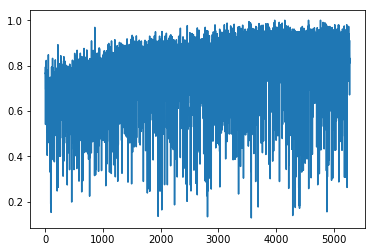

In [2]:
avg_rwd = []
for rwd in cb_ep.rewards.values():
    if (len(rwd)!=0):
        avg_rwd.append(sum(rwd)/len(rwd))
plt.plot(avg_rwd)
#plt.xlabel("step")
#plt.ylabel("pos")

In [6]:
avg_rwd = np.array(avg_rwd)
np.save('avg_rwd_{}.npy'.format(ENV_NAME), avg_rwd)

In [3]:
import requests

def telegram(message):

    bot_token = '923260274:AAHyCqG6jpPI_xo0x2wJvhGVA_oeUnMf41Y'
    bot_chatID = '763781536'
    send = 'https://api.telegram.org/bot' + bot_token + '/sendMessage?chat_id=' + bot_chatID + '&parse_mode=Markdown&text=' + message
    try:
        response = requests.get(send)
        response.raise_for_status()
    except requests.exceptions.RequestException as err:
        print ("OOps: Something Else",err)
    except requests.exceptions.HTTPError as errh:
        print ("Http Error:",errh)
    except requests.exceptions.ConnectionError as errc:
        print ("Error Connecting:",errc)
    except requests.exceptions.Timeout as errt:
        print ("Timeout Error:",errt)  
    return response.json()

message = "DQN done!\n"
telegram(message)

{'ok': True,
 'result': {'message_id': 114,
  'from': {'id': 923260274,
   'is_bot': True,
   'first_name': 'NeeNo',
   'username': 'NeeNoKibot'},
  'chat': {'id': 763781536,
   'first_name': 'Shalom',
   'username': 'NeeNoKi',
   'type': 'private'},
  'date': 1569249649,
  'text': 'DQN done!'}}